# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2022

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

### Train NetA Model

In [4]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84732; TrainLoss: 0.42223; TestAcc: 0.88490; TestLoss: 0.31776
Epoch: [ 1 / 20 ]; TrainAcc: 0.90175; TrainLoss: 0.27242; TestAcc: 0.89270; TestLoss: 0.29551
Epoch: [ 2 / 20 ]; TrainAcc: 0.91573; TrainLoss: 0.23156; TestAcc: 0.90910; TestLoss: 0.25177
Epoch: [ 3 / 20 ]; TrainAcc: 0.92692; TrainLoss: 0.19937; TestAcc: 0.91170; TestLoss: 0.24940
Epoch: [ 4 / 20 ]; TrainAcc: 0.93588; TrainLoss: 0.17696; TestAcc: 0.91490; TestLoss: 0.24606
Epoch: [ 5 / 20 ]; TrainAcc: 0.94270; TrainLoss: 0.15588; TestAcc: 0.91250; TestLoss: 0.24905
Epoch: [ 6 / 20 ]; TrainAcc: 0.95033; TrainLoss: 0.13607; TestAcc: 0.91840; TestLoss: 0.23980
Epoch: [ 7 / 20 ]; TrainAcc: 0.95643; TrainLoss: 0.11869; TestAcc: 0.91580; TestLoss: 0.25933
Epoch: [ 8 / 20 ]; TrainAcc: 0.96143; TrainLoss: 0.10443; TestAcc: 0.91140; TestLoss: 0.29291
Epoch: [ 9 / 20 ]; TrainAcc: 0.96772; TrainLoss: 0.08769; TestAcc: 0.91520; TestLoss: 0.30840
Epoch: [ 10 / 20 ]; TrainAcc: 0.97118; TrainLoss: 0.07893; T

### Train NetB Model

In [5]:
## Pick a model architecture
#net = models.NetA().to(device)
net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84058; TrainLoss: 0.43344; TestAcc: 0.88030; TestLoss: 0.33354
Epoch: [ 1 / 20 ]; TrainAcc: 0.90405; TrainLoss: 0.26533; TestAcc: 0.90650; TestLoss: 0.26193
Epoch: [ 2 / 20 ]; TrainAcc: 0.91903; TrainLoss: 0.22319; TestAcc: 0.91390; TestLoss: 0.23323
Epoch: [ 3 / 20 ]; TrainAcc: 0.92928; TrainLoss: 0.19518; TestAcc: 0.91580; TestLoss: 0.23343
Epoch: [ 4 / 20 ]; TrainAcc: 0.93640; TrainLoss: 0.17405; TestAcc: 0.91990; TestLoss: 0.22148
Epoch: [ 5 / 20 ]; TrainAcc: 0.94325; TrainLoss: 0.15476; TestAcc: 0.91310; TestLoss: 0.24235
Epoch: [ 6 / 20 ]; TrainAcc: 0.94890; TrainLoss: 0.13852; TestAcc: 0.91970; TestLoss: 0.23416
Epoch: [ 7 / 20 ]; TrainAcc: 0.95448; TrainLoss: 0.12485; TestAcc: 0.91950; TestLoss: 0.24180
Epoch: [ 8 / 20 ]; TrainAcc: 0.95963; TrainLoss: 0.11057; TestAcc: 0.91940; TestLoss: 0.25053
Epoch: [ 9 / 20 ]; TrainAcc: 0.96315; TrainLoss: 0.09936; TestAcc: 0.92020; TestLoss: 0.26278
Epoch: [ 10 / 20 ]; TrainAcc: 0.96838; TrainLoss: 0.08779; T

**Visualize some perturbed samples**

b)

Epsilon:  0.0


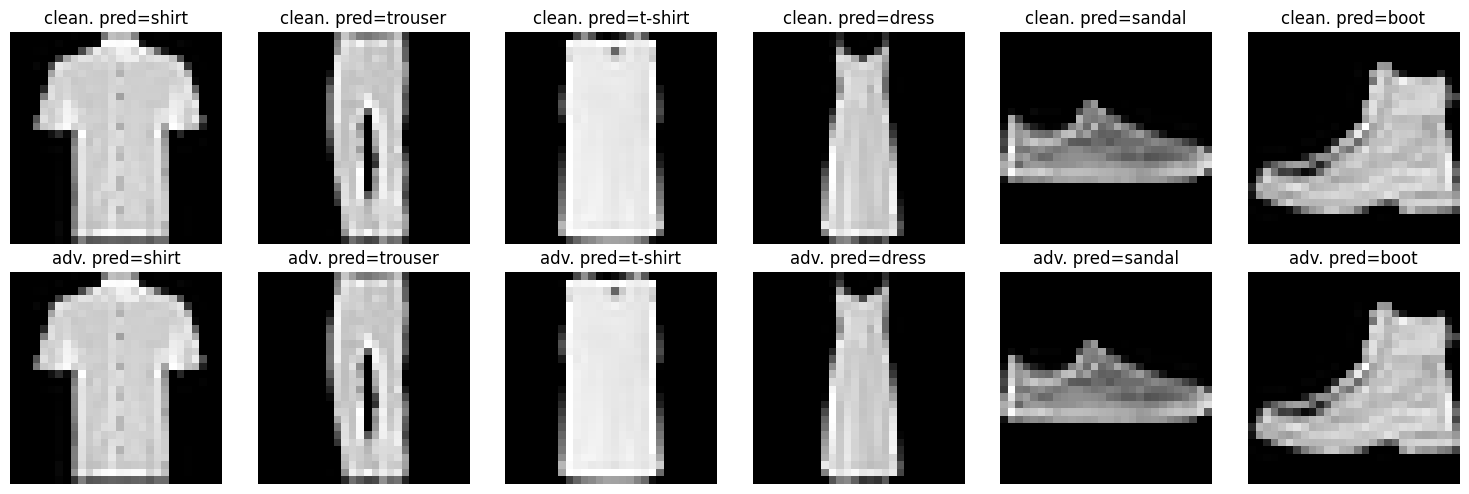

Epsilon:  0.05


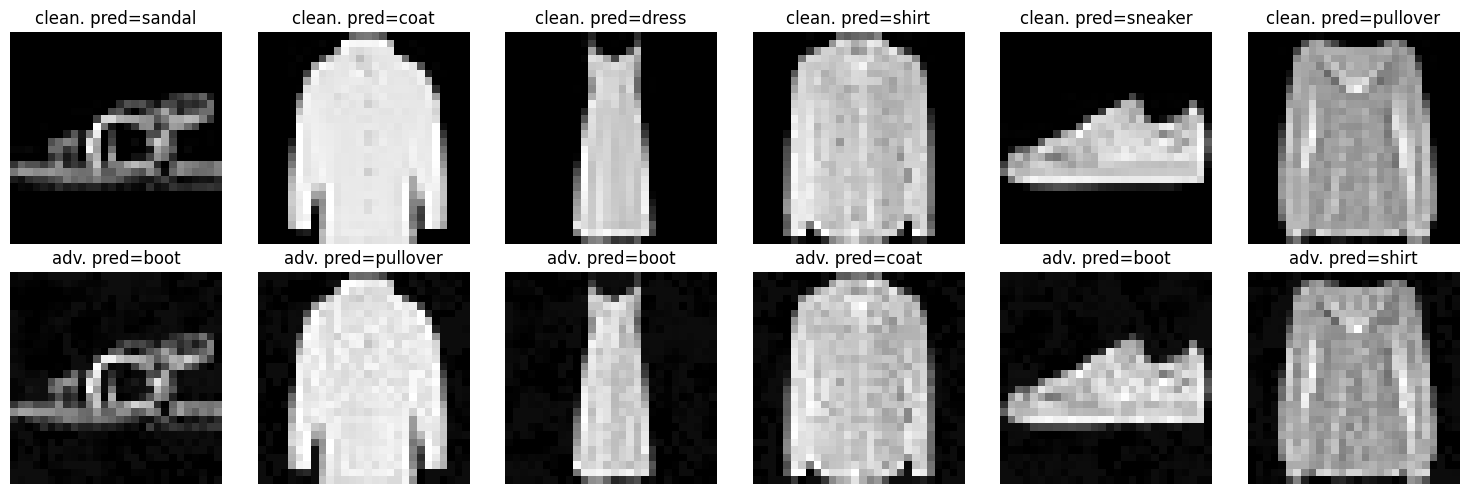

Epsilon:  0.1


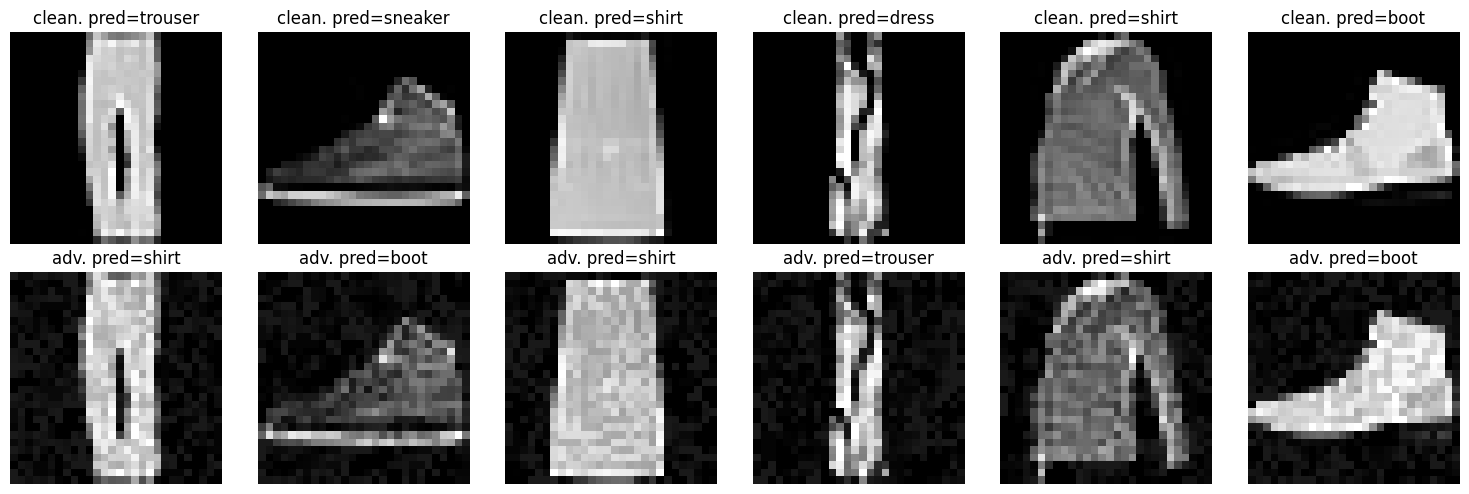

Epsilon:  0.15000000000000002


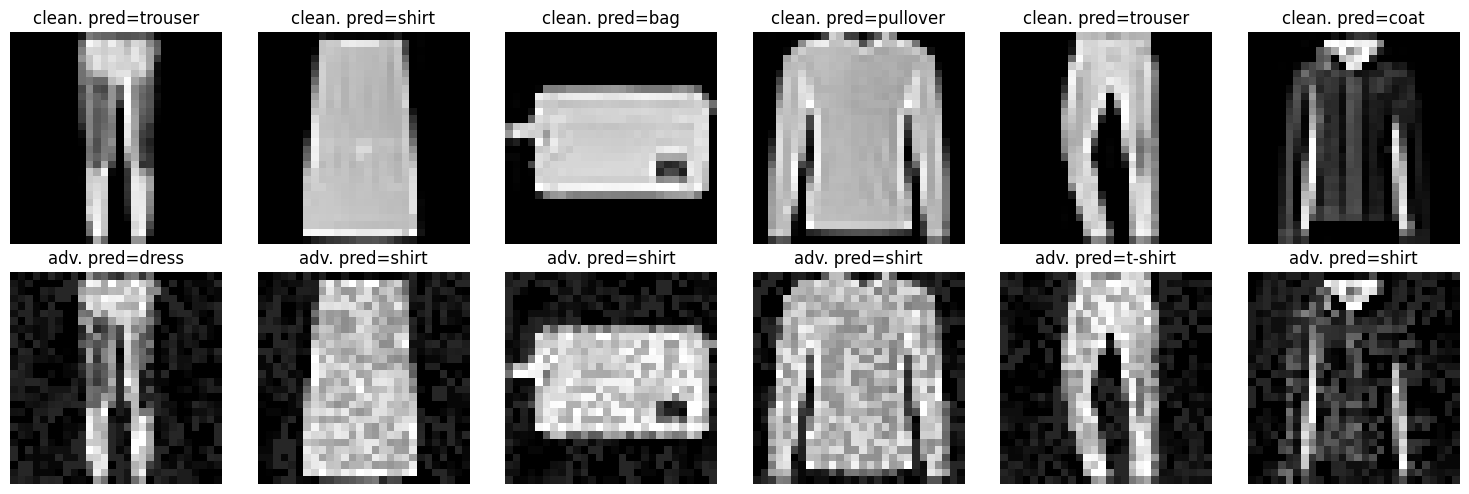

Epsilon:  0.2


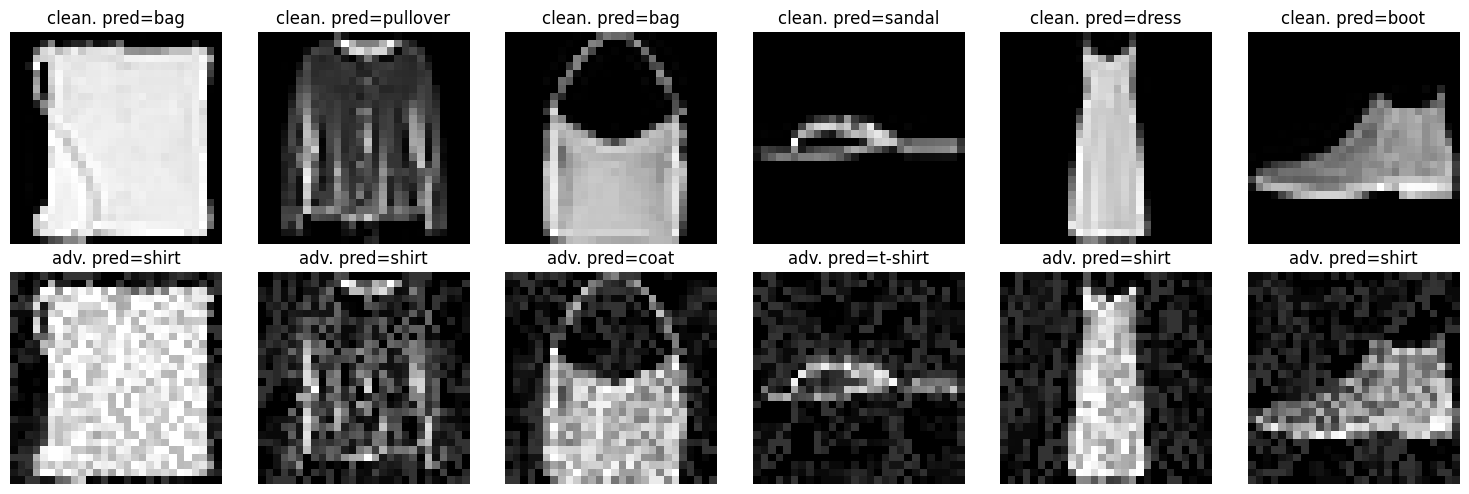

In [5]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

epsilons = np.linspace(0, 0.2, 5)

for eps in epsilons:
    for data,labels in test_loader:
            data = data.to(device); labels = labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            EPS= eps
            ITS=10
            ALP = 1.85*(EPS/ITS)
            adv_data = attacks.PGD_attack(net, device, data, labels, EPS, ALP, ITS, rand_start = True) 
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            print("Epsilon: ", eps)
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.tight_layout()
            plt.show()
            break

c)

FGSM attack:
Epsilon:  0.0


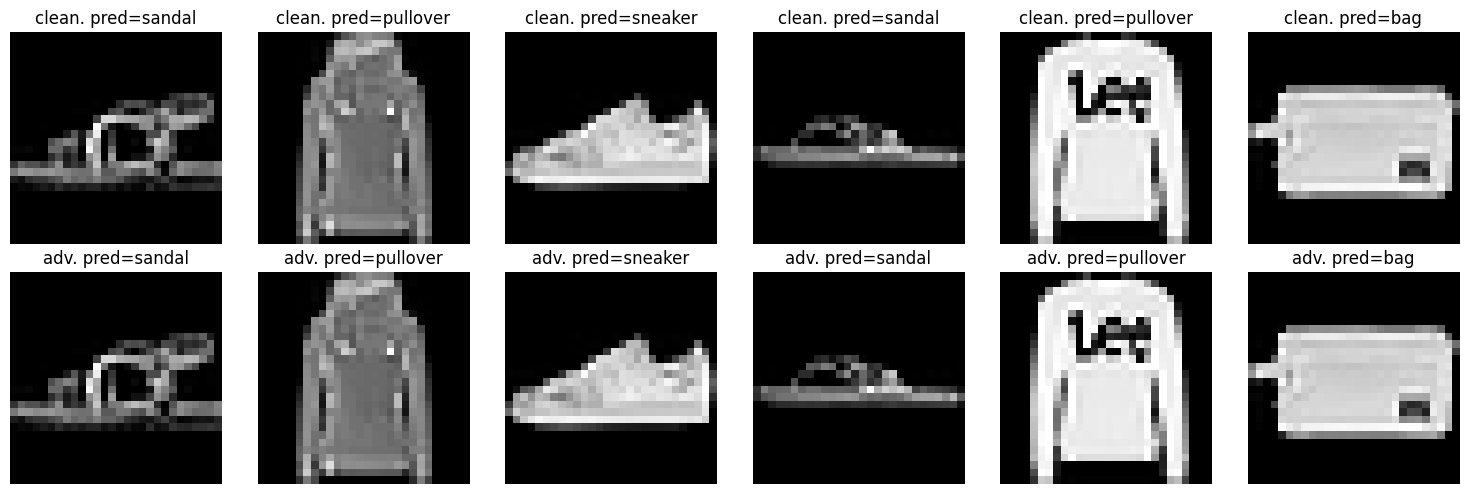

Epsilon:  0.05


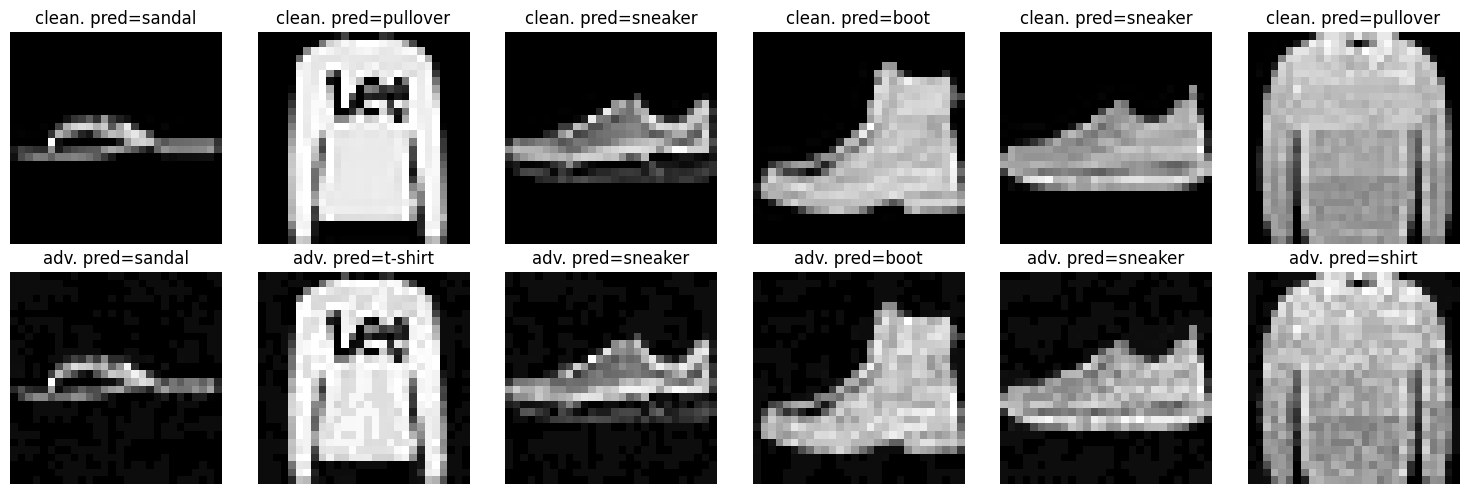

Epsilon:  0.1


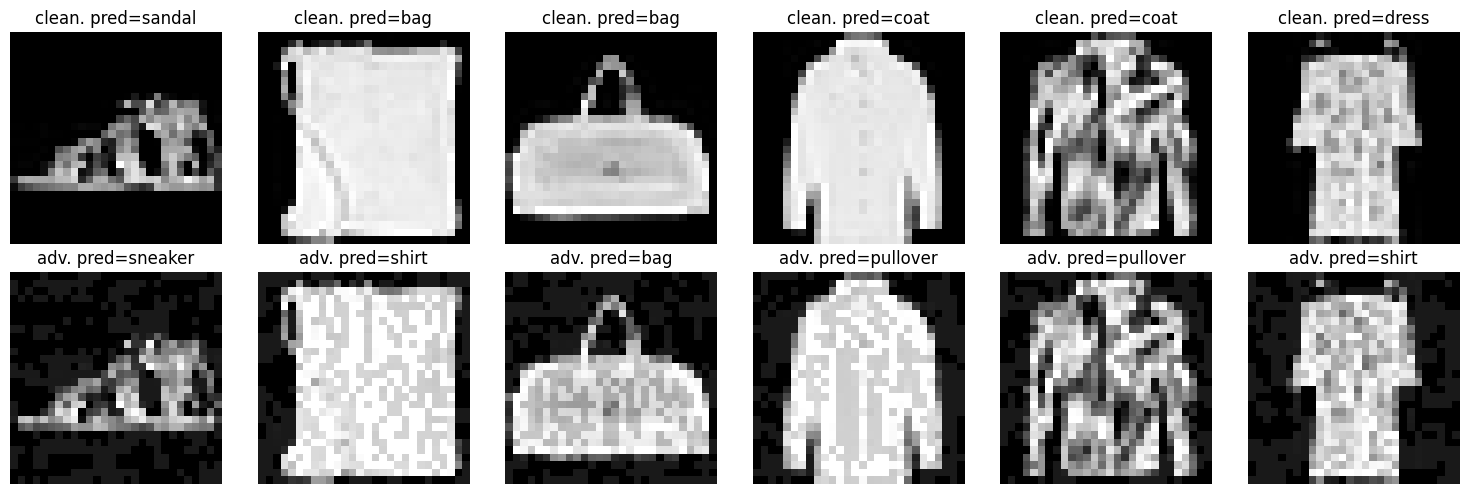

Epsilon:  0.15000000000000002


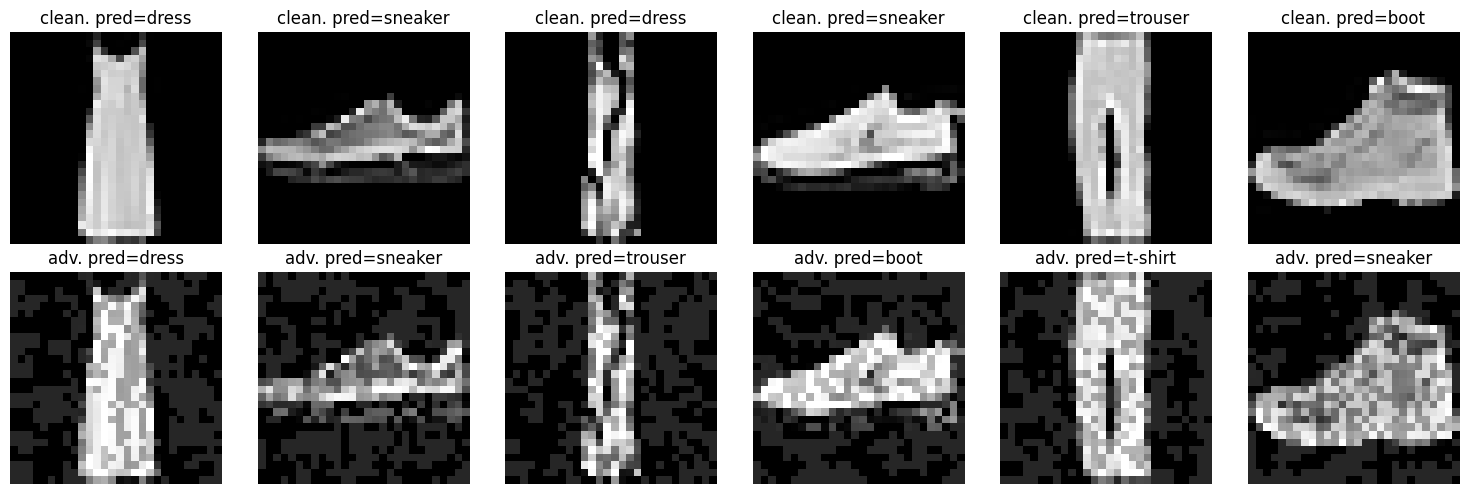

Epsilon:  0.2


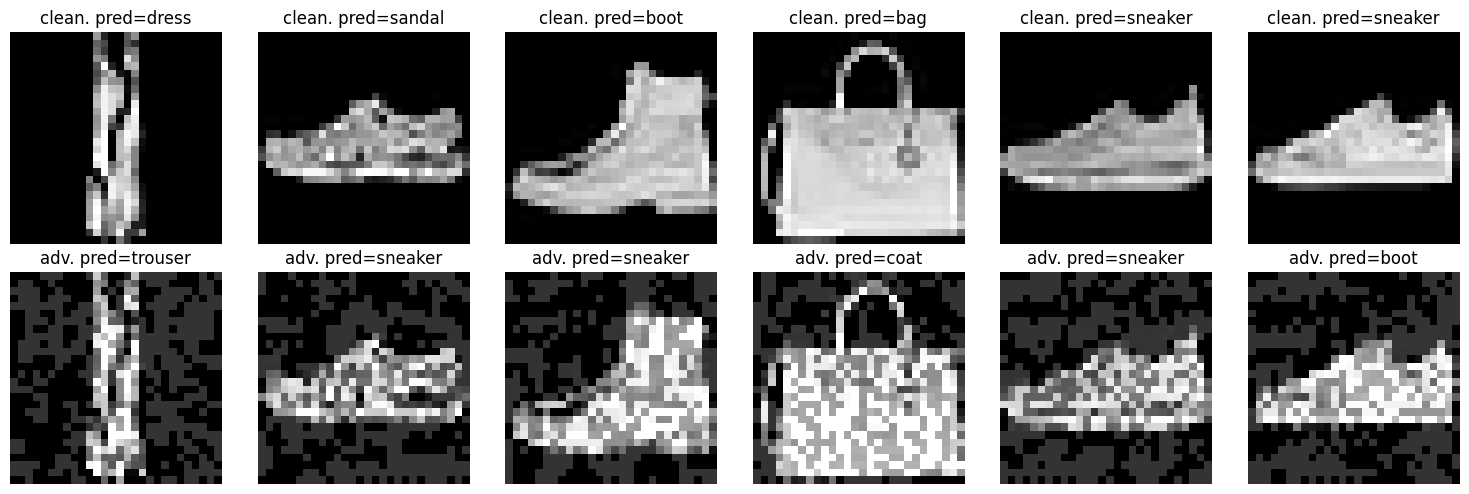

In [4]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

epsilons = np.linspace(0, 0.2, 5)

print("FGSM attack:")

for eps in epsilons:
    for data,labels in test_loader:
            data = data.to(device); labels = labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            EPS= eps
            ITS=1
            ALP = 1.85*(EPS/ITS)
            adv_data = attacks.FGSM_attack(net, device, data, labels, eps, iters = ITS)
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            print("Epsilon: ", eps)
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.tight_layout()
            plt.show()
            break

rFGSM attack:
Epsilon:  0.0


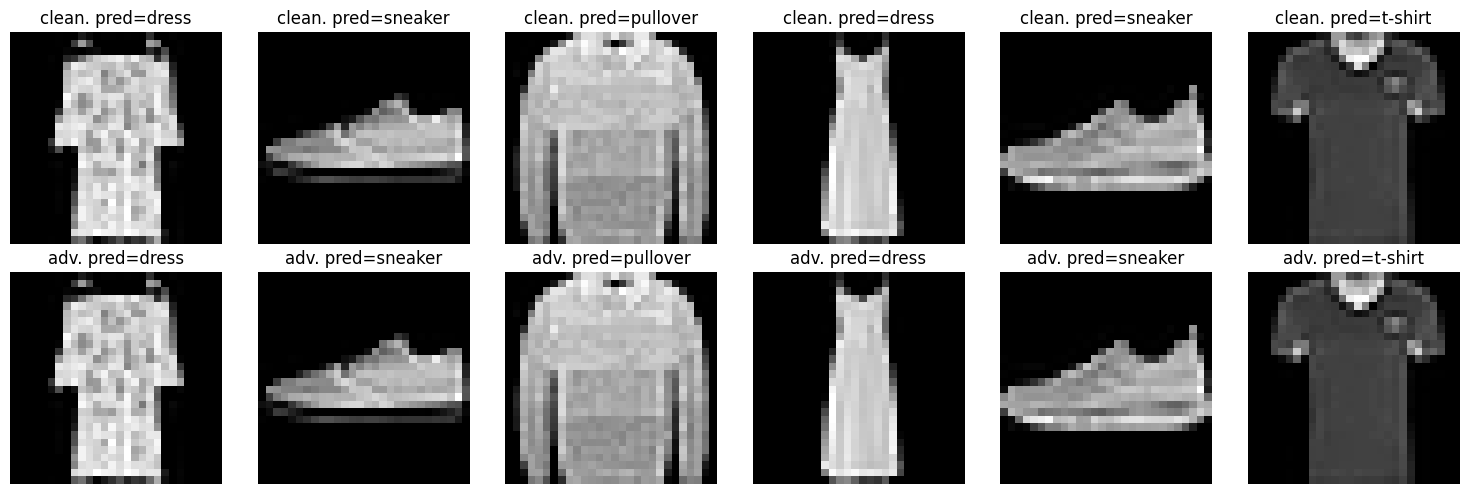

Epsilon:  0.05


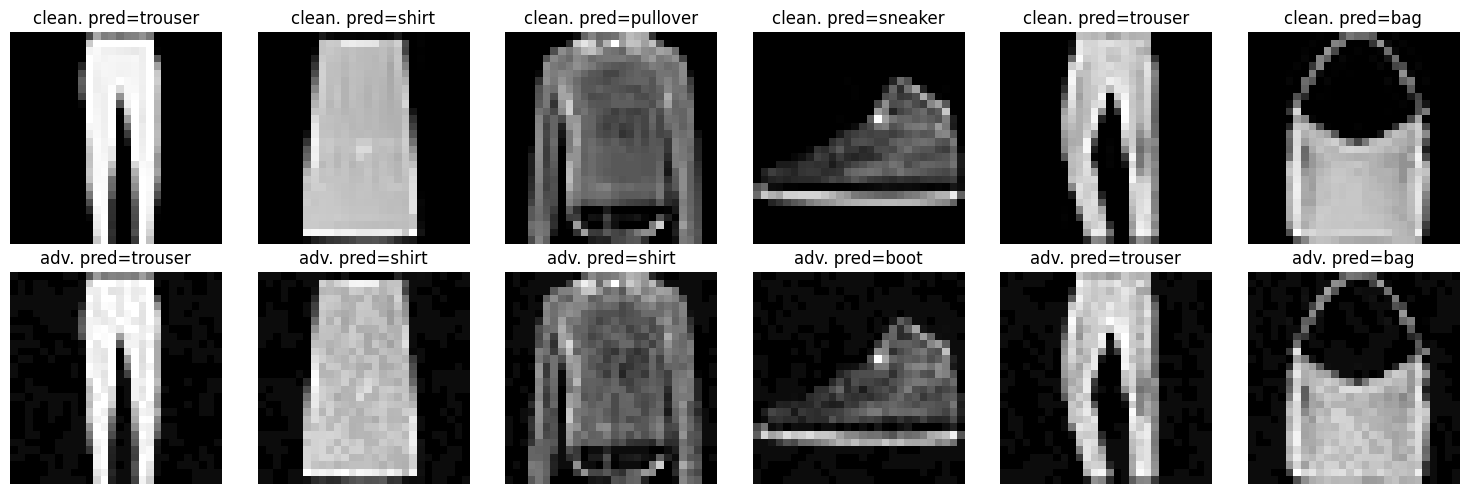

Epsilon:  0.1


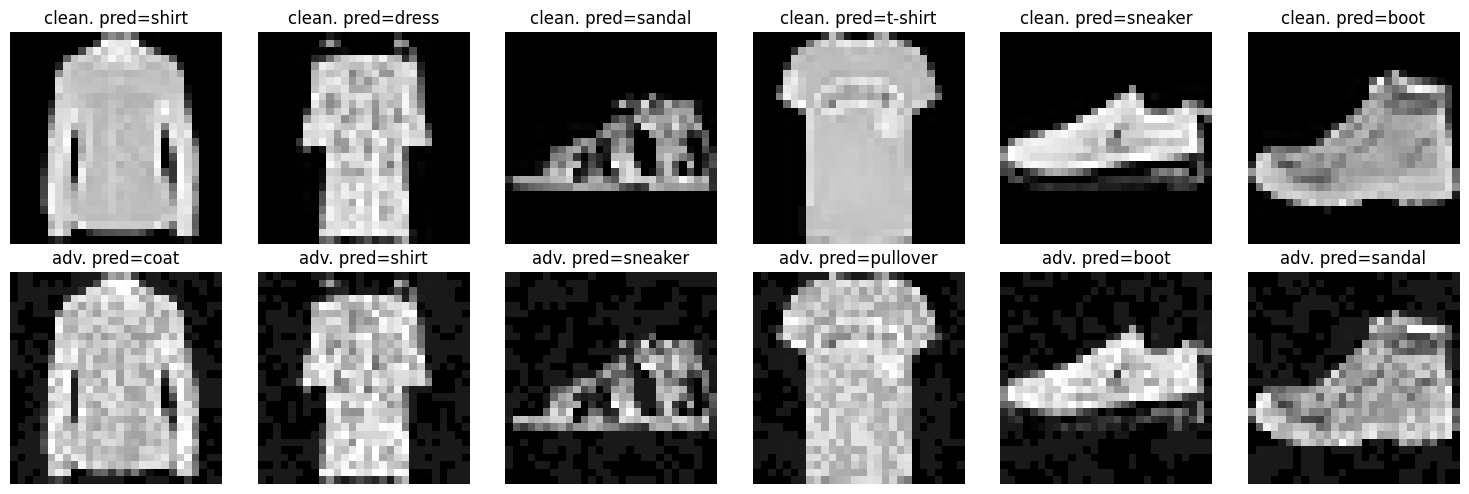

Epsilon:  0.15000000000000002


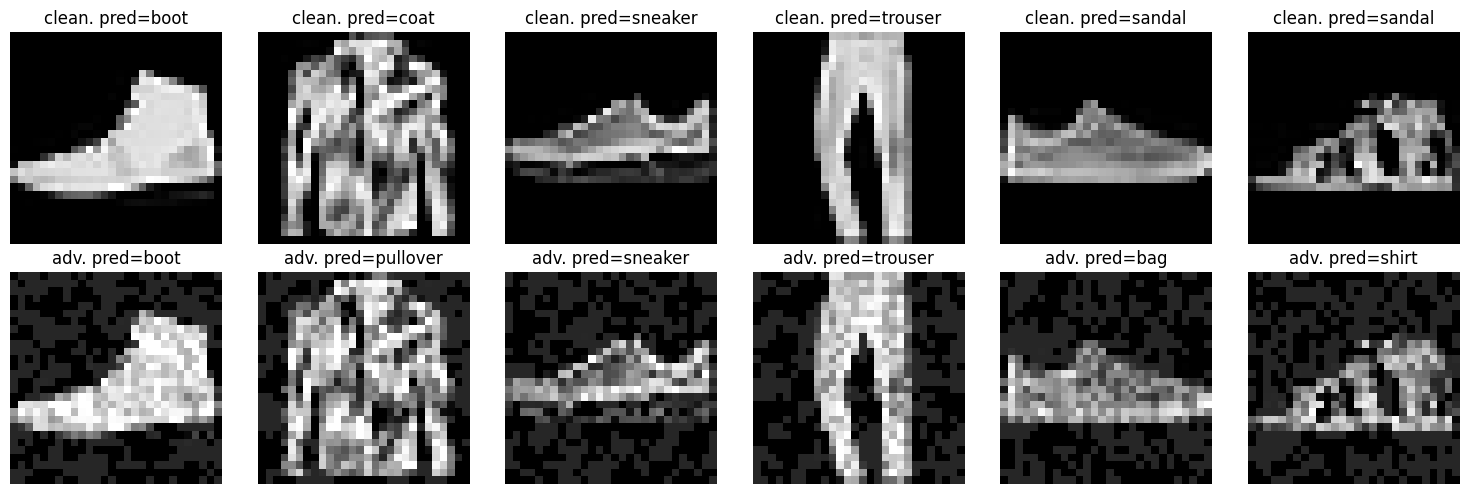

Epsilon:  0.2


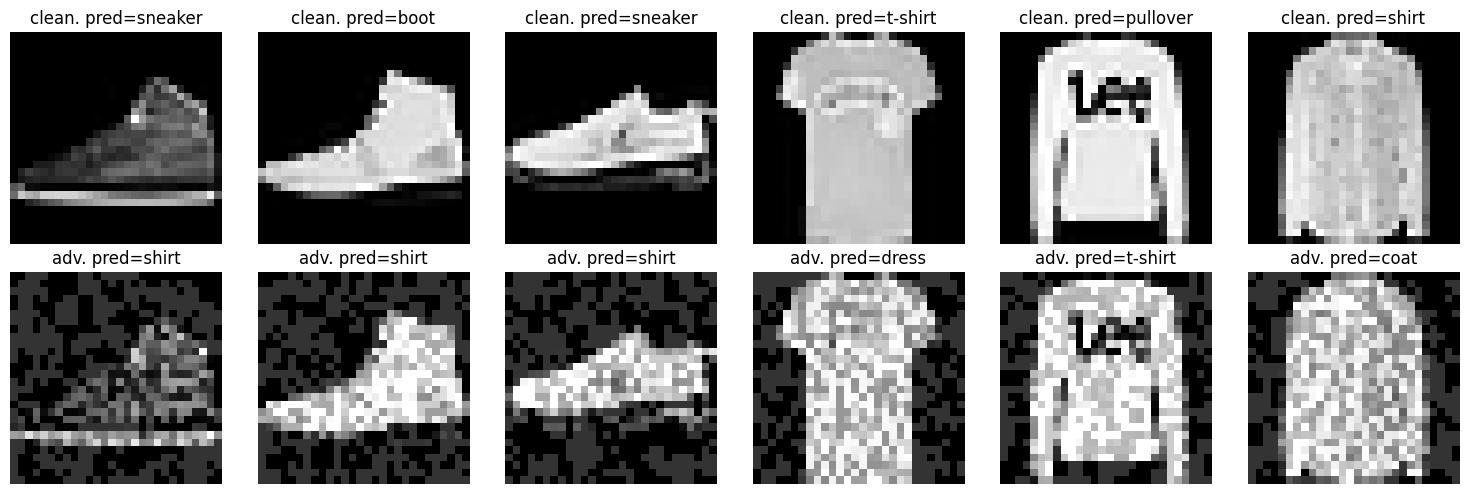

In [5]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

epsilons = np.linspace(0, 0.2, 5)

print("rFGSM attack:")

for eps in epsilons:
    for data,labels in test_loader:
            data = data.to(device); labels = labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            EPS= eps
            ITS=1
            ALP = 1.85*(EPS/ITS)
            adv_data = attacks.rFGSM_attack(net, device, data, labels, eps, iters = ITS)
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            print("Epsilon: ", eps)
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.tight_layout()
            plt.show()
            break

d)

L2 constrained FGSM attack:
Epsilon:  0.0


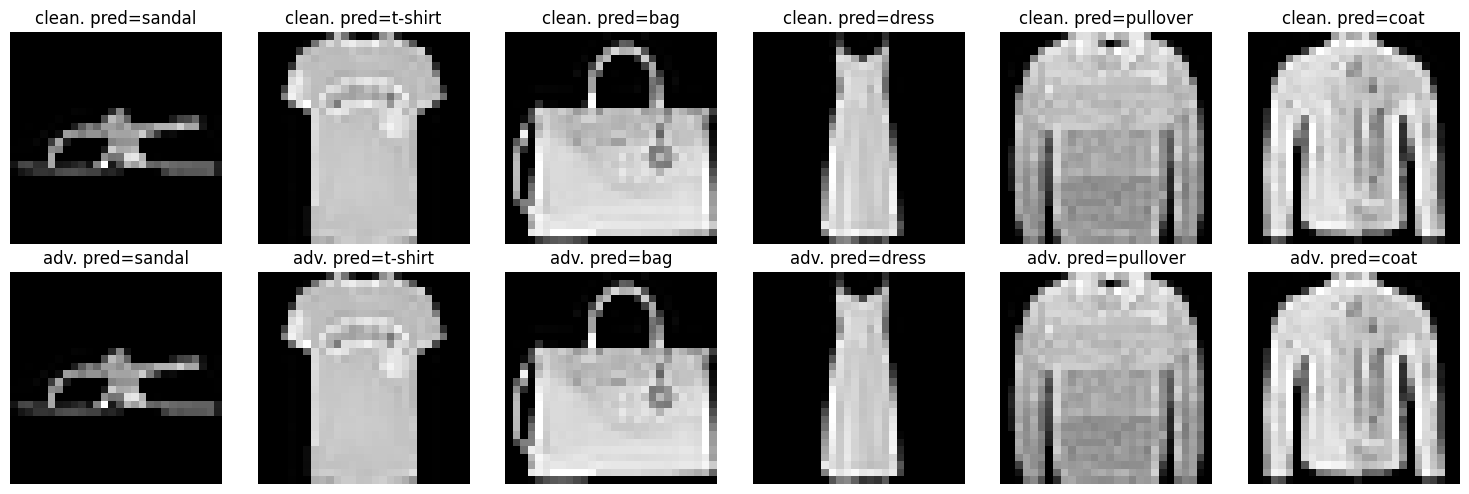

Epsilon:  1.0


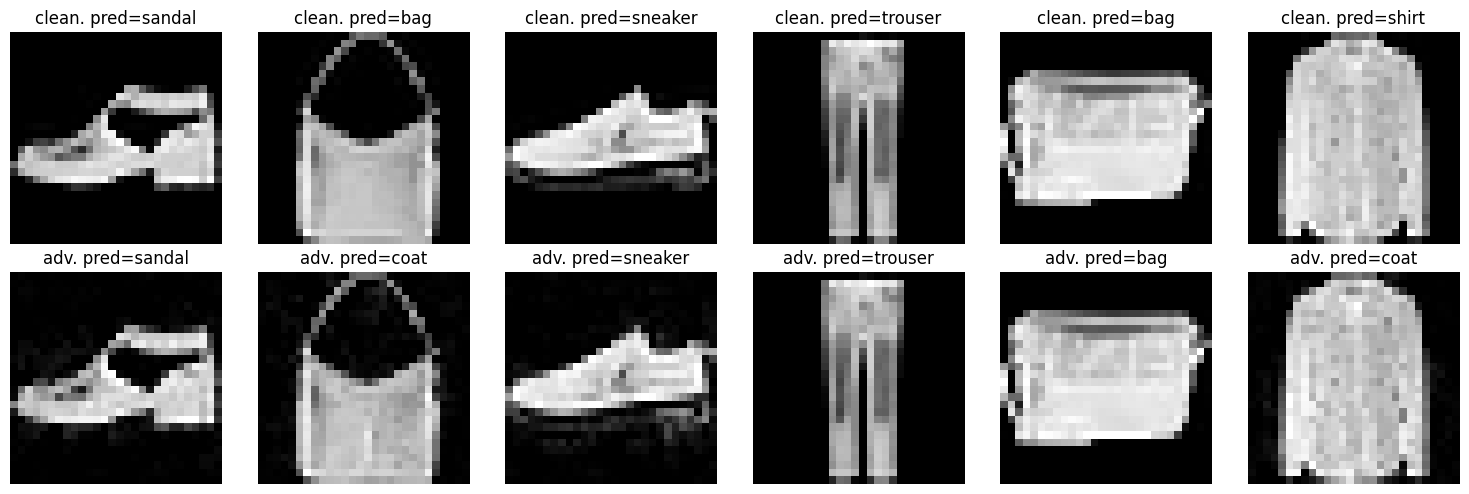

Epsilon:  2.0


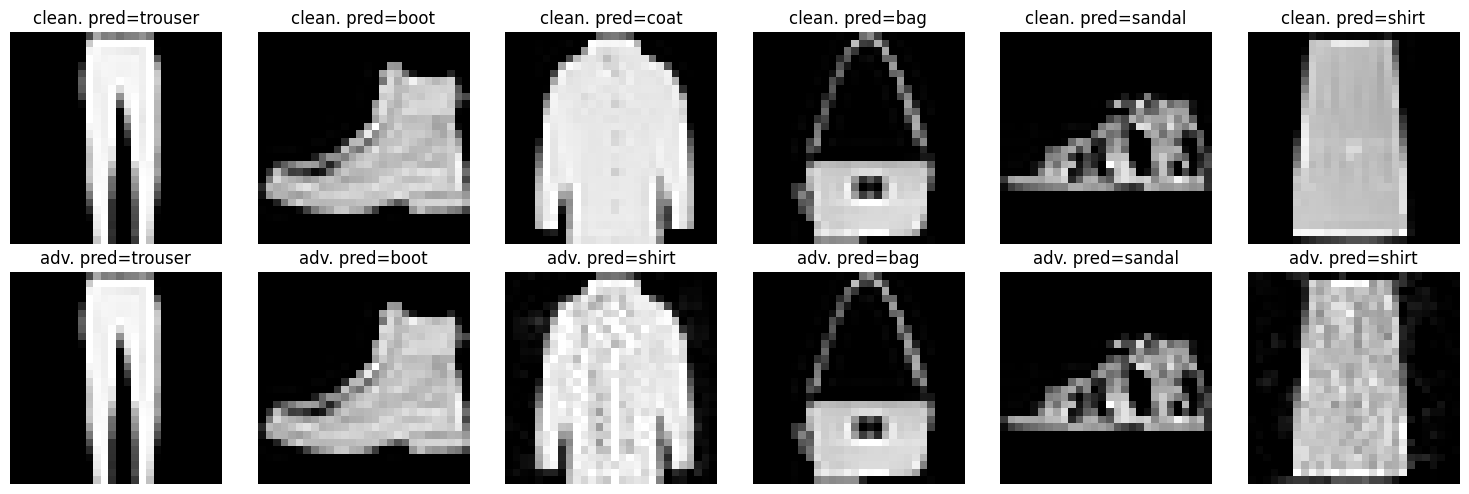

Epsilon:  3.0


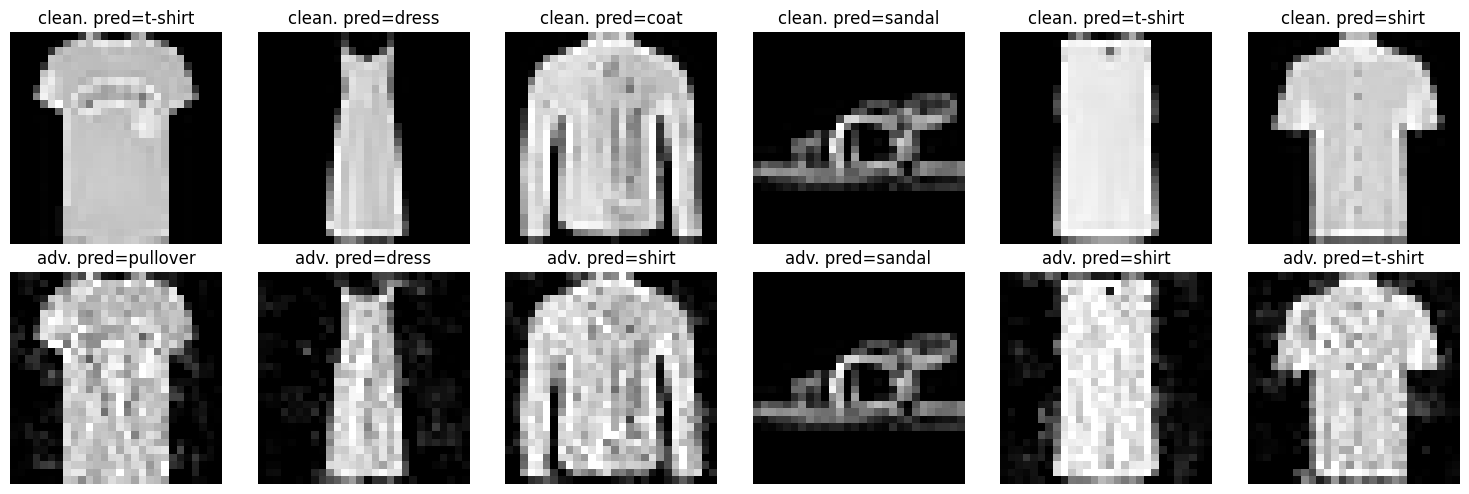

Epsilon:  4.0


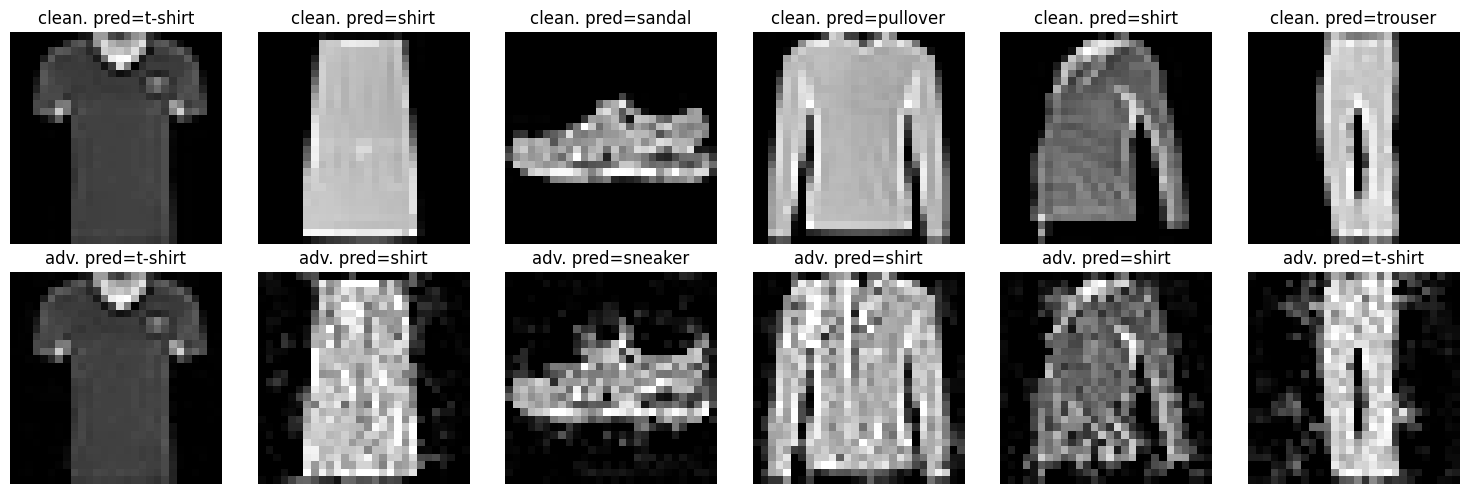

In [4]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

epsilons = np.linspace(0, 4, 5)

print("L2 constrained FGSM attack:")

for eps in epsilons:
    for data,labels in test_loader:
            data = data.to(device); labels = labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            EPS= eps
            ITS=1
            ALP = 1.85*(EPS/ITS)
            adv_data = attacks.FGM_L2_attack(net, device, data, labels, EPS)
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            print("Epsilon: ", eps)
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.tight_layout()
            plt.show()
            break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [5]:
def plot_accuracy_curves(whitebox_accuracies, blackbox_accuracies, epsilons = np.linspace(0, 0.1, 11), attacks = ['Baseline (Random)', 'FGSM', 'rFGSM', 'PGD']):
    """Helper function to plot accuracy vs. epsilon figures"""
    fig, ax = plt.subplots(1, 2, figsize = (12, 5))

    for i in range(len(attacks)):
        ax[0].plot(epsilons, whitebox_accuracies[i], label = f'{attacks[i]} Whitebox Accuracy')
        ax[1].plot(epsilons, blackbox_accuracies[i], label = f'{attacks[i]} Blackbox Accuracy')
    ax[0].set_title("Whitebox Accuracies For Epsilon Values")
    ax[0].set_xlabel("Epsilon")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_title("Blackbox Accuracies For Epsilon Values")
    ax[1].set_xlabel("Epsilon")
    ax[1].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])
    ax[1].set_ylim([0,1])
    ax[0].legend()
    ax[1].legend()
    fig.show()

b) Random Uniform Perturbations

Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


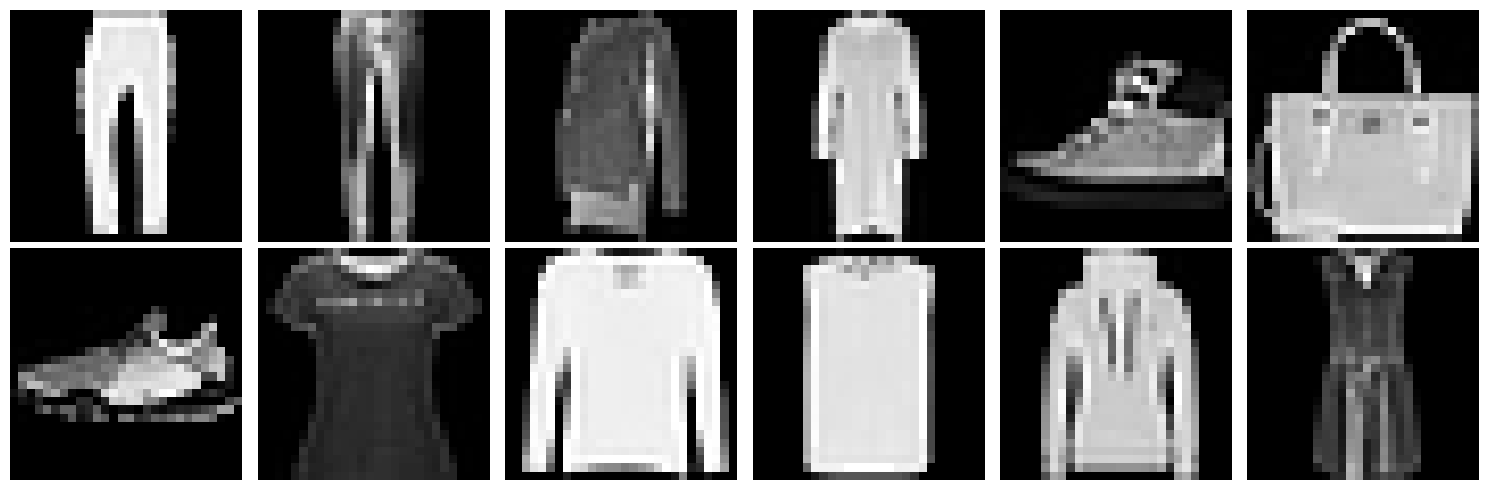

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9239; Blackbox Accuracy: 0.9284
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


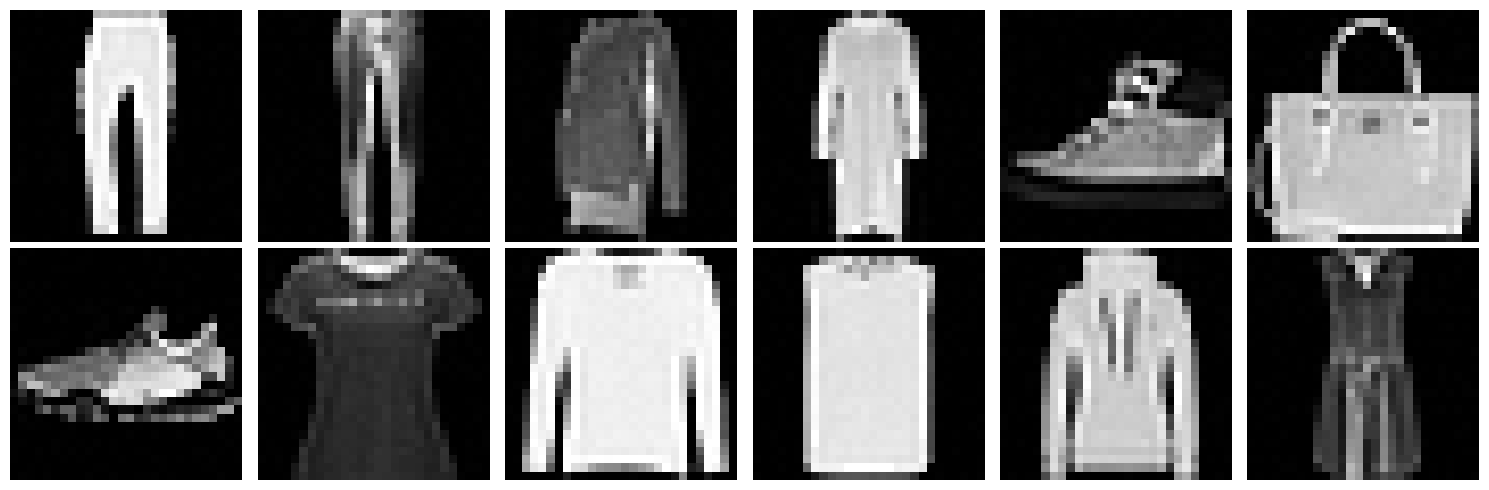

Attack Epsilon: 0.01; Whitebox Accuracy: 0.9239; Blackbox Accuracy: 0.928
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


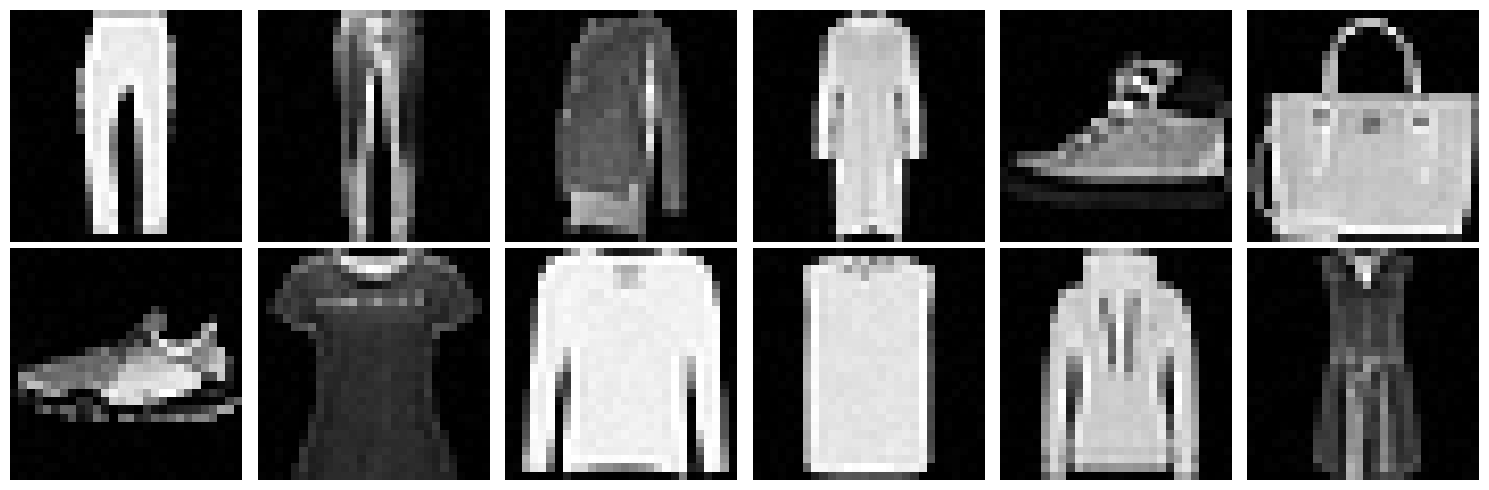

Attack Epsilon: 0.02; Whitebox Accuracy: 0.9217; Blackbox Accuracy: 0.9229
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


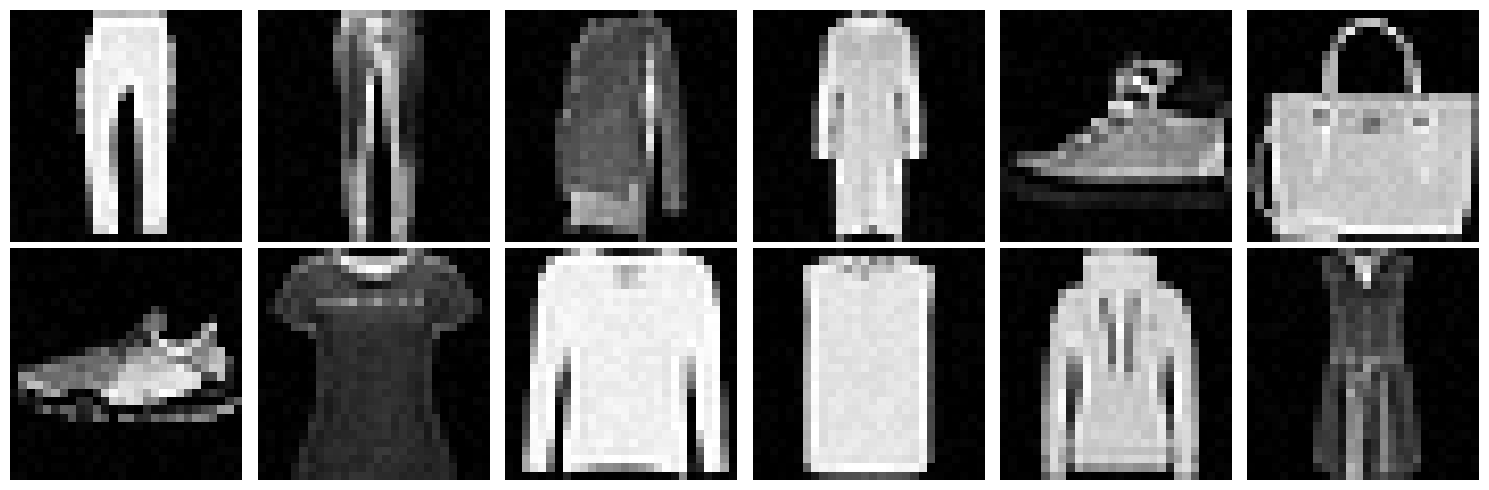

Attack Epsilon: 0.03; Whitebox Accuracy: 0.9206; Blackbox Accuracy: 0.919
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


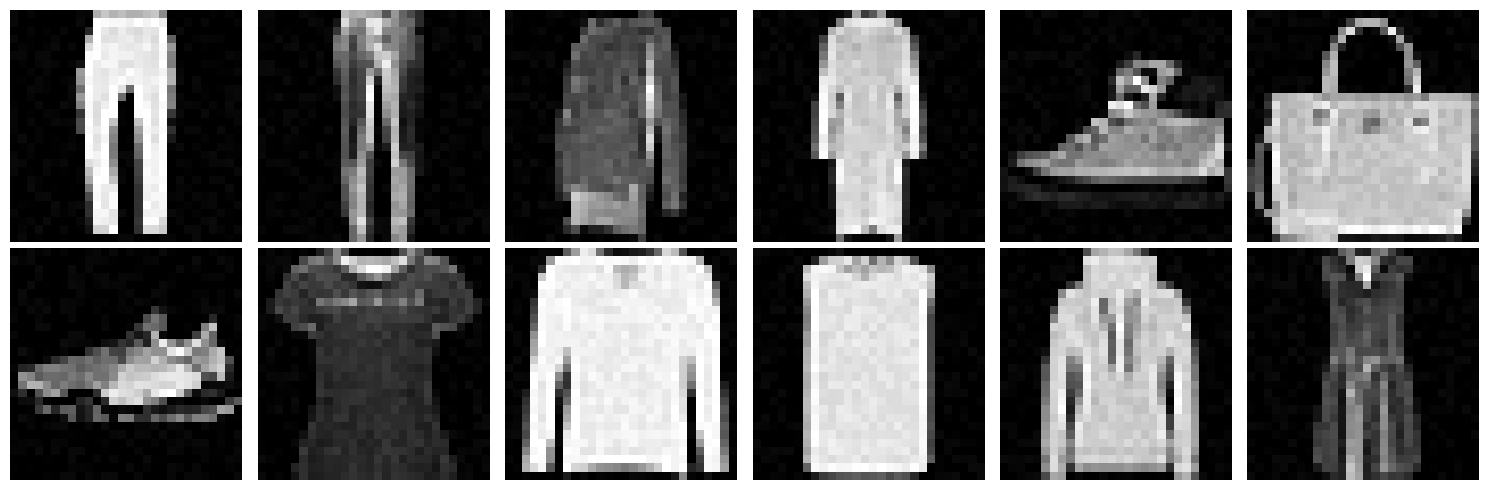

Attack Epsilon: 0.04; Whitebox Accuracy: 0.9199; Blackbox Accuracy: 0.9117
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


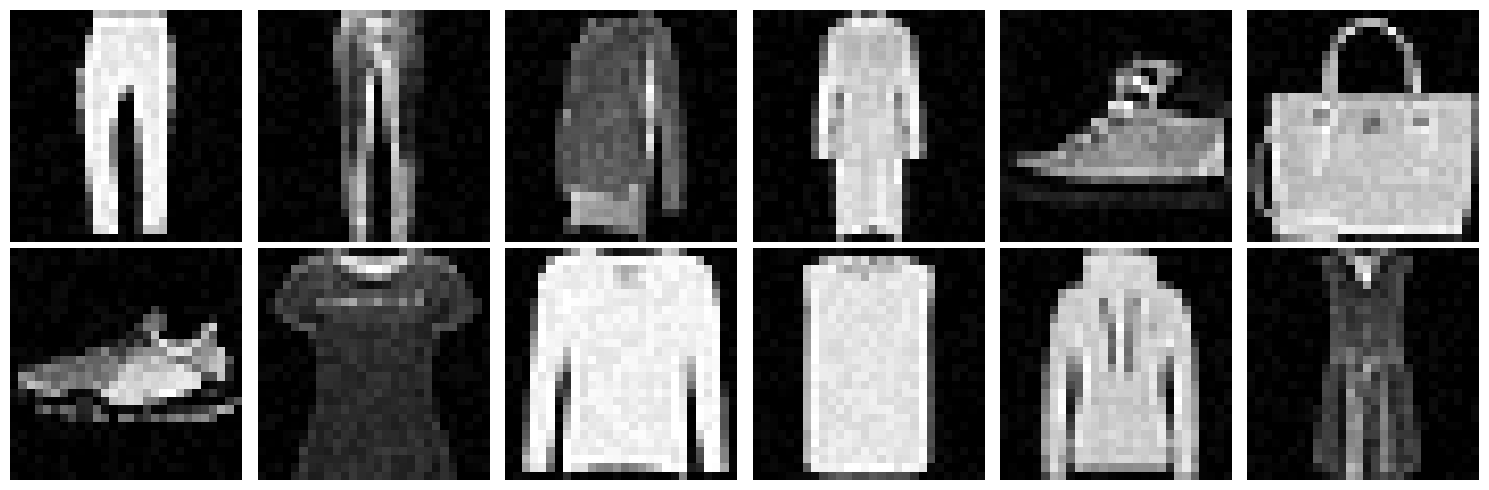

Attack Epsilon: 0.05; Whitebox Accuracy: 0.9159; Blackbox Accuracy: 0.9044
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


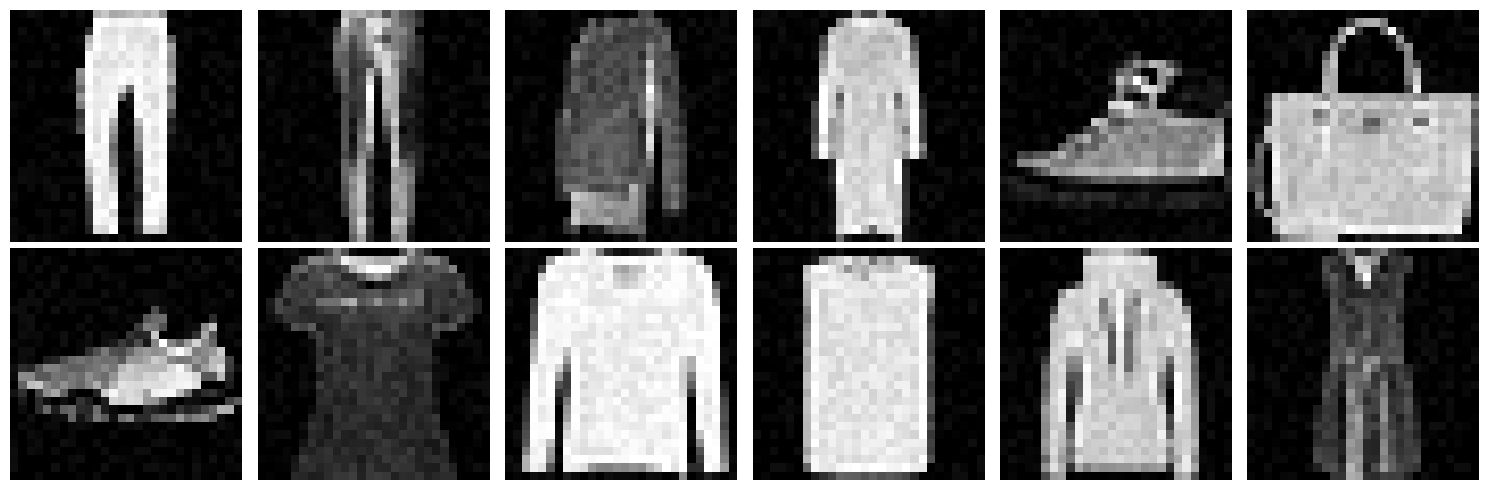

Attack Epsilon: 0.06; Whitebox Accuracy: 0.9132; Blackbox Accuracy: 0.8953
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


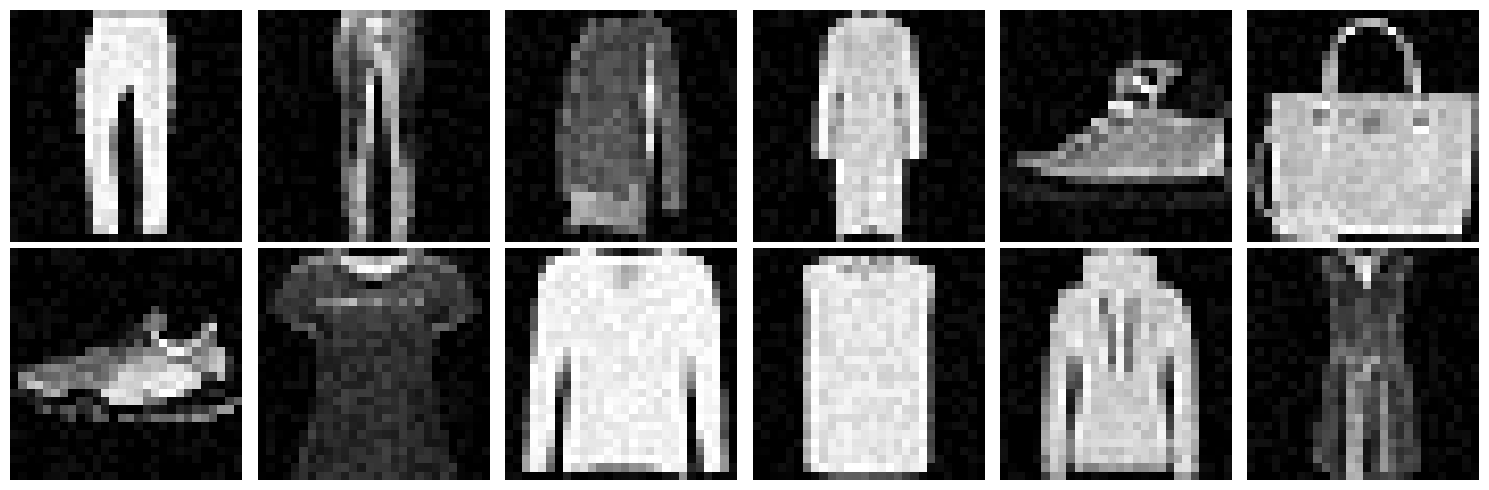

Attack Epsilon: 0.07; Whitebox Accuracy: 0.9107; Blackbox Accuracy: 0.8826
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


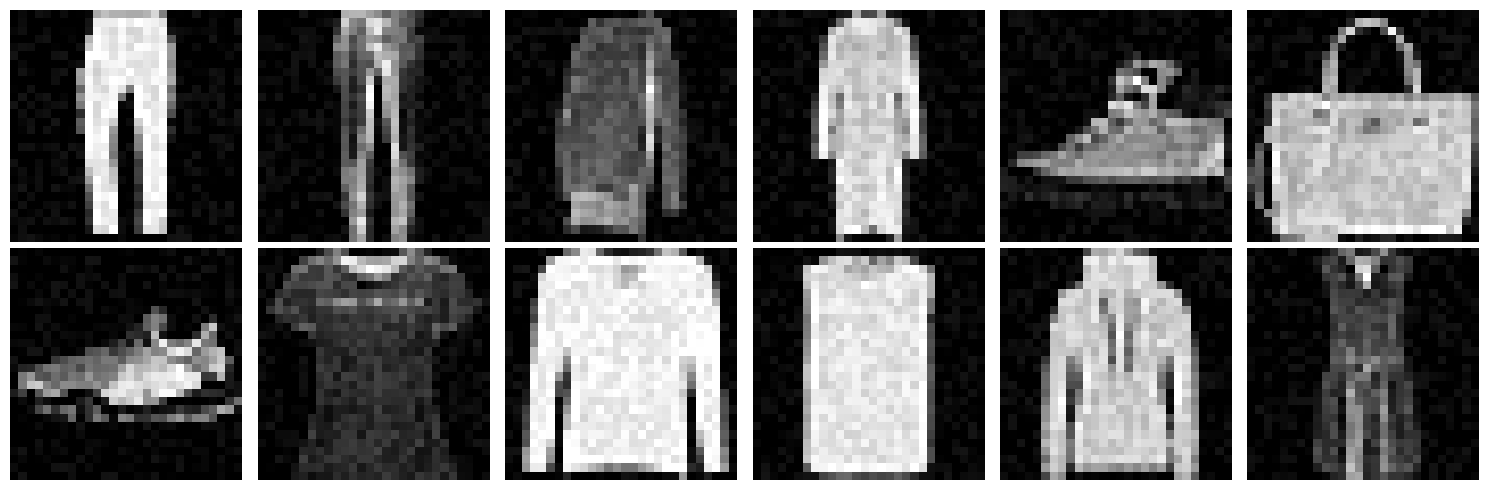

Attack Epsilon: 0.08; Whitebox Accuracy: 0.9059; Blackbox Accuracy: 0.8694
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


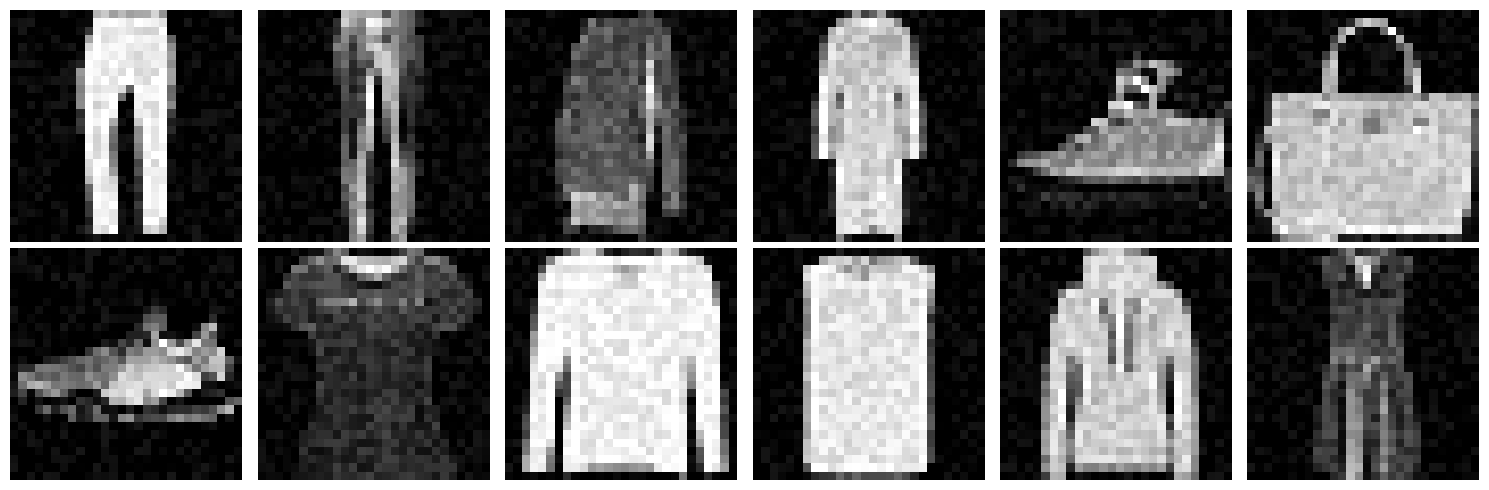

Attack Epsilon: 0.09; Whitebox Accuracy: 0.8985; Blackbox Accuracy: 0.8546
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


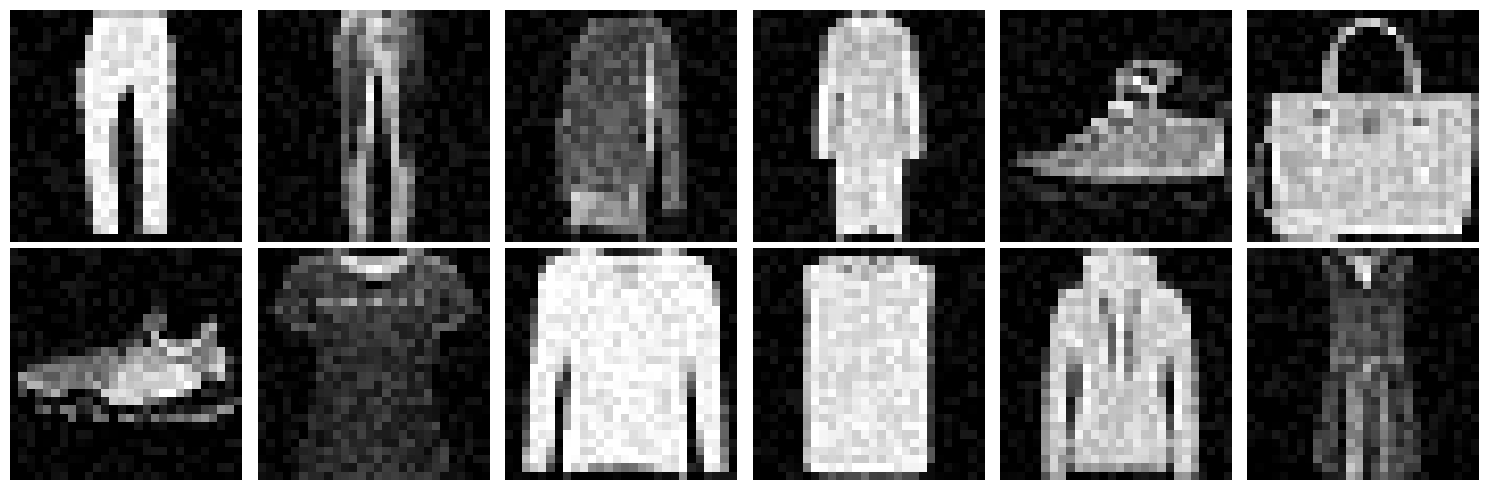

Attack Epsilon: 0.1; Whitebox Accuracy: 0.896; Blackbox Accuracy: 0.8372
Done!


In [5]:
epsilons = np.linspace(0, 0.1, 11)
random_whitebox_accuracies = []
random_blackbox_accuracies = []

for eps in epsilons:

    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
    blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.random_noise_attack(whitebox, device, data, ATK_EPS) #Question: do we use the whitebox one to create adv data? yes

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # add to accuracies
    random_whitebox_accuracies.append(whitebox_acc)
    random_blackbox_accuracies.append(blackbox_acc)

    print("Done!")

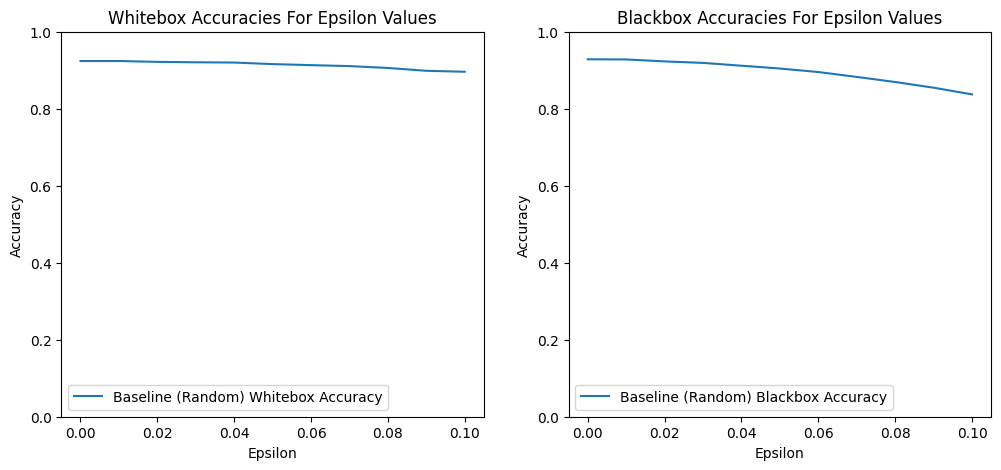

In [6]:
plot_accuracy_curves([random_whitebox_accuracies], [random_blackbox_accuracies], attacks = ['Baseline (Random)'])

c)

FGSM Attack

Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


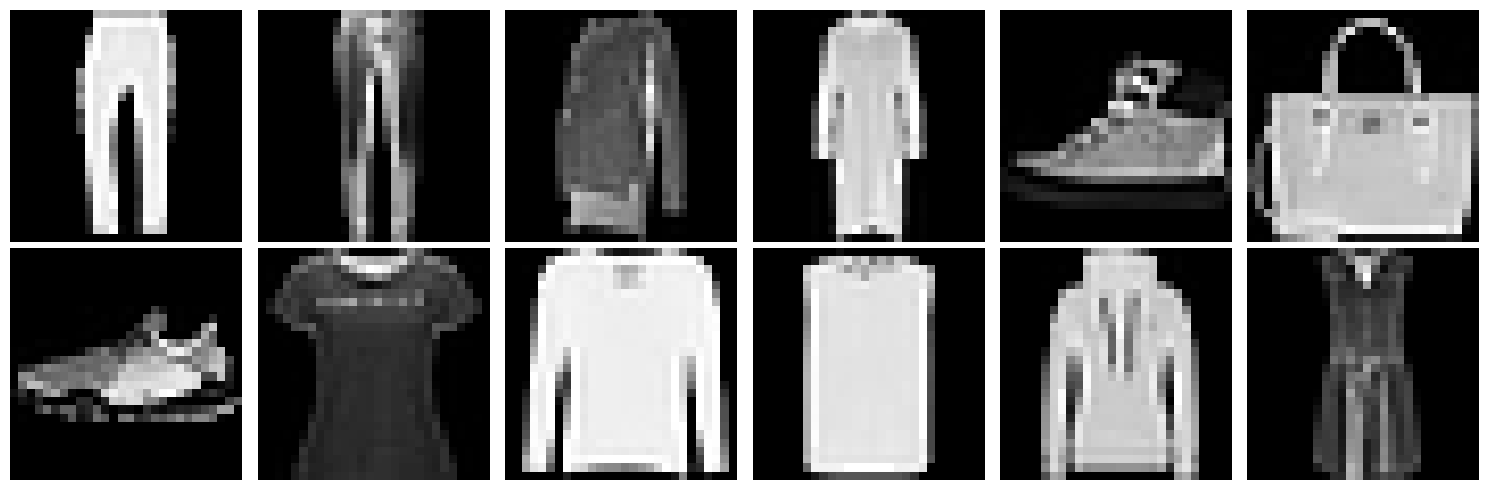

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9239; Blackbox Accuracy: 0.9284
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


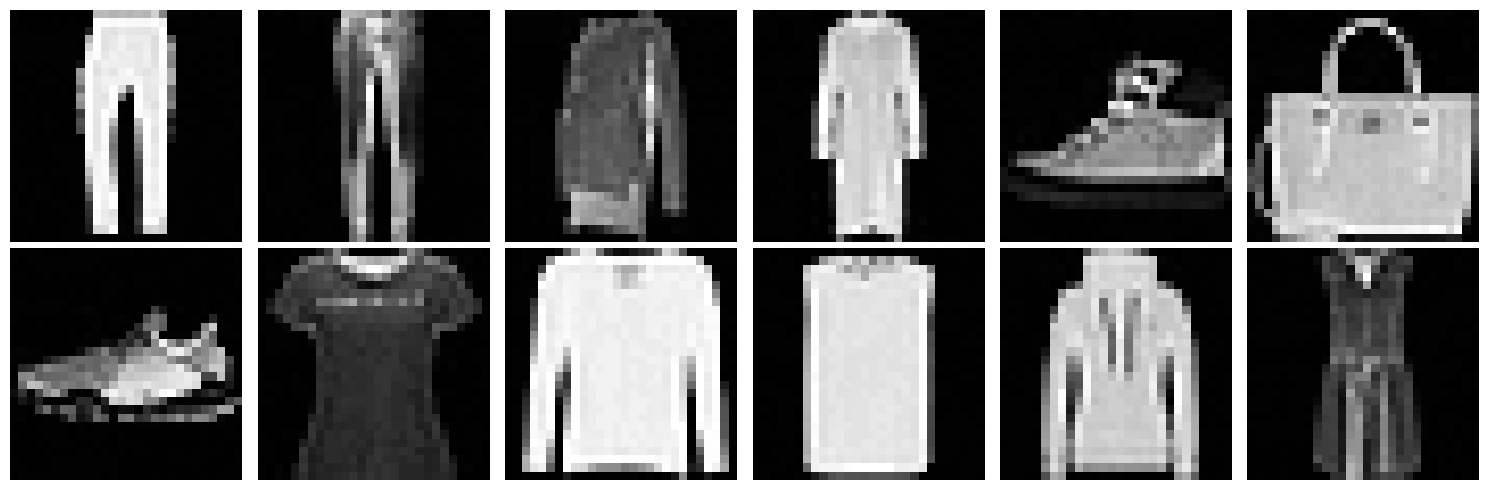

Attack Epsilon: 0.01; Whitebox Accuracy: 0.705; Blackbox Accuracy: 0.8876
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


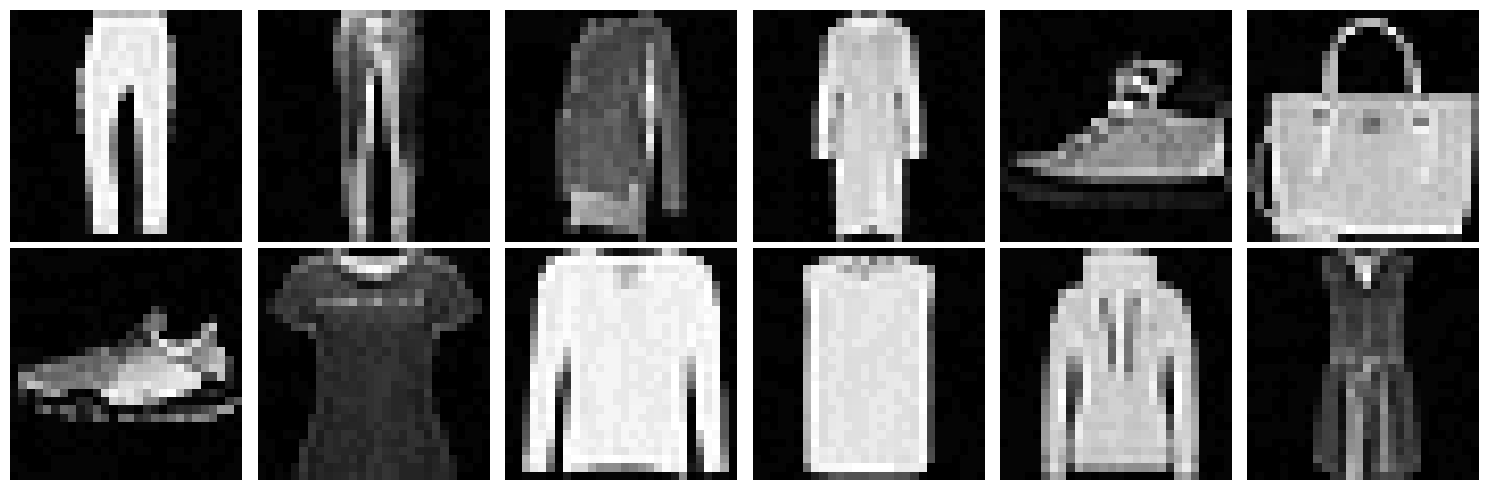

Attack Epsilon: 0.02; Whitebox Accuracy: 0.5716; Blackbox Accuracy: 0.8376
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


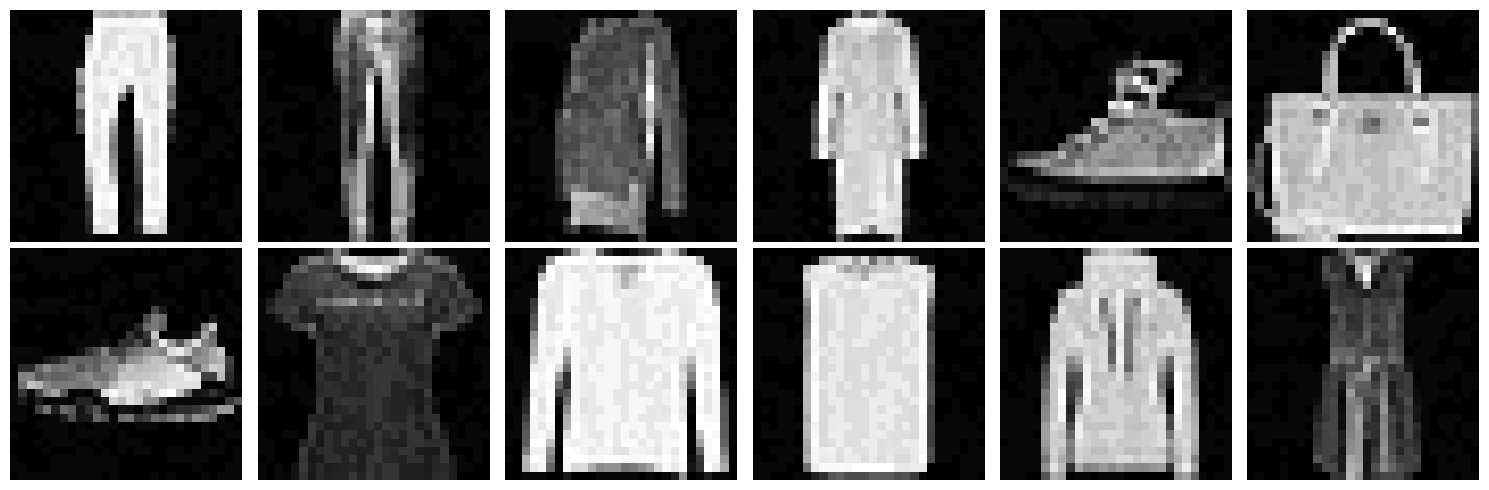

Attack Epsilon: 0.03; Whitebox Accuracy: 0.5104; Blackbox Accuracy: 0.7892
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


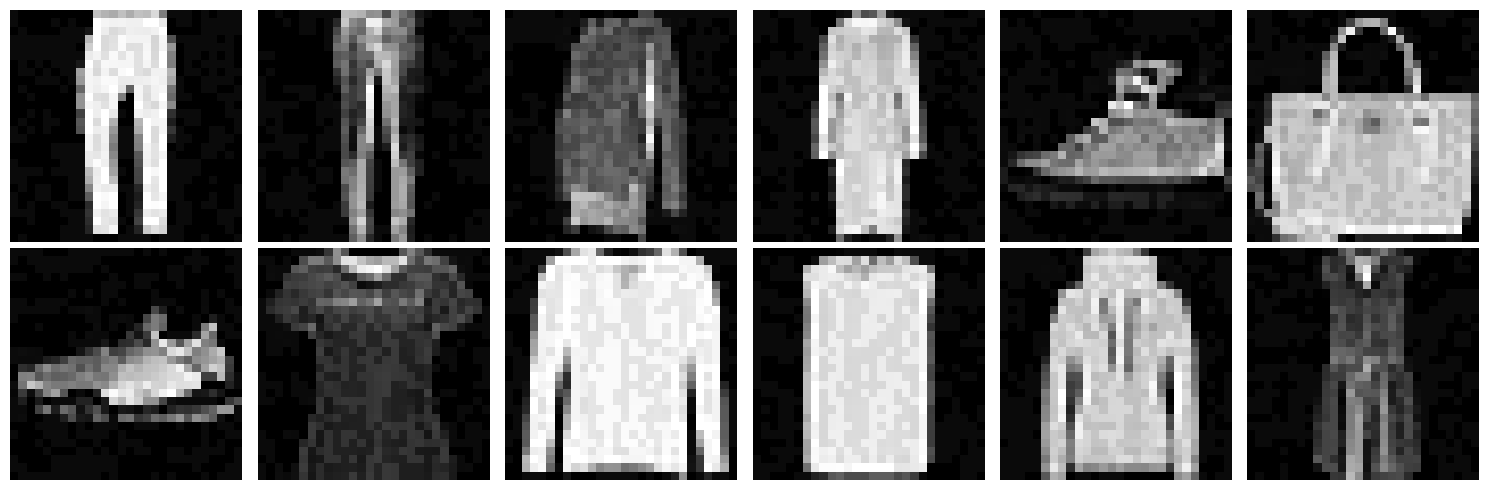

Attack Epsilon: 0.04; Whitebox Accuracy: 0.4653; Blackbox Accuracy: 0.7327
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


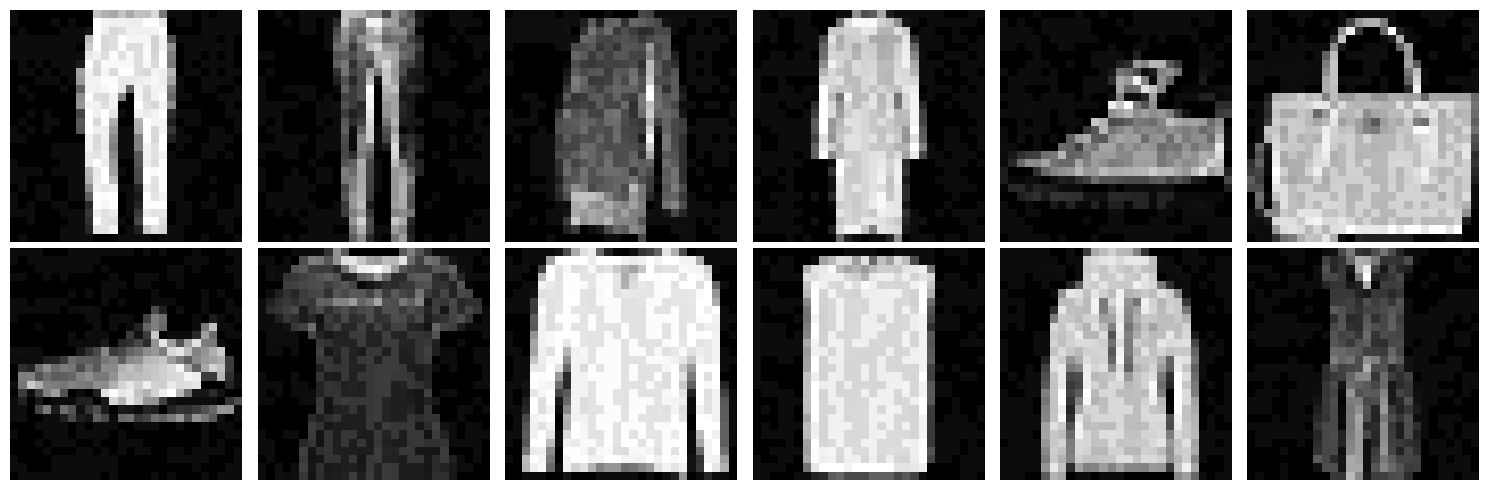

Attack Epsilon: 0.05; Whitebox Accuracy: 0.4305; Blackbox Accuracy: 0.6823
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


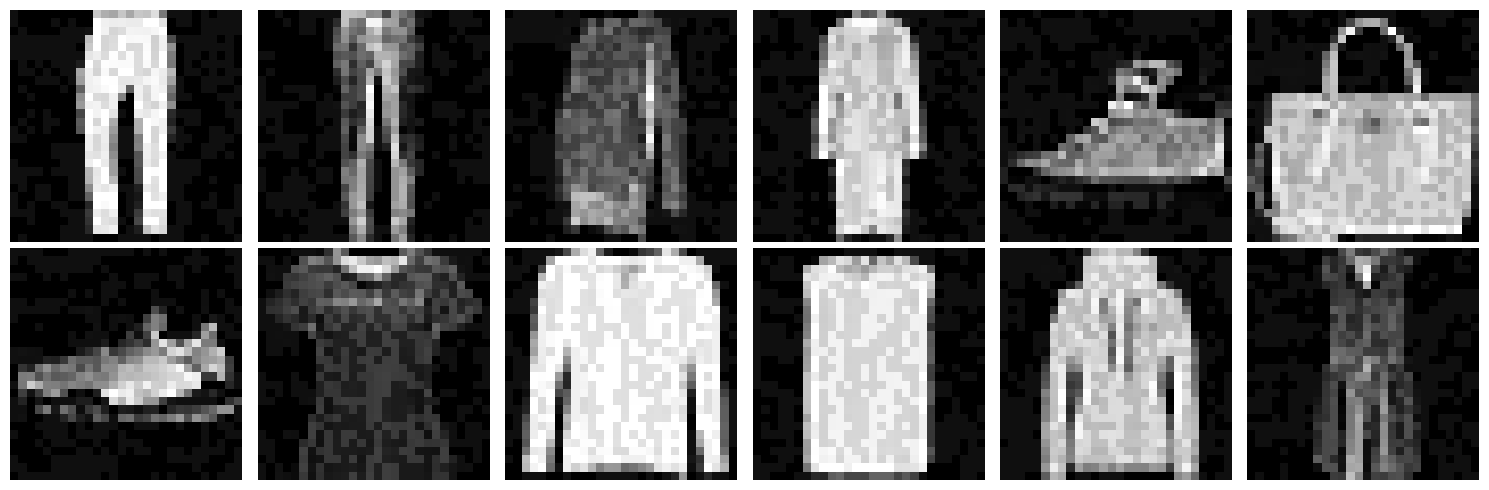

Attack Epsilon: 0.06; Whitebox Accuracy: 0.4029; Blackbox Accuracy: 0.6357
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


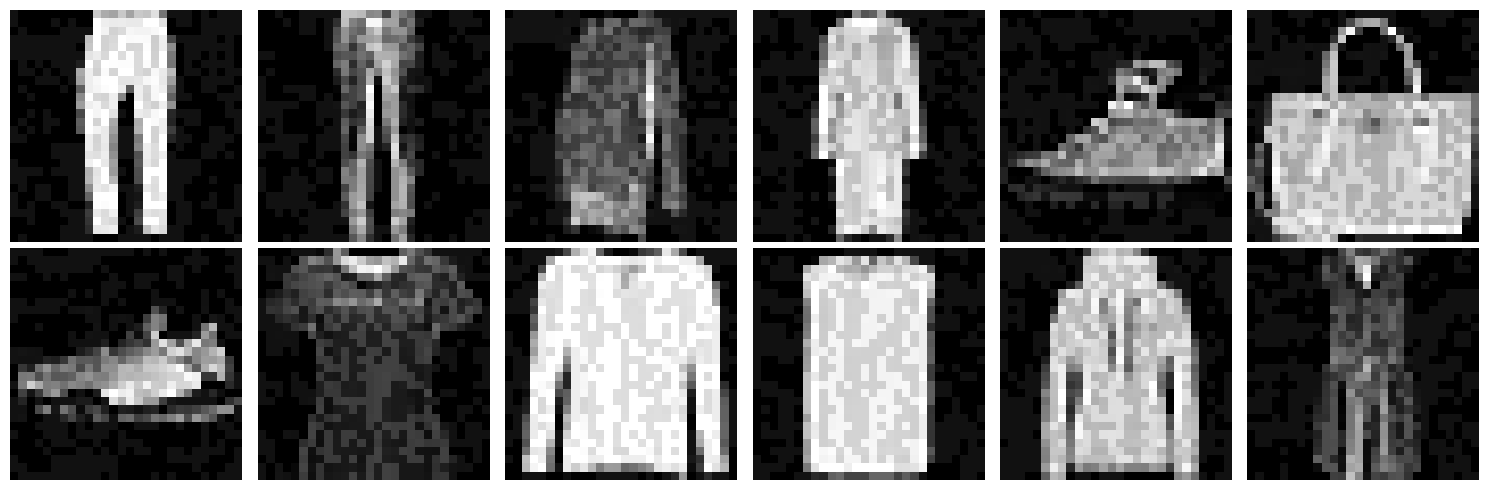

Attack Epsilon: 0.07; Whitebox Accuracy: 0.3796; Blackbox Accuracy: 0.5945
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


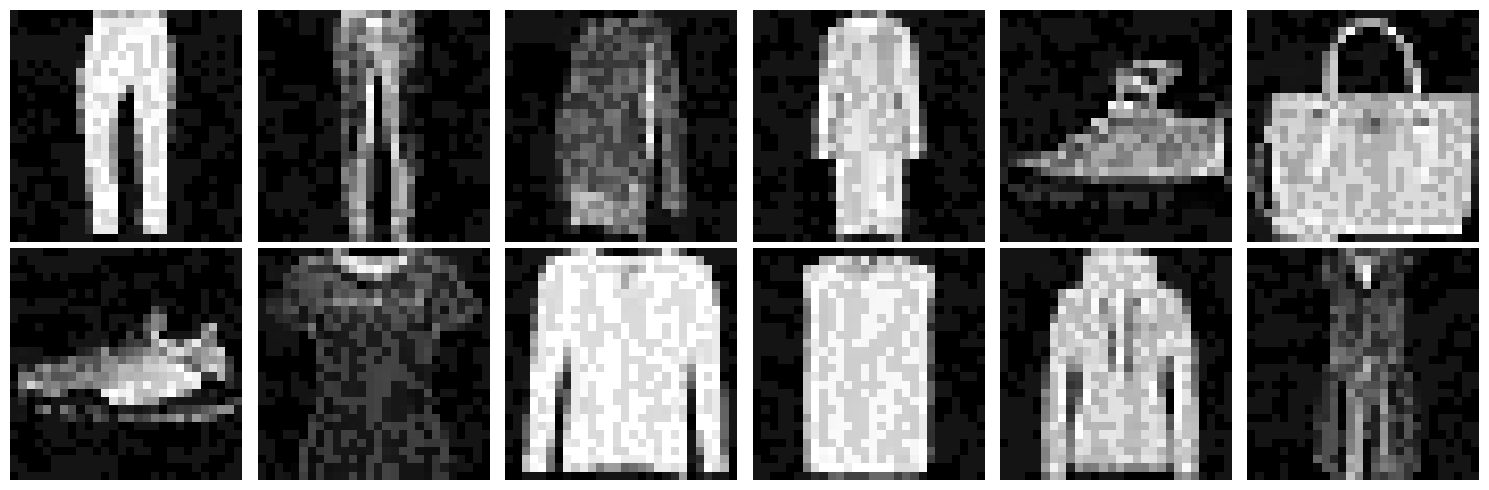

Attack Epsilon: 0.08; Whitebox Accuracy: 0.3589; Blackbox Accuracy: 0.5584
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


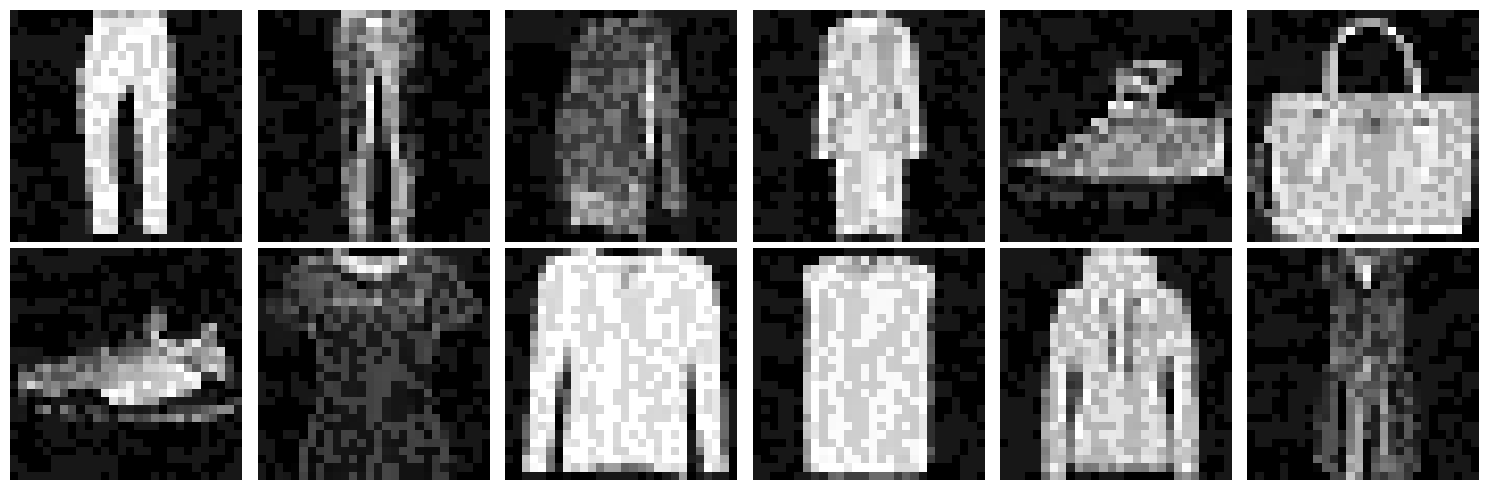

Attack Epsilon: 0.09; Whitebox Accuracy: 0.3427; Blackbox Accuracy: 0.529
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


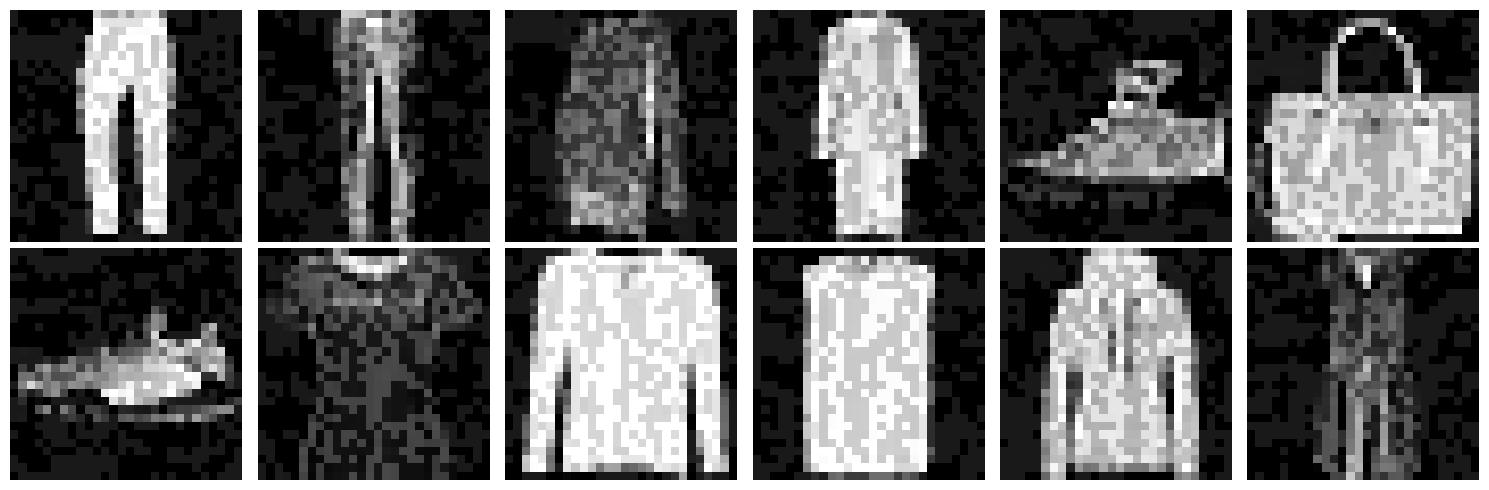

Attack Epsilon: 0.1; Whitebox Accuracy: 0.3291; Blackbox Accuracy: 0.4963
Done!


In [7]:
epsilons = np.linspace(0, 0.1, 11)
fgsm_whitebox_accuracies = []
fgsm_blackbox_accuracies = []

for eps in epsilons:

    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
    blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 1
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS, iters = ATK_ITERS)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # add to accuracies
    fgsm_whitebox_accuracies.append(whitebox_acc)
    fgsm_blackbox_accuracies.append(blackbox_acc)

    print("Done!")

rFGSM:

Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


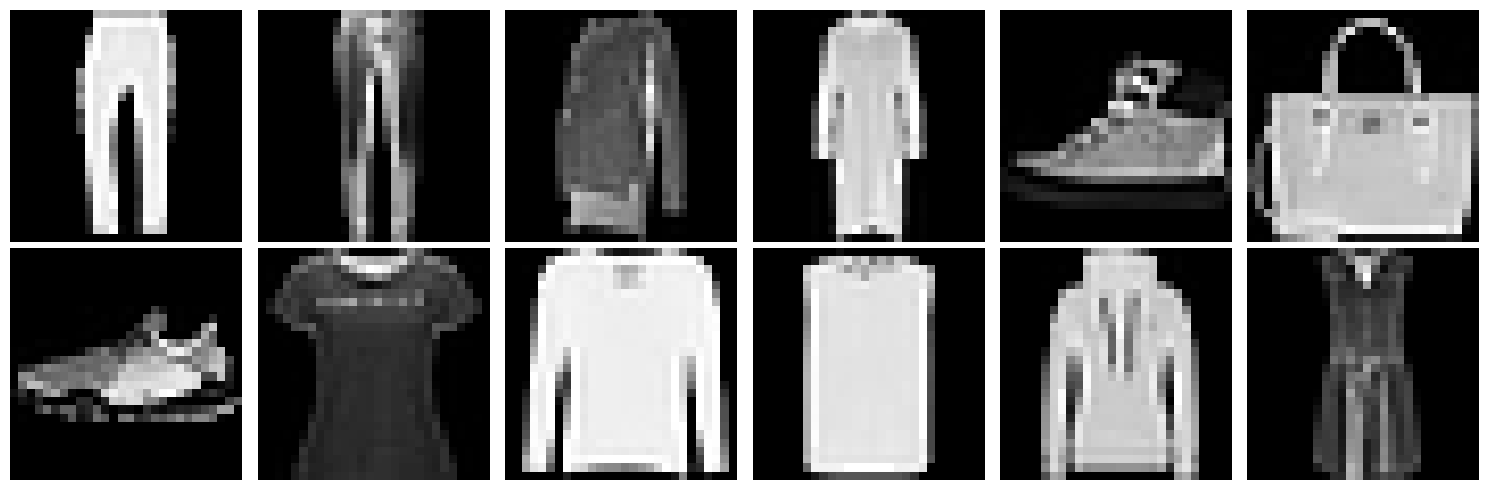

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9239; Blackbox Accuracy: 0.9284
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


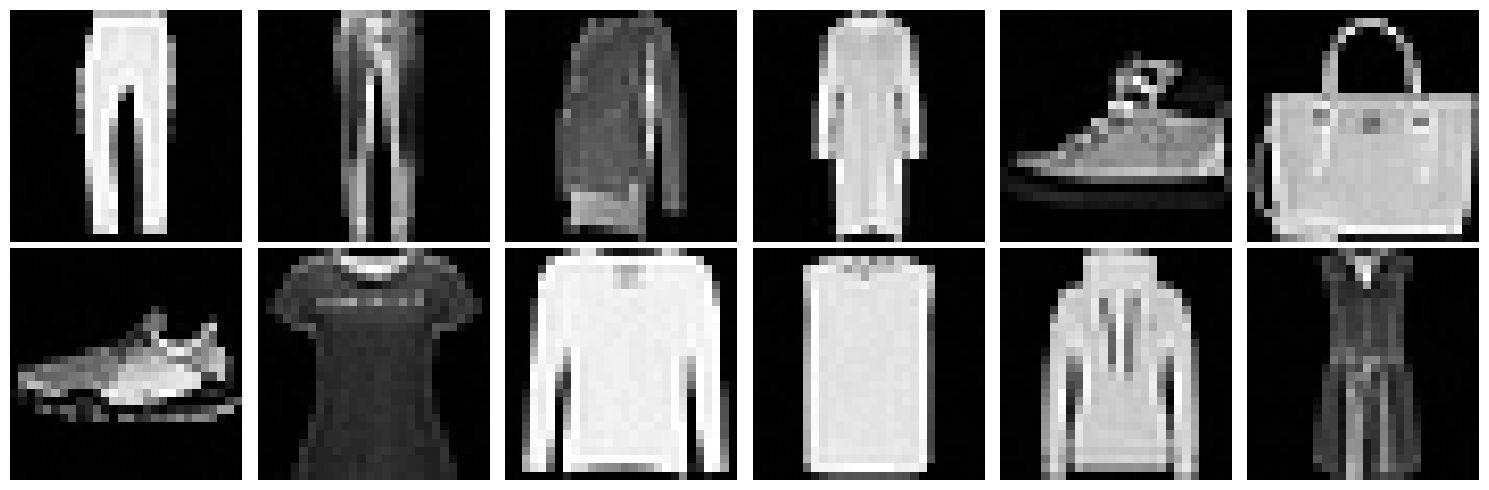

Attack Epsilon: 0.01; Whitebox Accuracy: 0.7463; Blackbox Accuracy: 0.897
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


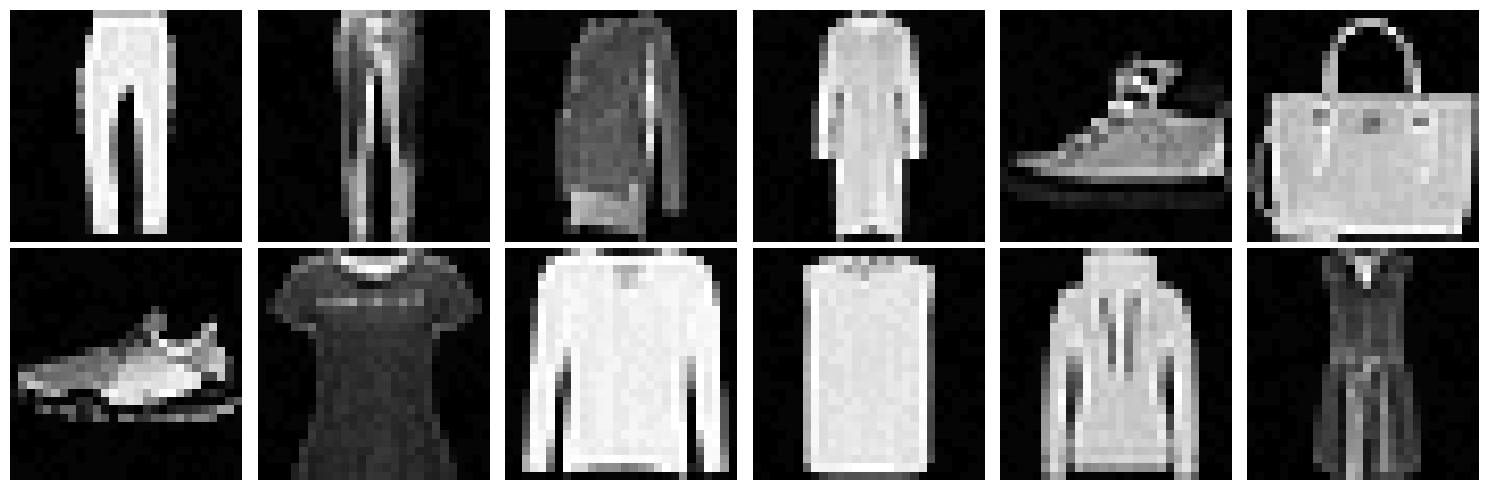

Attack Epsilon: 0.02; Whitebox Accuracy: 0.596; Blackbox Accuracy: 0.8565
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


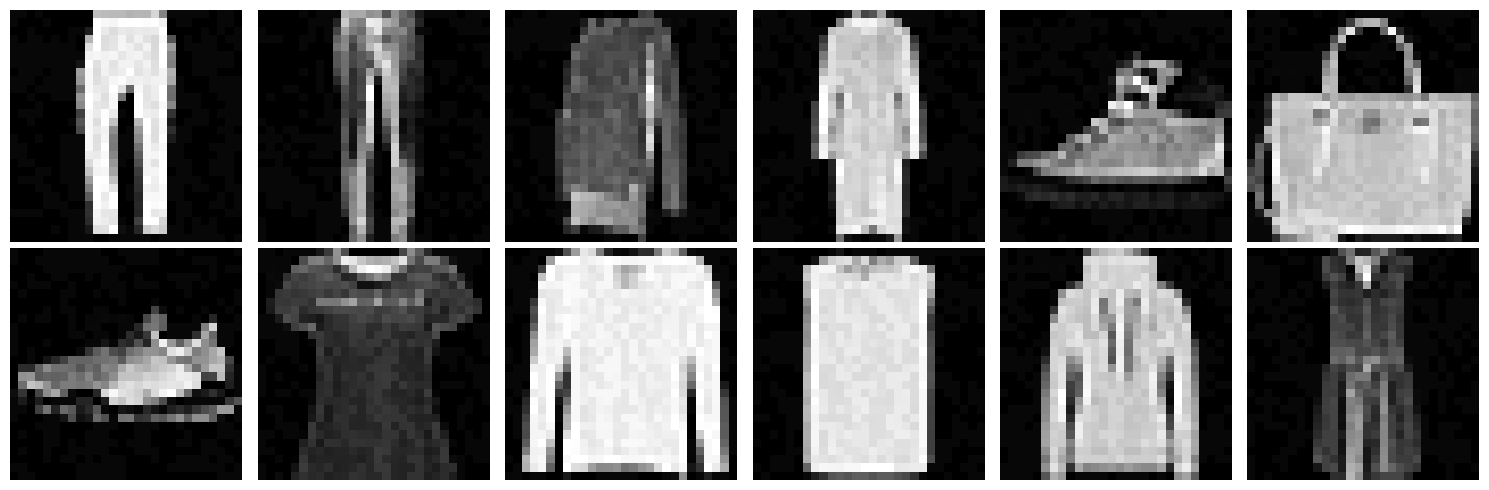

Attack Epsilon: 0.03; Whitebox Accuracy: 0.5283; Blackbox Accuracy: 0.8078
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


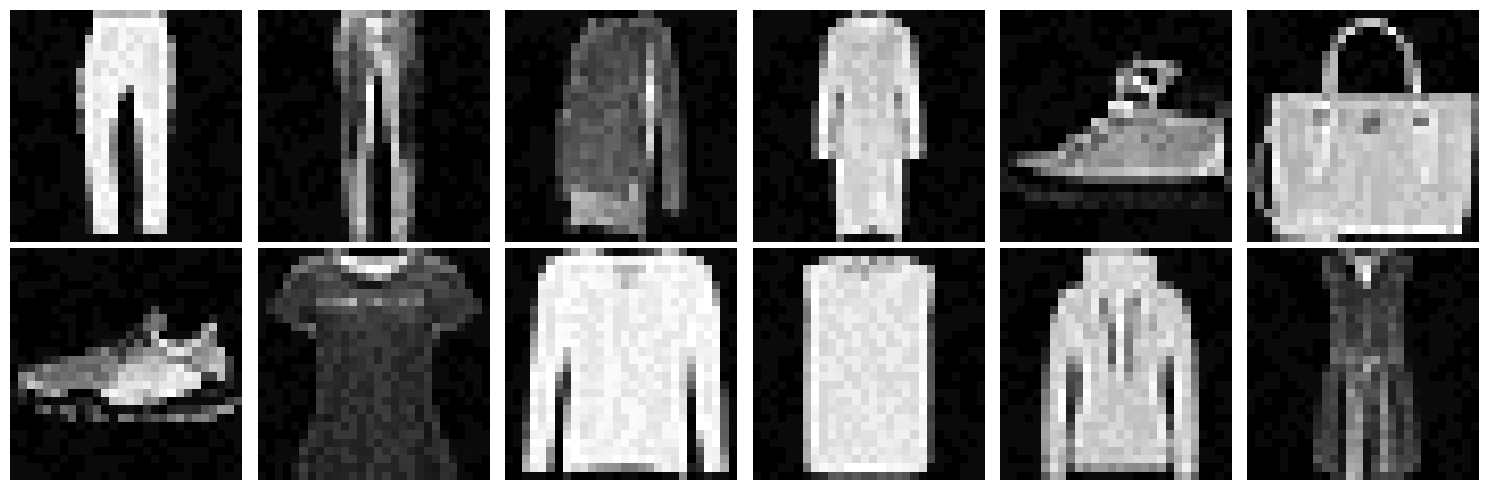

Attack Epsilon: 0.04; Whitebox Accuracy: 0.4794; Blackbox Accuracy: 0.7557
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


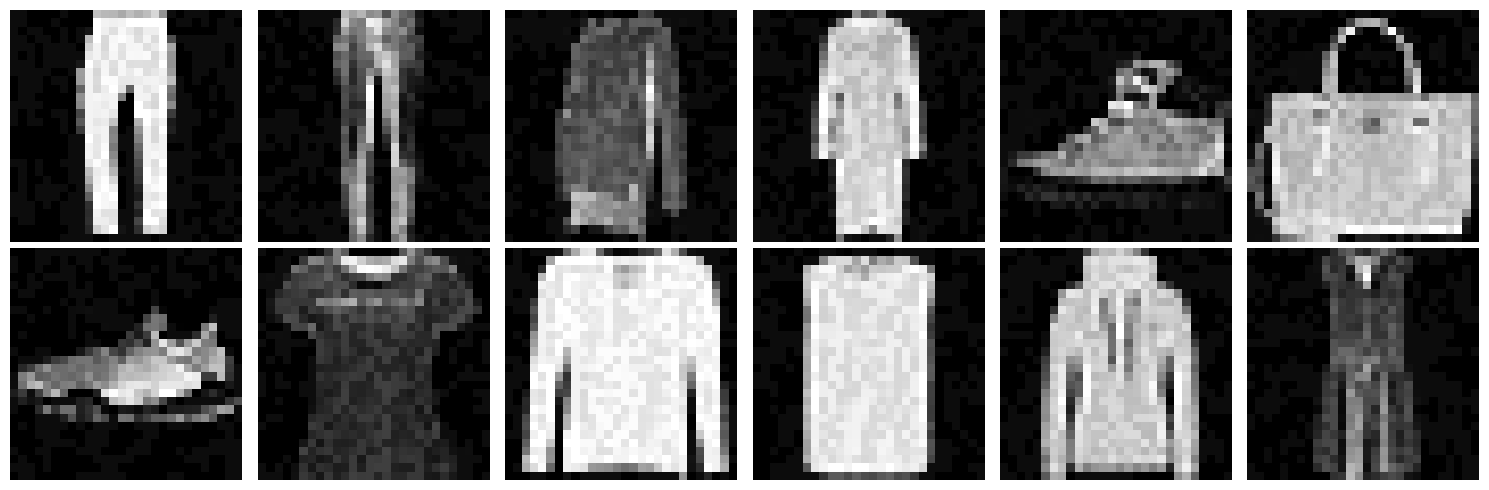

Attack Epsilon: 0.05; Whitebox Accuracy: 0.4347; Blackbox Accuracy: 0.7045
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


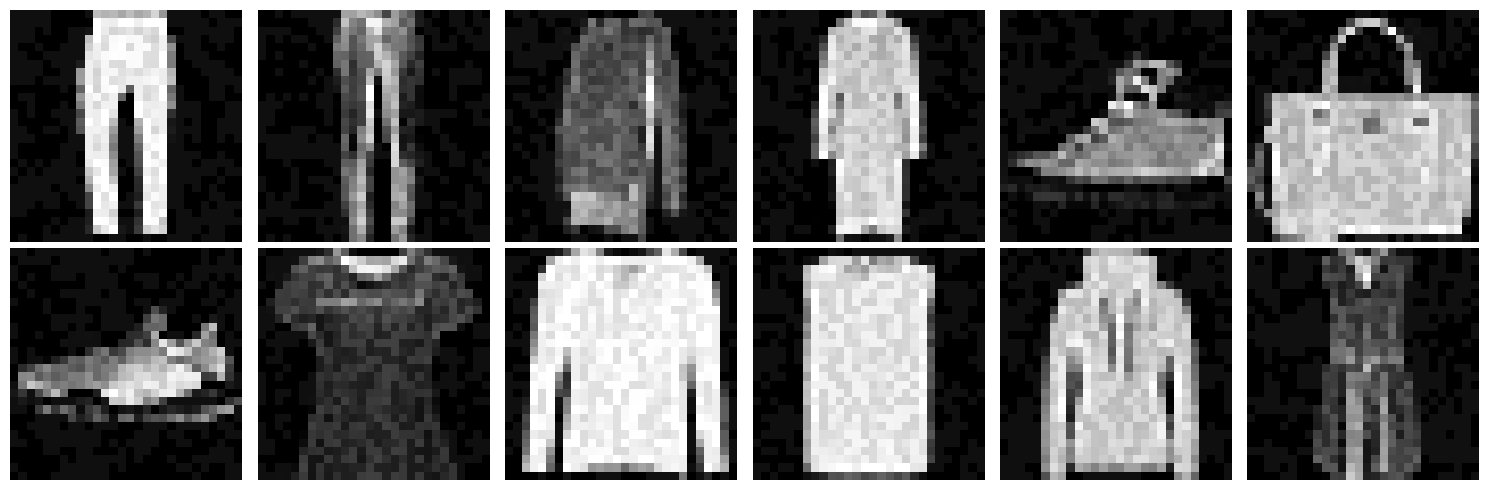

Attack Epsilon: 0.06; Whitebox Accuracy: 0.3982; Blackbox Accuracy: 0.6515
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


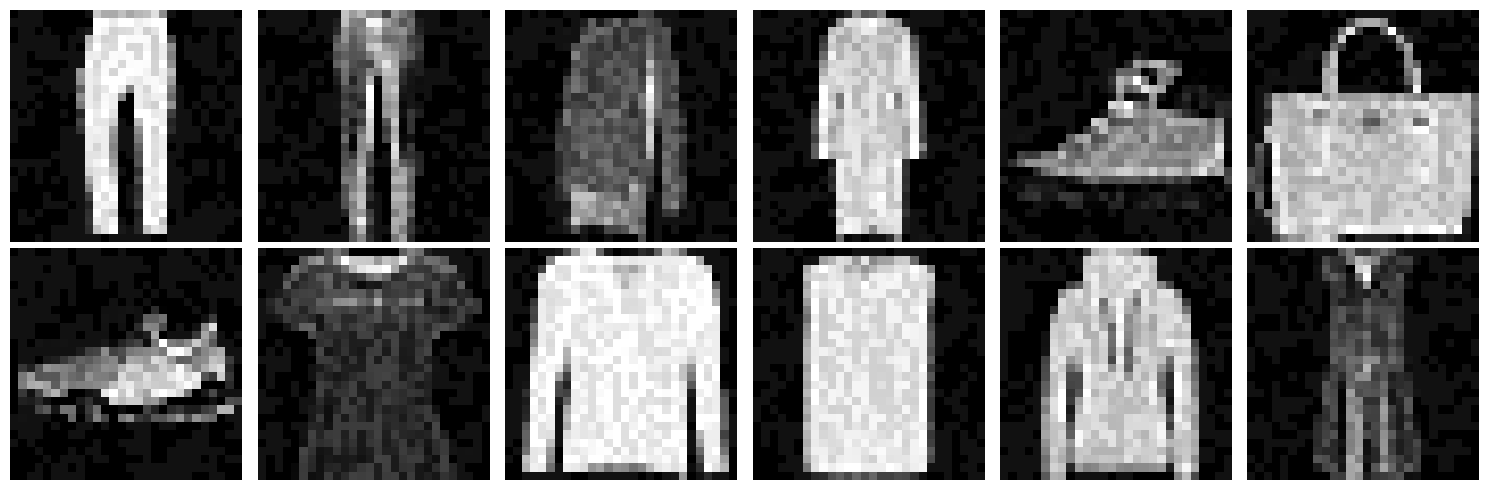

Attack Epsilon: 0.07; Whitebox Accuracy: 0.3631; Blackbox Accuracy: 0.6104
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


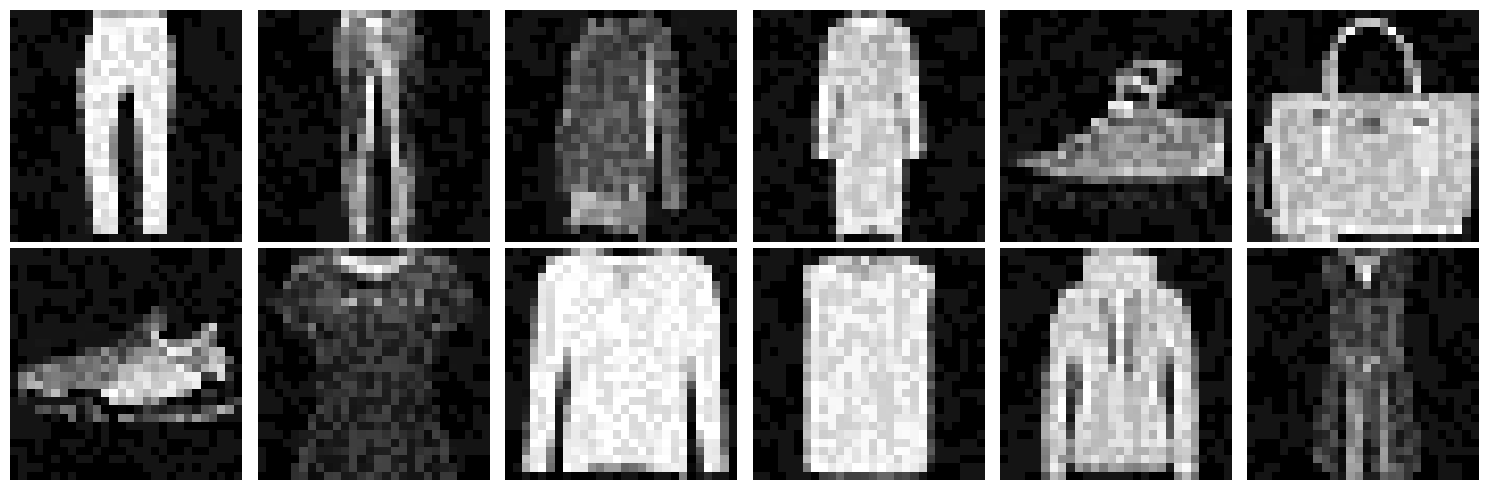

Attack Epsilon: 0.08; Whitebox Accuracy: 0.3346; Blackbox Accuracy: 0.5668
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


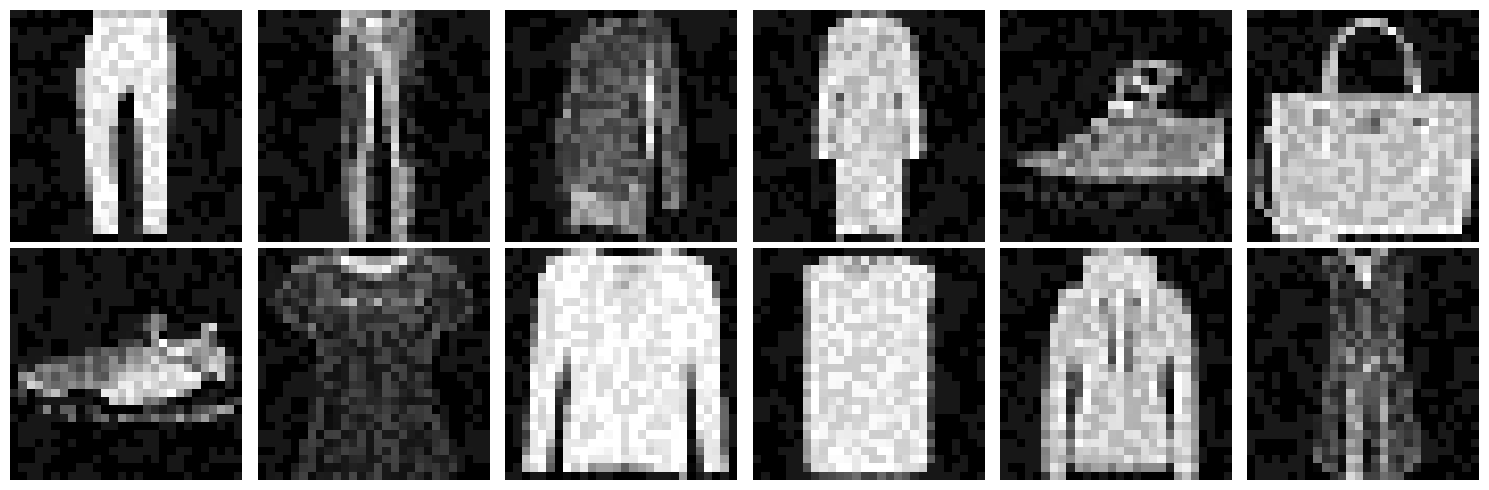

Attack Epsilon: 0.09; Whitebox Accuracy: 0.3004; Blackbox Accuracy: 0.5254
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


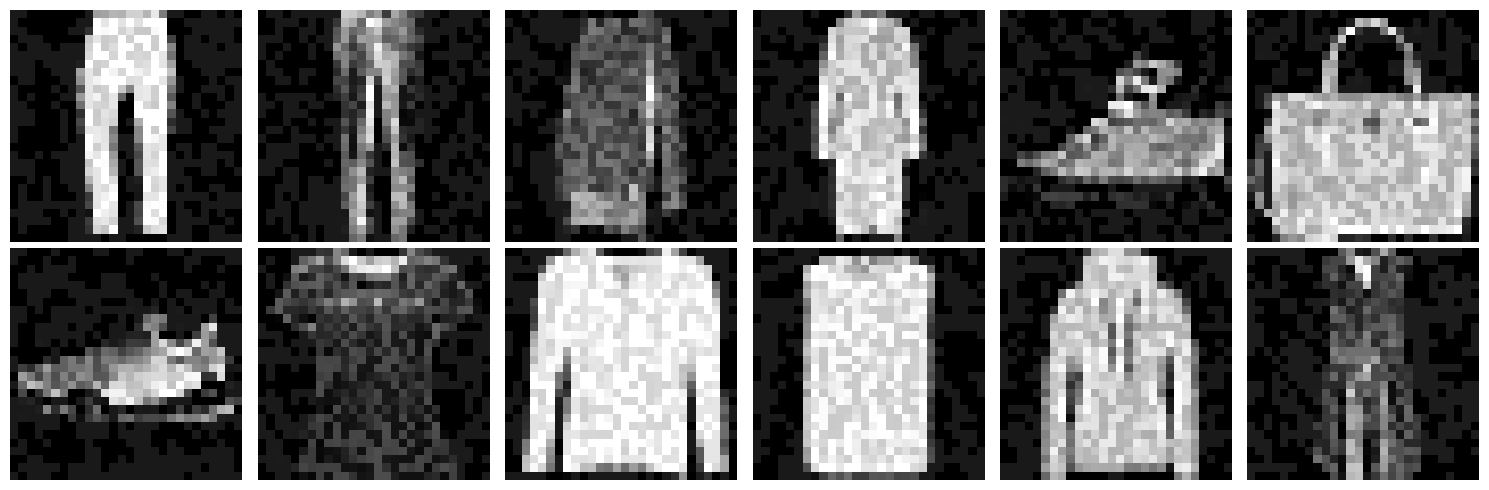

Attack Epsilon: 0.1; Whitebox Accuracy: 0.2735; Blackbox Accuracy: 0.4934
Done!


In [8]:
epsilons = np.linspace(0, 0.1, 11)
rfgsm_whitebox_accuracies = []
rfgsm_blackbox_accuracies = []

for eps in epsilons:

    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
    blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 1
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, ATK_EPS, iters = ATK_ITERS)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # add to accuracies
    rfgsm_whitebox_accuracies.append(whitebox_acc)
    rfgsm_blackbox_accuracies.append(blackbox_acc)

    print("Done!")

PGD

Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


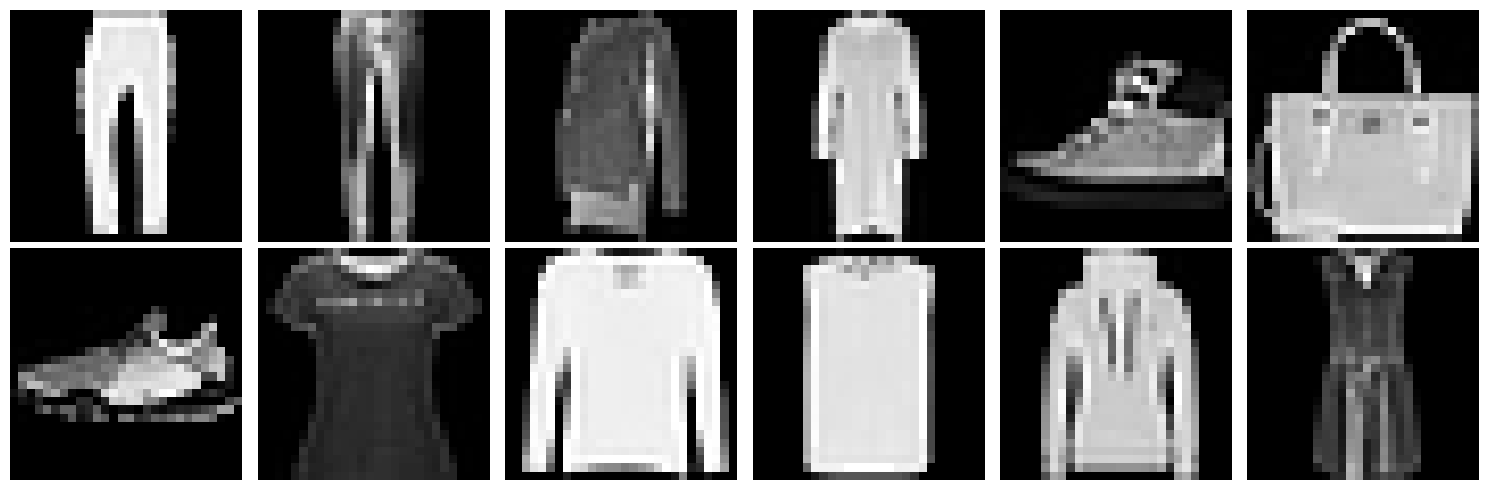

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9239; Blackbox Accuracy: 0.9284
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


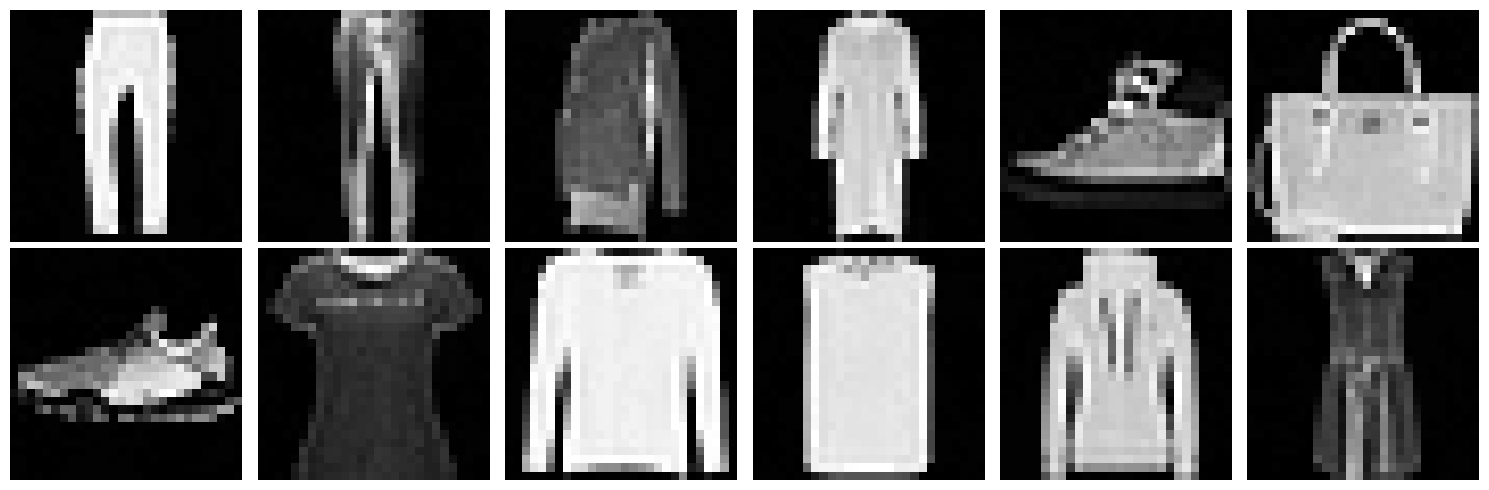

Attack Epsilon: 0.01; Whitebox Accuracy: 0.6514; Blackbox Accuracy: 0.8863
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


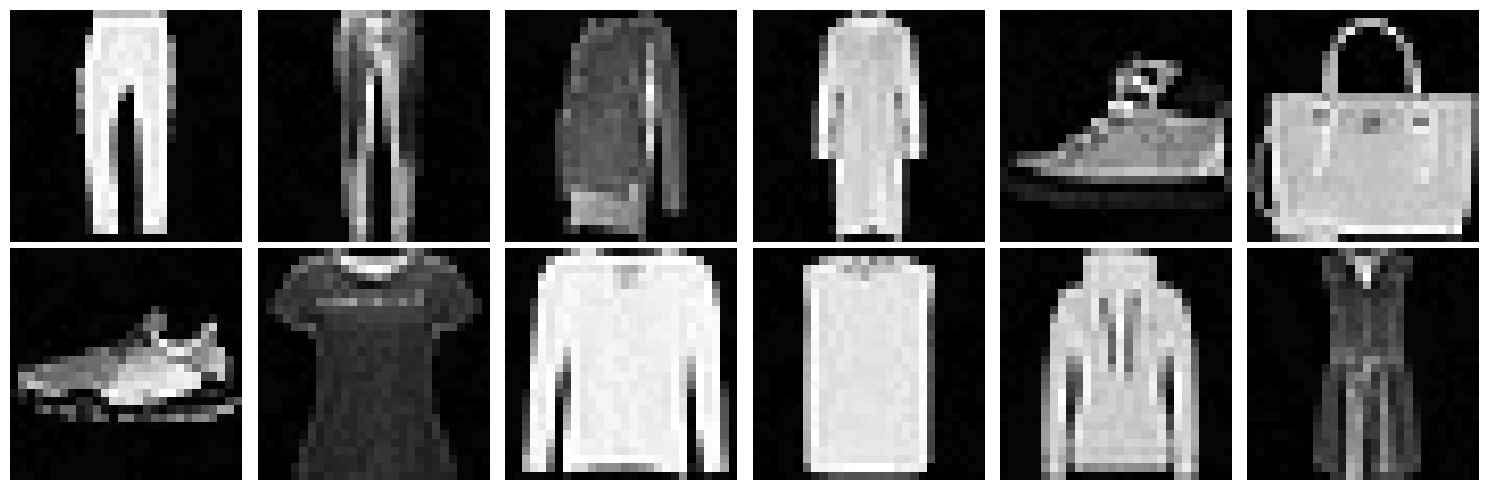

Attack Epsilon: 0.02; Whitebox Accuracy: 0.4237; Blackbox Accuracy: 0.8258
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


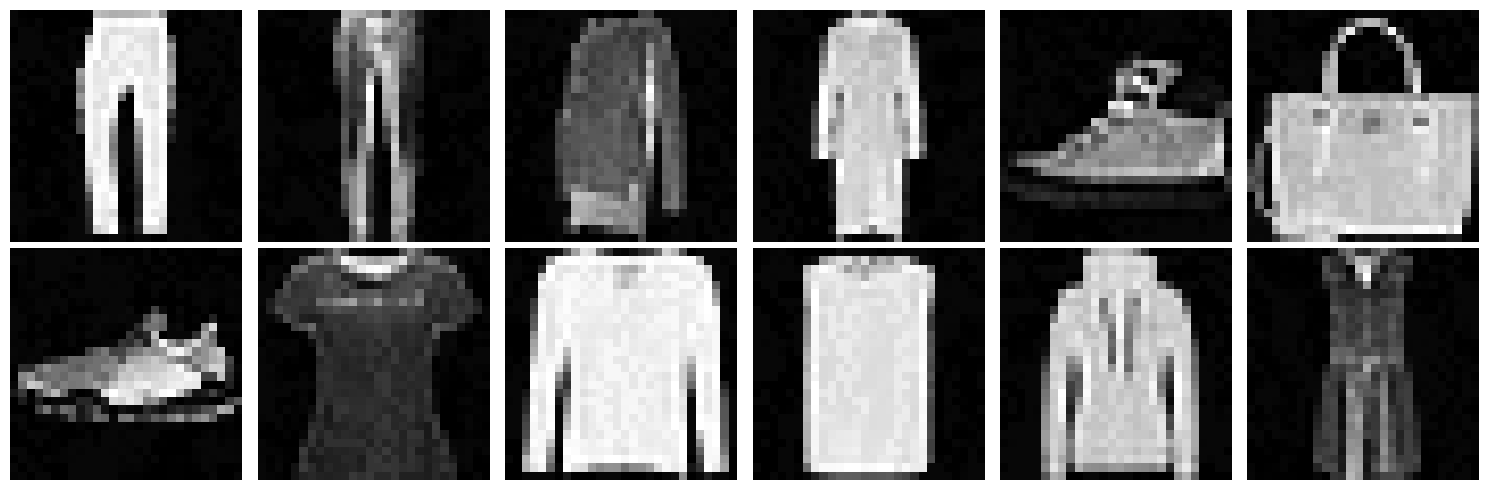

Attack Epsilon: 0.03; Whitebox Accuracy: 0.2819; Blackbox Accuracy: 0.7663
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


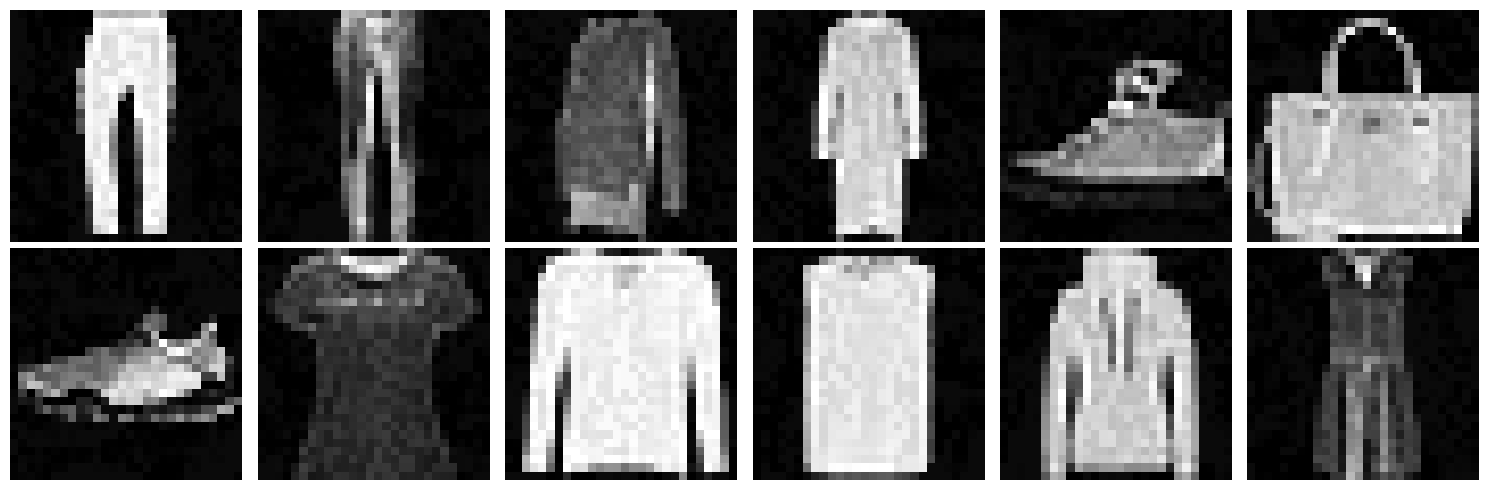

Attack Epsilon: 0.04; Whitebox Accuracy: 0.1824; Blackbox Accuracy: 0.6985
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


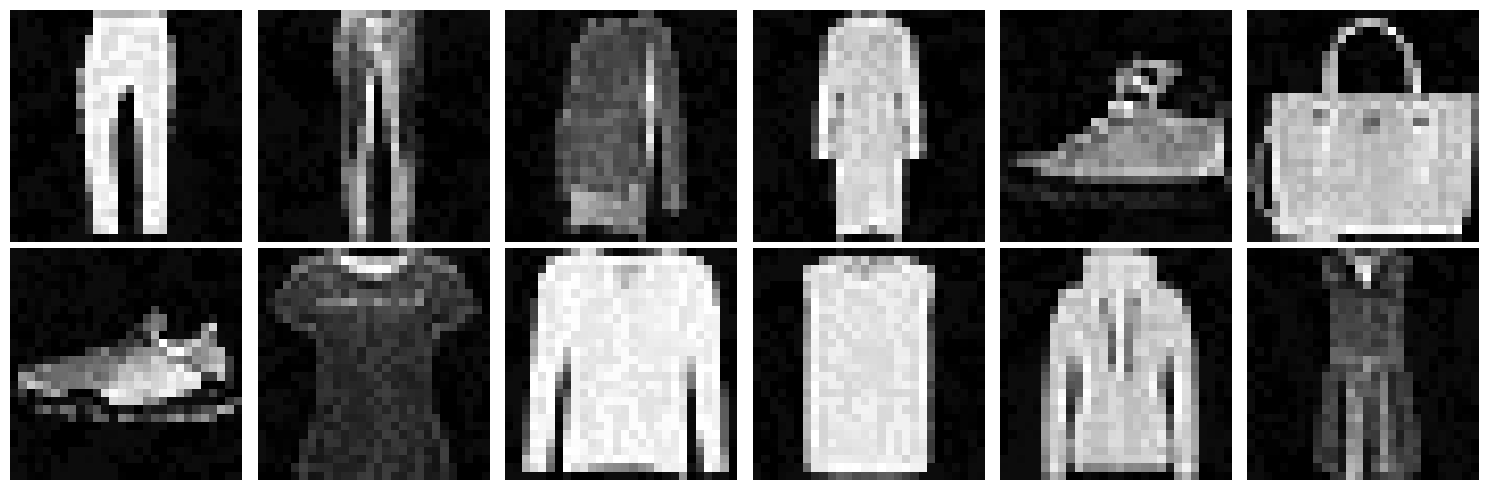

Attack Epsilon: 0.05; Whitebox Accuracy: 0.1068; Blackbox Accuracy: 0.6337
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


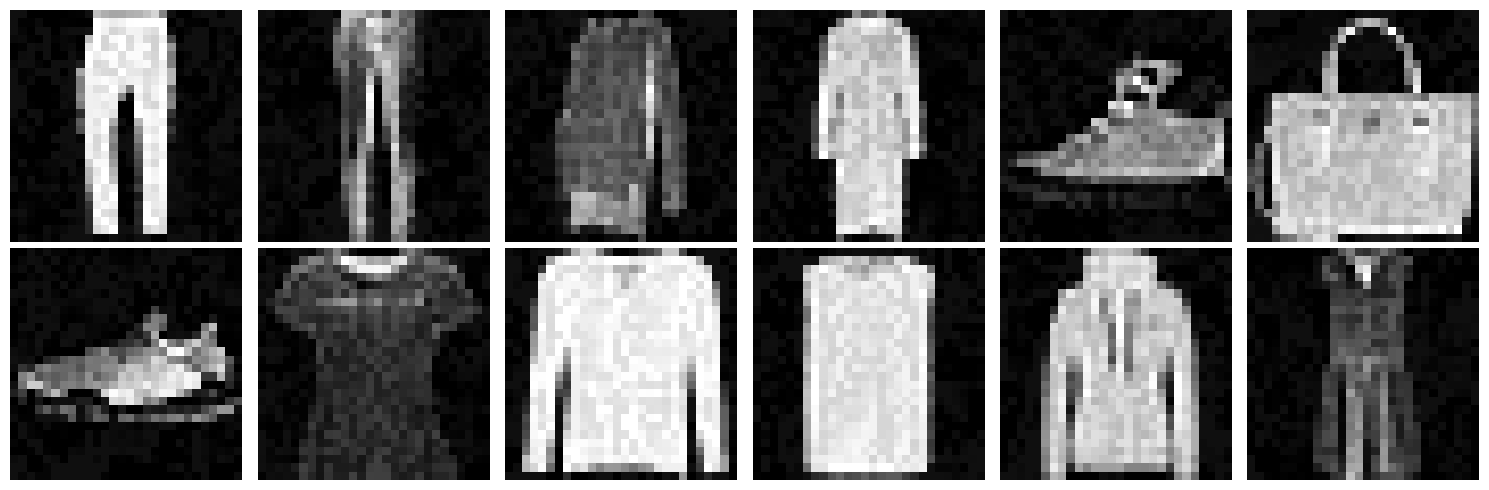

Attack Epsilon: 0.06; Whitebox Accuracy: 0.0607; Blackbox Accuracy: 0.5612
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


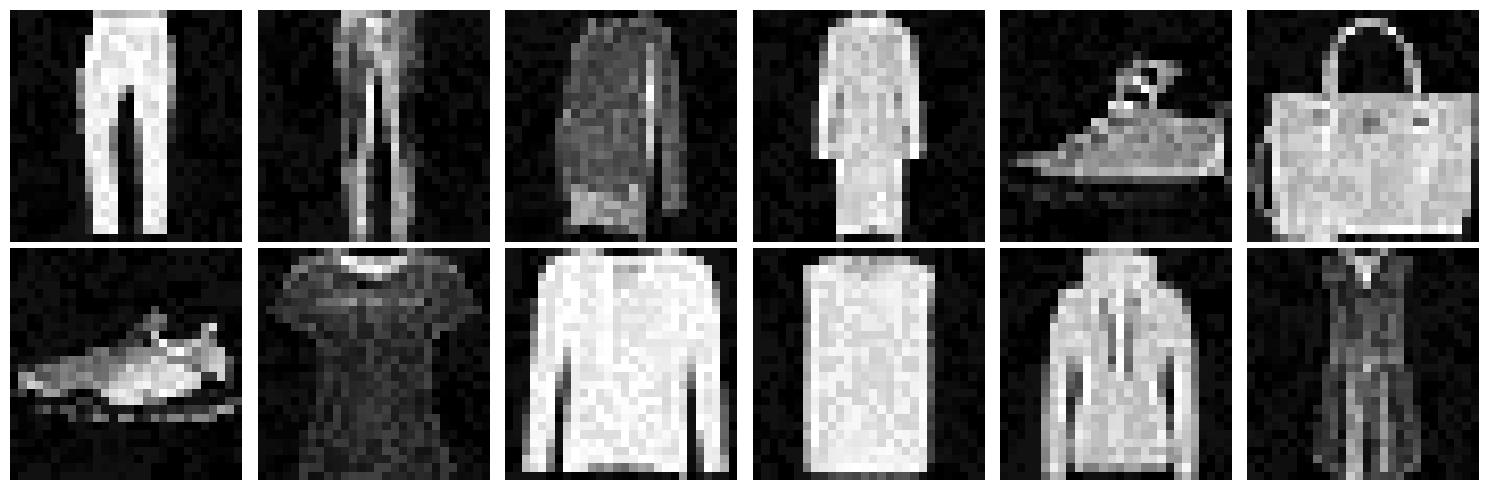

Attack Epsilon: 0.07; Whitebox Accuracy: 0.0316; Blackbox Accuracy: 0.5019
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


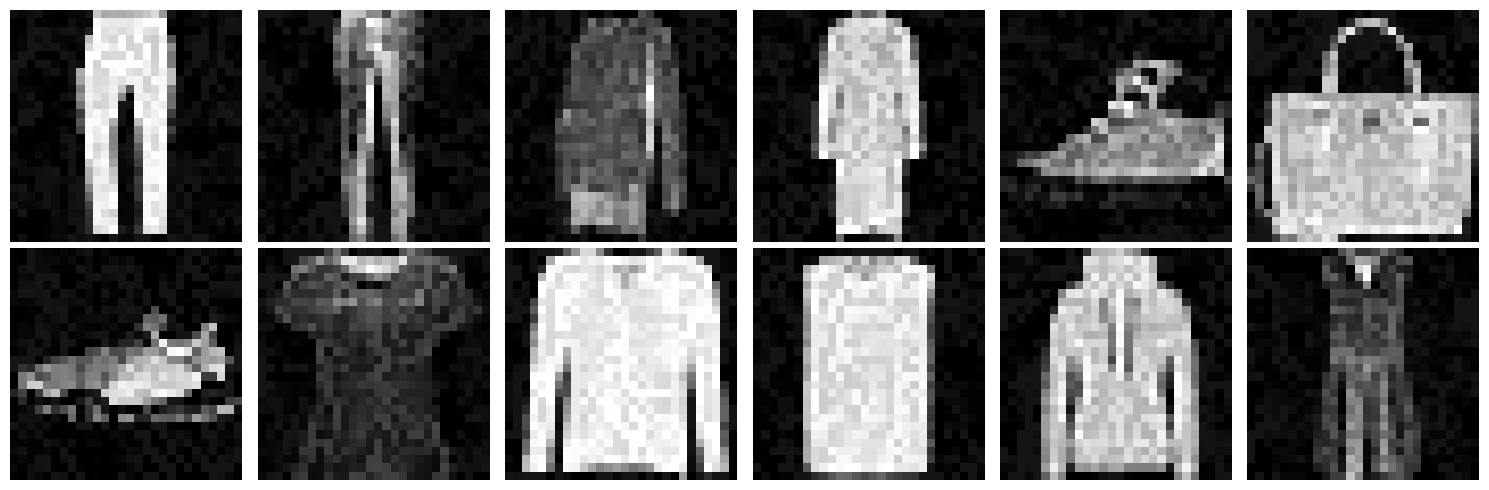

Attack Epsilon: 0.08; Whitebox Accuracy: 0.0199; Blackbox Accuracy: 0.4549
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


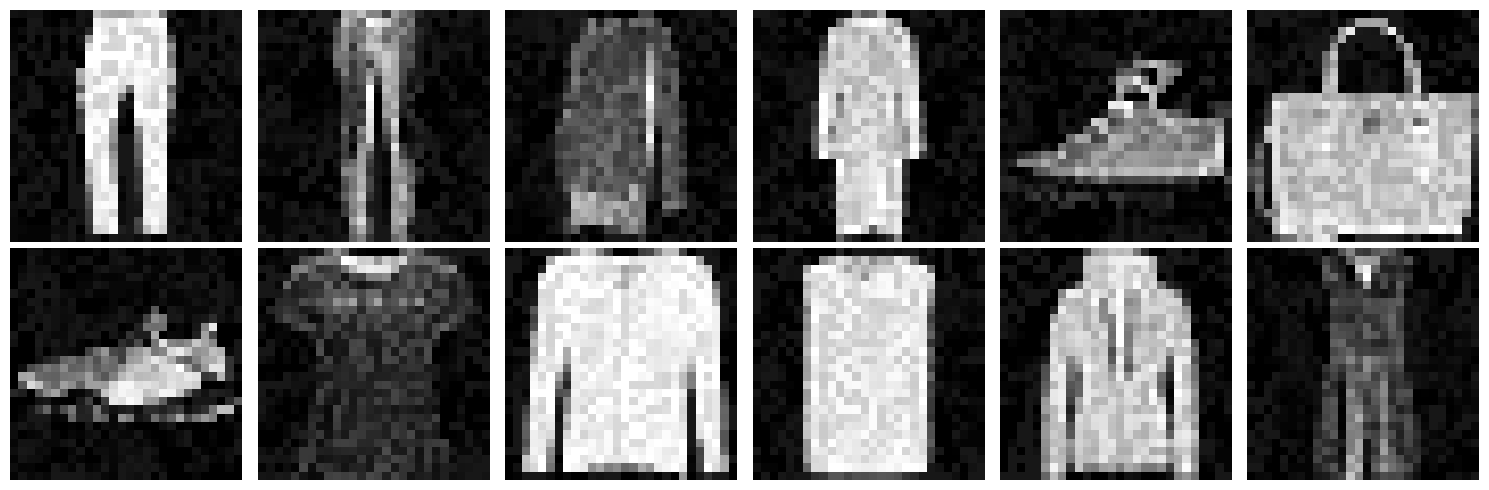

Attack Epsilon: 0.09; Whitebox Accuracy: 0.0114; Blackbox Accuracy: 0.4046
Done!
Initial Accuracy of Whitebox Model:  0.9239
Initial Accuracy of Blackbox Model:  0.9284


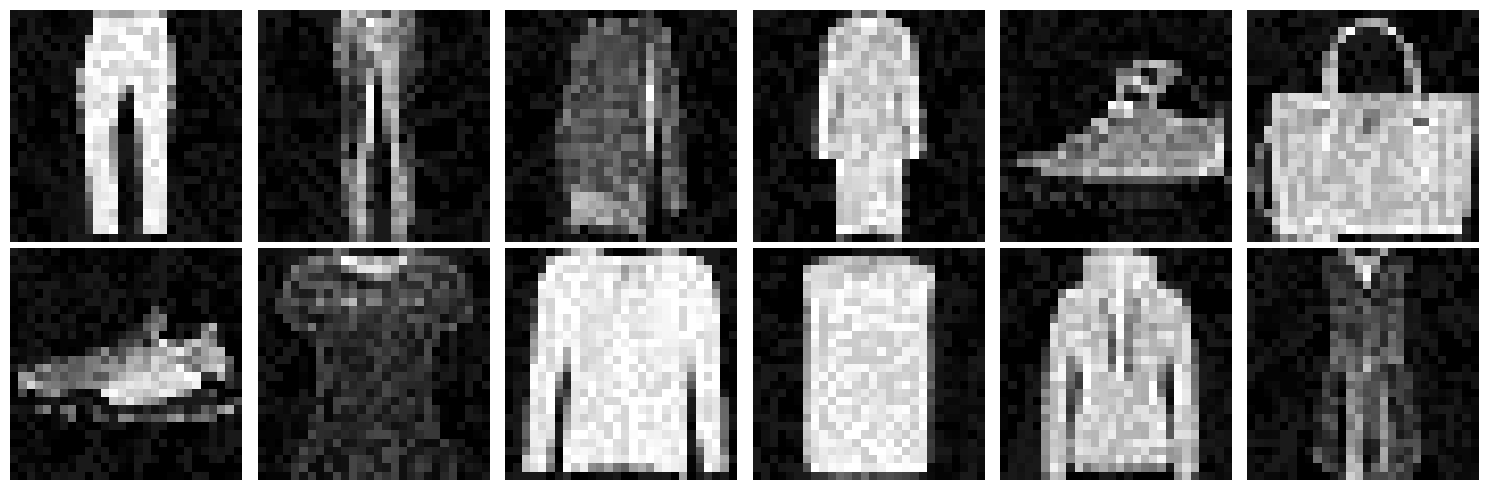

Attack Epsilon: 0.1; Whitebox Accuracy: 0.0092; Blackbox Accuracy: 0.3624
Done!


In [9]:
epsilons = np.linspace(0, 0.1, 11)
pgd_whitebox_accuracies = []
pgd_blackbox_accuracies = []

for eps in epsilons:

    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
    blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        adv_data = attacks.PGD_attack(whitebox, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
        
        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    # add to accuracies
    pgd_whitebox_accuracies.append(whitebox_acc)
    pgd_blackbox_accuracies.append(blackbox_acc)

    print("Done!")

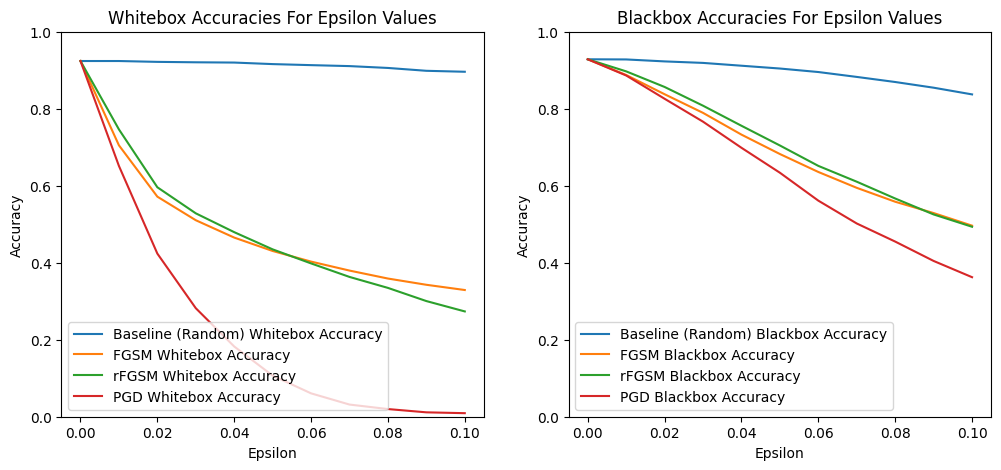

In [10]:
whitebox_accuracies = [random_whitebox_accuracies, fgsm_whitebox_accuracies, rfgsm_whitebox_accuracies, pgd_whitebox_accuracies]
blackbox_accuracies = [random_blackbox_accuracies, fgsm_blackbox_accuracies, rfgsm_blackbox_accuracies, pgd_blackbox_accuracies]

plot_accuracy_curves(whitebox_accuracies, blackbox_accuracies)

## Lab 3

a)

Adversarially trained FGSM model:

In [6]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_fgsm0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

fgsm_train_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.1
        ATK_ITERS = 1
        adv_data = attacks.FGSM_attack(net, device, data, labels, ATK_EPS, ATK_ITERS)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    fgsm_train_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.66402; TrainLoss: 0.82654; TestAcc: 0.80540; TestLoss: 0.48146
Epoch: [ 1 / 20 ]; TrainAcc: 0.74922; TrainLoss: 0.62026; TestAcc: 0.75660; TestLoss: 0.67129
Epoch: [ 2 / 20 ]; TrainAcc: 0.92790; TrainLoss: 0.20395; TestAcc: 0.71940; TestLoss: 1.15451
Epoch: [ 3 / 20 ]; TrainAcc: 0.97473; TrainLoss: 0.08076; TestAcc: 0.69020; TestLoss: 1.40397
Epoch: [ 4 / 20 ]; TrainAcc: 0.97415; TrainLoss: 0.08170; TestAcc: 0.71260; TestLoss: 0.87550
Epoch: [ 5 / 20 ]; TrainAcc: 0.94550; TrainLoss: 0.15724; TestAcc: 0.61080; TestLoss: 2.34122
Epoch: [ 6 / 20 ]; TrainAcc: 0.92673; TrainLoss: 0.20052; TestAcc: 0.54150; TestLoss: 3.40280
Epoch: [ 7 / 20 ]; TrainAcc: 0.94633; TrainLoss: 0.15084; TestAcc: 0.55180; TestLoss: 2.93524
Epoch: [ 8 / 20 ]; TrainAcc: 0.93687; TrainLoss: 0.17203; TestAcc: 0.46620; TestLoss: 3.98496
Epoch: [ 9 / 20 ]; TrainAcc: 0.93247; TrainLoss: 0.18323; TestAcc: 0.44840; TestLoss: 4.33423
Epoch: [ 10 / 20 ]; TrainAcc: 0.93288; TrainLoss: 0.17587; T

rFGSM attack:

In [7]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_rfgsm0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

rfgsm_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.1
        ATK_ITERS = 1
        adv_data = attacks.rFGSM_attack(net, device, data, labels, ATK_EPS, ATK_ITERS)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    rfgsm_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.68777; TrainLoss: 0.77385; TestAcc: 0.82880; TestLoss: 0.45668
Epoch: [ 1 / 20 ]; TrainAcc: 0.75348; TrainLoss: 0.61202; TestAcc: 0.84420; TestLoss: 0.41438
Epoch: [ 2 / 20 ]; TrainAcc: 0.77287; TrainLoss: 0.56154; TestAcc: 0.85300; TestLoss: 0.38207
Epoch: [ 3 / 20 ]; TrainAcc: 0.79010; TrainLoss: 0.52621; TestAcc: 0.86020; TestLoss: 0.36654
Epoch: [ 4 / 20 ]; TrainAcc: 0.79792; TrainLoss: 0.50015; TestAcc: 0.85520; TestLoss: 0.37090
Epoch: [ 5 / 20 ]; TrainAcc: 0.80702; TrainLoss: 0.47795; TestAcc: 0.86190; TestLoss: 0.35449
Epoch: [ 6 / 20 ]; TrainAcc: 0.81302; TrainLoss: 0.46260; TestAcc: 0.86700; TestLoss: 0.34549
Epoch: [ 7 / 20 ]; TrainAcc: 0.81605; TrainLoss: 0.45031; TestAcc: 0.86350; TestLoss: 0.34870
Epoch: [ 8 / 20 ]; TrainAcc: 0.82063; TrainLoss: 0.44217; TestAcc: 0.87380; TestLoss: 0.33821
Epoch: [ 9 / 20 ]; TrainAcc: 0.82508; TrainLoss: 0.43150; TestAcc: 0.87620; TestLoss: 0.33158
Epoch: [ 10 / 20 ]; TrainAcc: 0.82717; TrainLoss: 0.42441; T

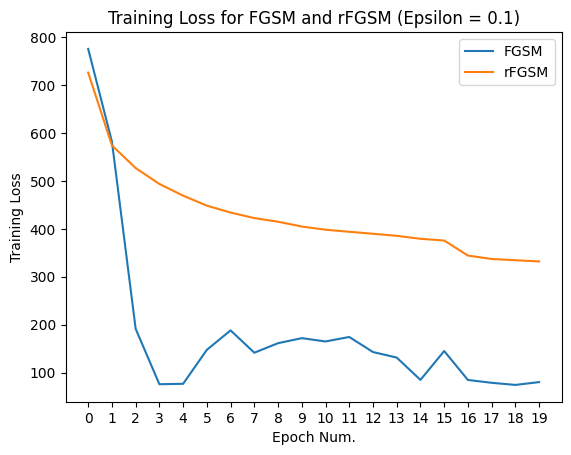

In [8]:
plt.plot(fgsm_train_losses, label = 'FGSM')
plt.plot(rfgsm_losses, label = 'rFGSM')
plt.xlabel("Epoch Num.")
plt.ylabel("Training Loss")
plt.title("Training Loss for FGSM and rFGSM (Epsilon = 0.1)") 
plt.xticks(np.arange(0, 20, step=1))  # Set label locations.
plt.legend()
plt.show()

b)

In [9]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.1
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)
        adv_data = attacks.PGD_attack(net, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    pgd_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.64592; TrainLoss: 0.87410; TestAcc: 0.78210; TestLoss: 0.51848
Epoch: [ 1 / 20 ]; TrainAcc: 0.71157; TrainLoss: 0.70547; TestAcc: 0.82940; TestLoss: 0.45956
Epoch: [ 2 / 20 ]; TrainAcc: 0.73952; TrainLoss: 0.64057; TestAcc: 0.83790; TestLoss: 0.43934
Epoch: [ 3 / 20 ]; TrainAcc: 0.75643; TrainLoss: 0.59928; TestAcc: 0.84540; TestLoss: 0.40630
Epoch: [ 4 / 20 ]; TrainAcc: 0.76947; TrainLoss: 0.56932; TestAcc: 0.84640; TestLoss: 0.39890
Epoch: [ 5 / 20 ]; TrainAcc: 0.77777; TrainLoss: 0.54975; TestAcc: 0.84670; TestLoss: 0.38582
Epoch: [ 6 / 20 ]; TrainAcc: 0.78383; TrainLoss: 0.53549; TestAcc: 0.85490; TestLoss: 0.38195
Epoch: [ 7 / 20 ]; TrainAcc: 0.78595; TrainLoss: 0.52469; TestAcc: 0.85530; TestLoss: 0.37692
Epoch: [ 8 / 20 ]; TrainAcc: 0.78878; TrainLoss: 0.51905; TestAcc: 0.85860; TestLoss: 0.37168
Epoch: [ 9 / 20 ]; TrainAcc: 0.79078; TrainLoss: 0.51281; TestAcc: 0.85860; TestLoss: 0.36874
Epoch: [ 10 / 20 ]; TrainAcc: 0.79492; TrainLoss: 0.50492; T

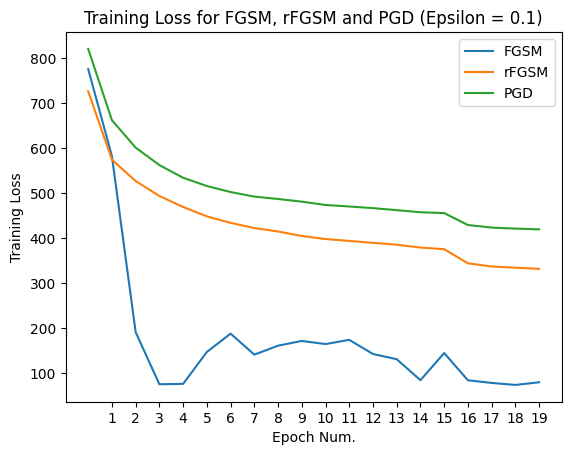

In [10]:
plt.plot(fgsm_train_losses, label = 'FGSM')
plt.plot(rfgsm_losses, label = 'rFGSM')
plt.plot(pgd_losses, label = 'PGD')
plt.xlabel("Epoch Num.")
plt.ylabel("Training Loss")
plt.title("Training Loss for FGSM, rFGSM and PGD (Epsilon = 0.1)")
plt.xticks(np.arange(1, 20, step=1))  # Set label locations.
plt.legend()
plt.show()

c)

In [10]:
def calc_accuracies(model_name, attack_type, atk_iters = 10, atk_alpha_coef = 1.85, epsilons = np.linspace(0, 0.14, 8)):
    """Helper function to calculate accuracies per each attack"""
    accuracies = []

    for eps in epsilons:

        whitebox = models.NetA()
        whitebox.load_state_dict(torch.load(model_name)) # TODO: Load your robust models
        whitebox = whitebox.to(device)
        whitebox.eval(); 

        test_acc,_ = test_model(whitebox,test_loader,device)
        print("Initial Accuracy of Whitebox Model: ",test_acc)

        ## Test the model against an adversarial attack

        # TODO: Set attack parameters here
        ATK_EPS = eps
        ATK_ITERS = atk_iters
        ATK_ALPHA = atk_alpha_coef * (ATK_EPS / ATK_ITERS)

        whitebox_correct = 0.
        running_total = 0.
        for batch_idx,(data,labels) in enumerate(test_loader):
            data = data.to(device) 
            labels = labels.to(device)

            # TODO: Perform adversarial attack here
            if attack_type == "FGSM":
                adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS, iters = 1)
            elif attack_type == "rFGSM":
                adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, ATK_EPS, iters = 1)
            else:
                adv_data = attacks.PGD_attack(whitebox, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)
            
            # Sanity checking if adversarial example is "legal"
            assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
            assert(adv_data.max() == 1.)
            assert(adv_data.min() == 0.)
            
            # Compute accuracy on perturbed data
            with torch.no_grad():
                whitebox_outputs = whitebox(adv_data)
                _,whitebox_preds = whitebox_outputs.max(1)
                whitebox_correct += whitebox_preds.eq(labels).sum().item()
                running_total += labels.size(0)
            
            # Plot some samples
            # if batch_idx == 1:
            #     plt.figure(figsize=(15,5))
            #     for jj in range(12):
            #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            #     plt.tight_layout()
            #     plt.show()

        # Print final 
        whitebox_acc = whitebox_correct/running_total
        print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))
        accuracies.append(whitebox_acc)

    return accuracies

In [23]:
def plot_adversarial_accuracy_curves(fgsm_accuracies, rfgsm_accuracies, pgd_accuracies, epsilons = np.linspace(0, 0.14, 8), attacks = ['FGSM', 'rFGSM', 'PGD'], pgd = False):
    """Helper function to plot accuracy vs. epsilon figures"""
    fig, ax = plt.subplots(1, len(fgsm_accuracies), figsize = (6 * len(fgsm_accuracies), 5))

    training_epsilons = [0.05, 0.15, 0.2]

    for i in range(len(fgsm_accuracies)):
        if pgd:
            ax[i].plot(epsilons, fgsm_accuracies[i], label = f'{attacks[0]} Whitebox Accuracy')
            ax[i].plot(epsilons, rfgsm_accuracies[i], label = f'{attacks[1]} Whitebox Accuracy', linestyle = '--')
            ax[i].plot(epsilons, pgd_accuracies[i], label = f'{attacks[2]} Whitebox Accuracy')
            ax[i].set_title(f"Whitebox Accuracies For Adversarially \nTrained with PGD (Epsilon = {training_epsilons[i]})")
            ax[i].set_xlabel("Epsilon")
            ax[i].set_ylabel("Accuracy")
            ax[i].legend()
            ax[i].set_ylim(bottom=0)
        else:
            ax[i].plot(epsilons, fgsm_accuracies[i], label = f'{attacks[0]} Whitebox Accuracy')
            ax[i].plot(epsilons, rfgsm_accuracies[i], label = f'{attacks[1]} Whitebox Accuracy', linestyle = '--')
            ax[i].plot(epsilons, pgd_accuracies[i], label = f'{attacks[2]} Whitebox Accuracy')
            ax[i].set_title(f"Whitebox Accuracies For Adversarially \nTrained with {attacks[i]} vs. Epsilon Values")
            ax[i].set_xlabel("Epsilon")
            ax[i].set_ylabel("Accuracy")
            ax[i].legend()
            ax[i].set_ylim(bottom=0)
    fig.show()

`fgsm0p1.pt` model - FGSM attack

In [12]:
fgsm0p1_fgsm_accuracies = calc_accuracies("netA_advtrain_fgsm0p1.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.0; Whitebox Accuracy: 0.4883
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.02; Whitebox Accuracy: 0.6033
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.04; Whitebox Accuracy: 0.7863
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.06; Whitebox Accuracy: 0.9365
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.08; Whitebox Accuracy: 0.9544
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.1; Whitebox Accuracy: 0.9609
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.12; Whitebox Accuracy: 0.949
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.14; Whitebox Accuracy: 0.8878


`fgsm0p1.pt` model - rFGSM attack

In [13]:
fgsm0p1_rfgsm_accuracies = calc_accuracies("netA_advtrain_fgsm0p1.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.0; Whitebox Accuracy: 0.4883
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.02; Whitebox Accuracy: 0.3395
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.04; Whitebox Accuracy: 0.2366
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.06; Whitebox Accuracy: 0.1393
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.08; Whitebox Accuracy: 0.1092
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.1; Whitebox Accuracy: 0.1004
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.12; Whitebox Accuracy: 0.105
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.14; Whitebox Accuracy: 0.1263


`fgsm0p1.pt` model - PGD attack

In [14]:
fgsm0p1_PGD_accuracies = calc_accuracies("netA_advtrain_fgsm0p1.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.0; Whitebox Accuracy: 0.4883
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.02; Whitebox Accuracy: 0.2932
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.04; Whitebox Accuracy: 0.0942
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.06; Whitebox Accuracy: 0.0615
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.08; Whitebox Accuracy: 0.0461
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.1; Whitebox Accuracy: 0.0277
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.12; Whitebox Accuracy: 0.0136
Initial Accuracy of Whitebox Model:  0.4883
Attack Epsilon: 0.14; Whitebox Accuracy: 0.0065


`rfgsm0p1.pt` model - FGSM attack

In [15]:
rfgsm0p1_fgsm_accuracies = calc_accuracies("netA_advtrain_rfgsm0p1.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8872
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.02; Whitebox Accuracy: 0.867
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8469
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8308
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8168
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8035
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7614
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.14; Whitebox Accuracy: 0.572


`rfgsm0p1.pt` model - rFGSM attack

In [16]:
rfgsm0p1_rfgsm_accuracies = calc_accuracies("netA_advtrain_rfgsm0p1.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8872
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8729
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8571
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8436
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8296
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8183
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7523
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.14; Whitebox Accuracy: 0.5248


`rfgsm0p1.pt` model - PGD attack

In [17]:
rfgsm0p1_PGD_accuracies = calc_accuracies("netA_advtrain_rfgsm0p1.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8872
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8639
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8375
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8101
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.08; Whitebox Accuracy: 0.7845
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7492


Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.12; Whitebox Accuracy: 0.4679
Initial Accuracy of Whitebox Model:  0.8872
Attack Epsilon: 0.14; Whitebox Accuracy: 0.1833


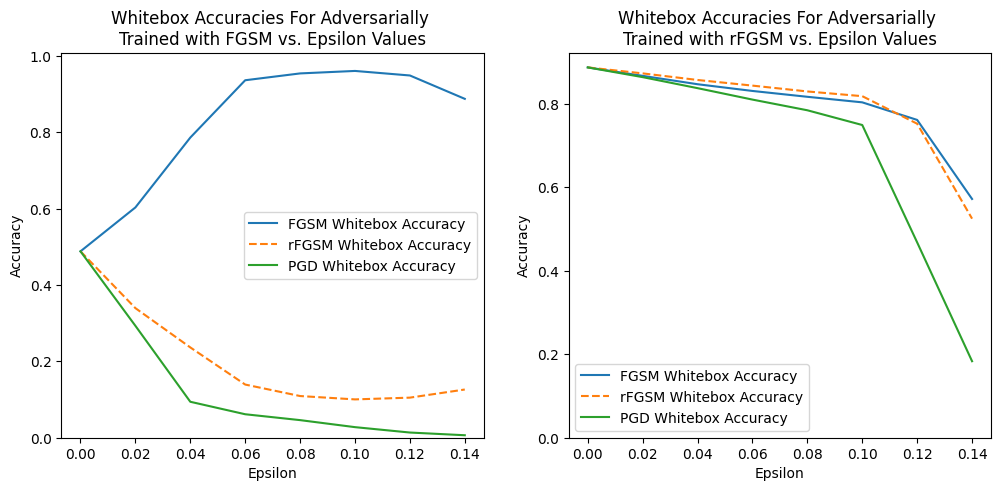

In [18]:
fgsm_accuracies = [fgsm0p1_fgsm_accuracies, rfgsm0p1_fgsm_accuracies]
rfgsm_accuracies = [fgsm0p1_rfgsm_accuracies, rfgsm0p1_rfgsm_accuracies]
pgd_accuracies = [fgsm0p1_PGD_accuracies, rfgsm0p1_PGD_accuracies]
plot_adversarial_accuracy_curves(fgsm_accuracies, rfgsm_accuracies, pgd_accuracies)

d)

In [19]:
pgd0p1_fgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.0; Whitebox Accuracy: 0.869
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8542
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8414
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8298
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8192
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8083
Initial Accuracy of Whitebox Model:  0.869


Attack Epsilon: 0.12; Whitebox Accuracy: 0.8022
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7585


In [20]:
pgd0p1_rfgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.0; Whitebox Accuracy: 0.869
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8581
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.04; Whitebox Accuracy: 0.848
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8384


Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8295
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8223
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7898
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6047


In [21]:
pgd0p1_pgd_accuracies = calc_accuracies("netA_advtrain_pgd0p1.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.869


Attack Epsilon: 0.0; Whitebox Accuracy: 0.869
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.02; Whitebox Accuracy: 0.854
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.04; Whitebox Accuracy: 0.837
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8208
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8039
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7869
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6565
Initial Accuracy of Whitebox Model:  0.869
Attack Epsilon: 0.14; Whitebox Accuracy: 0.2872


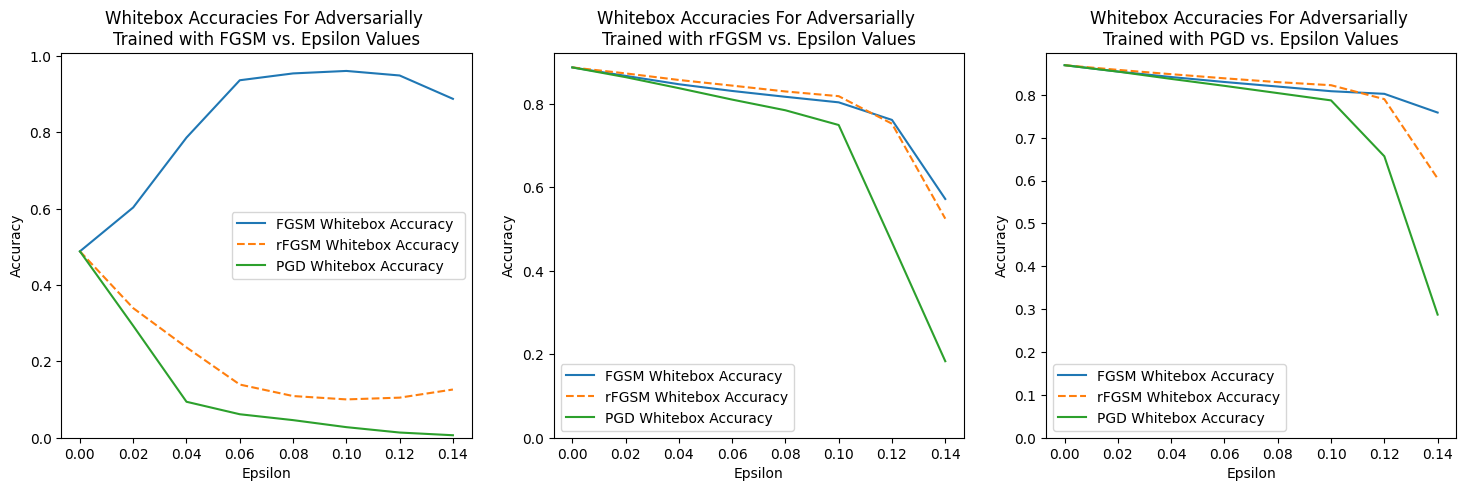

In [22]:
fgsm_accuracies = [fgsm0p1_fgsm_accuracies, rfgsm0p1_fgsm_accuracies, pgd0p1_fgsm_accuracies]
rfgsm_accuracies = [fgsm0p1_rfgsm_accuracies, rfgsm0p1_rfgsm_accuracies, pgd0p1_rfgsm_accuracies]
pgd_accuracies = [fgsm0p1_PGD_accuracies, rfgsm0p1_PGD_accuracies, pgd0p1_pgd_accuracies]
plot_adversarial_accuracy_curves(fgsm_accuracies, rfgsm_accuracies, pgd_accuracies)

e)

In [6]:
# test with epsilon = 0.05
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_005.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.05
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)
        adv_data = attacks.PGD_attack(net, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    pgd_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.72787; TrainLoss: 0.68535; TestAcc: 0.83410; TestLoss: 0.42522
Epoch: [ 1 / 20 ]; TrainAcc: 0.78623; TrainLoss: 0.53854; TestAcc: 0.86260; TestLoss: 0.36444
Epoch: [ 2 / 20 ]; TrainAcc: 0.79808; TrainLoss: 0.50134; TestAcc: 0.85710; TestLoss: 0.36767
Epoch: [ 3 / 20 ]; TrainAcc: 0.80652; TrainLoss: 0.47883; TestAcc: 0.86960; TestLoss: 0.34742
Epoch: [ 4 / 20 ]; TrainAcc: 0.81555; TrainLoss: 0.45793; TestAcc: 0.86190; TestLoss: 0.36244
Epoch: [ 5 / 20 ]; TrainAcc: 0.82215; TrainLoss: 0.43958; TestAcc: 0.87910; TestLoss: 0.31904
Epoch: [ 6 / 20 ]; TrainAcc: 0.82735; TrainLoss: 0.42727; TestAcc: 0.88060; TestLoss: 0.31572
Epoch: [ 7 / 20 ]; TrainAcc: 0.83225; TrainLoss: 0.41862; TestAcc: 0.87930; TestLoss: 0.31511
Epoch: [ 8 / 20 ]; TrainAcc: 0.83370; TrainLoss: 0.40881; TestAcc: 0.88360; TestLoss: 0.30556
Epoch: [ 9 / 20 ]; TrainAcc: 0.83747; TrainLoss: 0.40003; TestAcc: 0.88000; TestLoss: 0.32071
Epoch: [ 10 / 20 ]; TrainAcc: 0.84023; TrainLoss: 0.39388; T

In [7]:
# test with epsilon = 0.15
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_015.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.15
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)
        adv_data = attacks.PGD_attack(net, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    pgd_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.56688; TrainLoss: 1.07240; TestAcc: 0.77440; TestLoss: 0.59389
Epoch: [ 1 / 20 ]; TrainAcc: 0.65242; TrainLoss: 0.84856; TestAcc: 0.78870; TestLoss: 0.54486
Epoch: [ 2 / 20 ]; TrainAcc: 0.69645; TrainLoss: 0.73840; TestAcc: 0.82790; TestLoss: 0.48769
Epoch: [ 3 / 20 ]; TrainAcc: 0.72368; TrainLoss: 0.67808; TestAcc: 0.82490; TestLoss: 0.47275
Epoch: [ 4 / 20 ]; TrainAcc: 0.73680; TrainLoss: 0.64738; TestAcc: 0.82480; TestLoss: 0.46846
Epoch: [ 5 / 20 ]; TrainAcc: 0.74817; TrainLoss: 0.62441; TestAcc: 0.83160; TestLoss: 0.44481
Epoch: [ 6 / 20 ]; TrainAcc: 0.75603; TrainLoss: 0.60693; TestAcc: 0.83540; TestLoss: 0.43574
Epoch: [ 7 / 20 ]; TrainAcc: 0.76122; TrainLoss: 0.59339; TestAcc: 0.83930; TestLoss: 0.42754
Epoch: [ 8 / 20 ]; TrainAcc: 0.76340; TrainLoss: 0.58165; TestAcc: 0.83810; TestLoss: 0.42020
Epoch: [ 9 / 20 ]; TrainAcc: 0.76697; TrainLoss: 0.57553; TestAcc: 0.83630; TestLoss: 0.42571
Epoch: [ 10 / 20 ]; TrainAcc: 0.77362; TrainLoss: 0.56409; T

In [8]:
# test with epsilon = 0.2
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_02.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # TODO: Perform adversarial attack here
        ATK_EPS = 0.2
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)
        adv_data = attacks.PGD_attack(net, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)
        
        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)

    pgd_losses.append(train_loss)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.48878; TrainLoss: 1.27398; TestAcc: 0.72450; TestLoss: 0.70294
Epoch: [ 1 / 20 ]; TrainAcc: 0.61328; TrainLoss: 0.93387; TestAcc: 0.76890; TestLoss: 0.57624
Epoch: [ 2 / 20 ]; TrainAcc: 0.67008; TrainLoss: 0.79634; TestAcc: 0.79430; TestLoss: 0.54168
Epoch: [ 3 / 20 ]; TrainAcc: 0.69885; TrainLoss: 0.72743; TestAcc: 0.78370; TestLoss: 0.53483
Epoch: [ 4 / 20 ]; TrainAcc: 0.71288; TrainLoss: 0.69125; TestAcc: 0.79250; TestLoss: 0.51215
Epoch: [ 5 / 20 ]; TrainAcc: 0.72497; TrainLoss: 0.66518; TestAcc: 0.80960; TestLoss: 0.48031
Epoch: [ 6 / 20 ]; TrainAcc: 0.73302; TrainLoss: 0.64323; TestAcc: 0.80730; TestLoss: 0.48080
Epoch: [ 7 / 20 ]; TrainAcc: 0.73843; TrainLoss: 0.63248; TestAcc: 0.81880; TestLoss: 0.48029
Epoch: [ 8 / 20 ]; TrainAcc: 0.74462; TrainLoss: 0.61349; TestAcc: 0.82600; TestLoss: 0.47244
Epoch: [ 9 / 20 ]; TrainAcc: 0.75250; TrainLoss: 0.60300; TestAcc: 0.82920; TestLoss: 0.45280
Epoch: [ 10 / 20 ]; TrainAcc: 0.75737; TrainLoss: 0.59059; T

In [12]:
pgd0p1_005_pgd_accuracies = calc_accuracies("netA_advtrain_pgd0p1_005.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8962
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8704
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8415
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8049
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.08; Whitebox Accuracy: 0.6868
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.1; Whitebox Accuracy: 0.5162
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.12; Whitebox Accuracy: 0.3073
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.14; Whitebox Accuracy: 0.162


In [13]:
pgd0p1_005_fgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_005.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8962
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8718
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8489
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8252
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.08; Whitebox Accuracy: 0.7983
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7635
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7159
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6267


In [14]:
pgd0p1_005_rfgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_005.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8962
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8781
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8597
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.06; Whitebox Accuracy: 0.841
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8012
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7335
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6395
Initial Accuracy of Whitebox Model:  0.8962
Attack Epsilon: 0.14; Whitebox Accuracy: 0.5


In [15]:
pgd0p1_015_pgd_accuracies = calc_accuracies("netA_advtrain_pgd0p1_015.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8508
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8337
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8201
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8107
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.08; Whitebox Accuracy: 0.801
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.1; Whitebox Accuracy: 0.79
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7831
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7733


In [16]:
pgd0p1_015_fgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_015.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8508
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8371
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8294
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8256
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8215
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8176
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8125
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.14; Whitebox Accuracy: 0.8086


In [17]:
pgd0p1_015_rfgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_015.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8508
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8399
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8344
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8303
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8257
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8228
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8206
Initial Accuracy of Whitebox Model:  0.8508
Attack Epsilon: 0.14; Whitebox Accuracy: 0.8198


In [18]:
pgd0p1_020_pgd_accuracies = calc_accuracies("netA_advtrain_pgd0p1_02.pt", "PGD")

Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8432
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8226
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8051
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.06; Whitebox Accuracy: 0.7929
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.08; Whitebox Accuracy: 0.7827
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7747
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7633
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7524


In [19]:
pgd0p1_020_fgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_02.pt", "FGSM")

Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8432
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.02; Whitebox Accuracy: 0.826
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8151
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.06; Whitebox Accuracy: 0.811
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.08; Whitebox Accuracy: 0.81
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8094
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8052
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7989


In [20]:
pgd0p1_020_rfgsm_accuracies = calc_accuracies("netA_advtrain_pgd0p1_02.pt", "rFGSM")

Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.0; Whitebox Accuracy: 0.8432
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8309
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8207
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8165
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8134
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8086
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8074
Initial Accuracy of Whitebox Model:  0.8432
Attack Epsilon: 0.14; Whitebox Accuracy: 0.8028


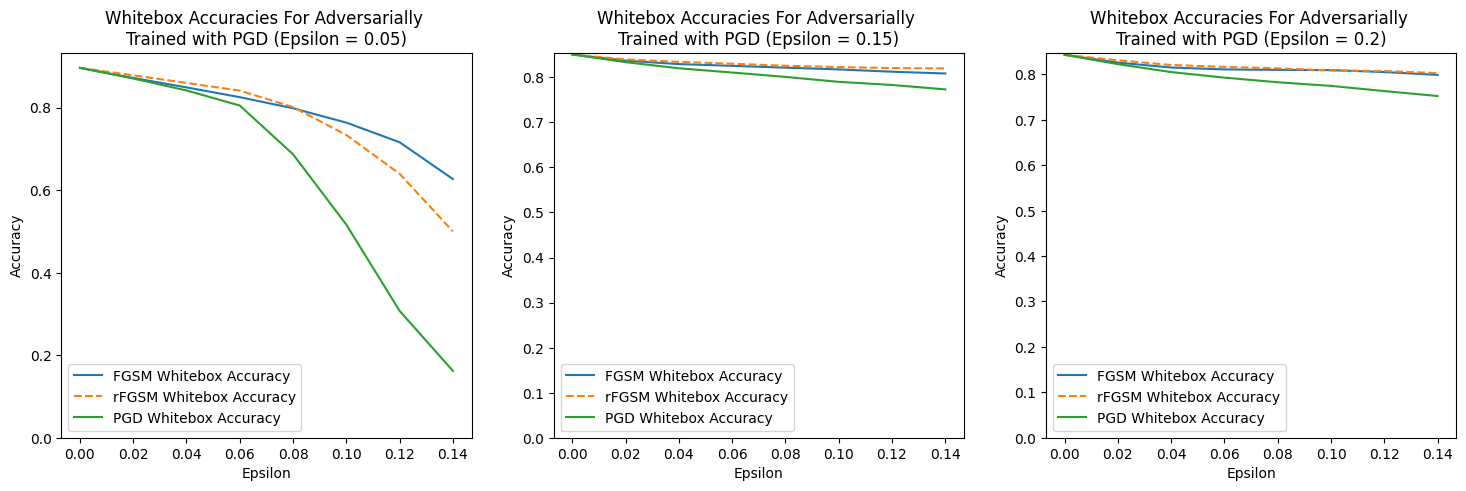

In [27]:
fgsm_accuracies = [pgd0p1_005_fgsm_accuracies, pgd0p1_015_fgsm_accuracies, pgd0p1_020_fgsm_accuracies]
rfgsm_accuracies = [pgd0p1_005_rfgsm_accuracies, pgd0p1_015_rfgsm_accuracies, pgd0p1_020_rfgsm_accuracies]
pgd_accuracies = [pgd0p1_005_pgd_accuracies, pgd0p1_015_pgd_accuracies, pgd0p1_020_pgd_accuracies]
plot_adversarial_accuracy_curves(fgsm_accuracies, rfgsm_accuracies, pgd_accuracies, pgd = True)

Initial Accuracy of Whitebox Model:  0.9239


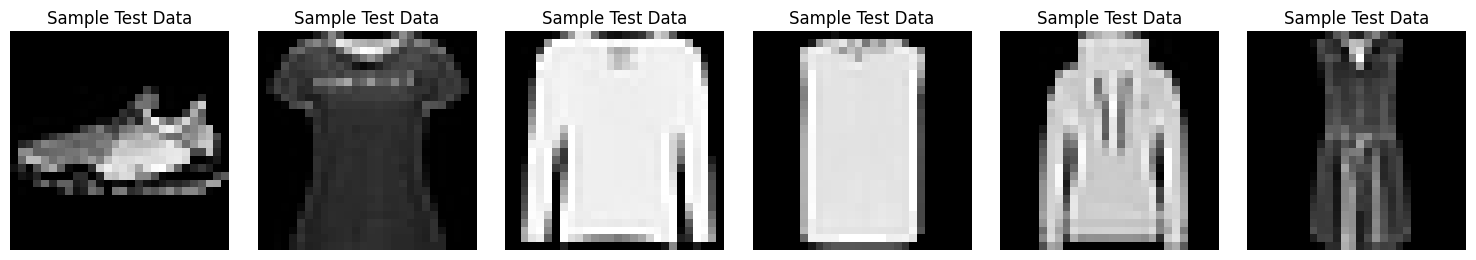

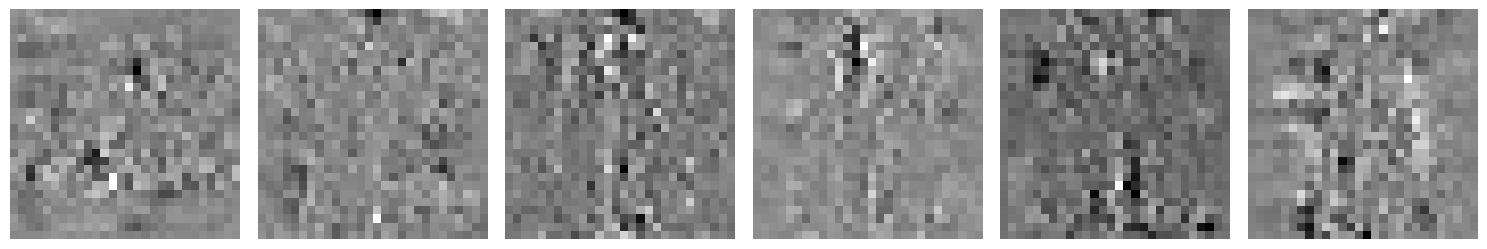

In [56]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

standard_data = []
no_pgd_sal = []

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    gradients = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    #normalize the gradient values
    #normalized_gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    gradient_array = np.squeeze(gradients.detach().cpu().numpy(), axis = 1)

    #plt.imshow(gradient_array[0], cmap = 'gray')
    #plt.colorbar()

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            standard_data.append(data[jj,0].cpu().numpy())
            plt.subplot(2,6,jj+1);plt.imshow(data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.title("Sample Test Data")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            no_pgd_sal.append(gradient_array[jj])
            plt.subplot(2,6,jj+1);plt.imshow(gradient_array[jj],cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

Initial Accuracy of Whitebox Model:  0.869


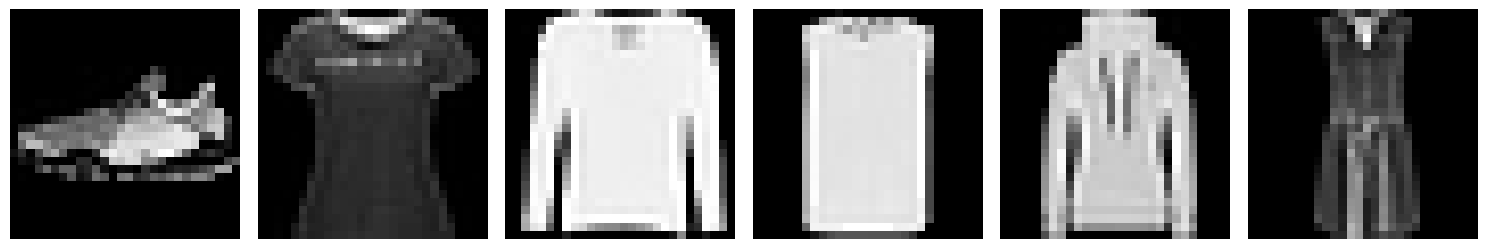

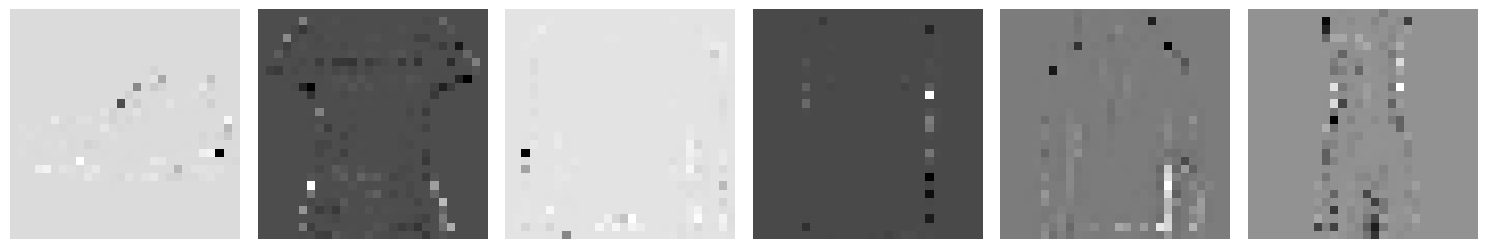

In [44]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

pgd_01_sal_data = []

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    gradients = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    #normalize the gradient values
    #normalized_gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    gradient_array = np.squeeze(gradients.detach().cpu().numpy(), axis = 1)

    #plt.imshow(gradient_array[0], cmap = 'gray')
    #plt.colorbar()

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            pgd_01_sal_data.append(gradient_array[jj])
            plt.subplot(2,6,jj+1);plt.imshow(gradient_array[jj],cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

Initial Accuracy of Whitebox Model:  0.8432


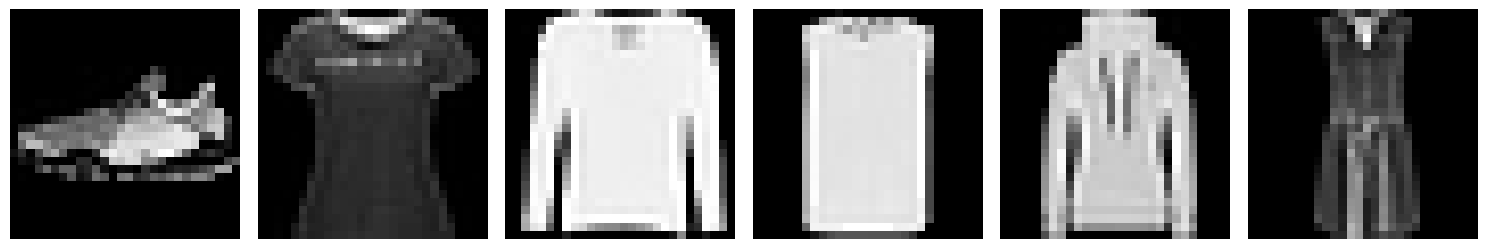

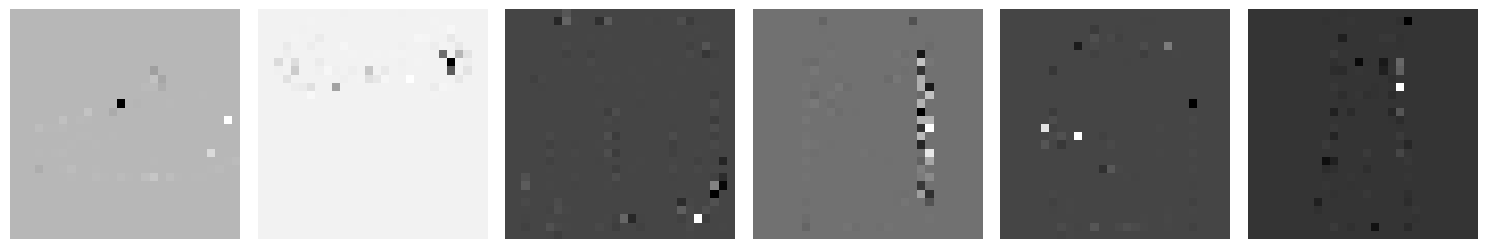

In [45]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1_02.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

pgd_02_sal_data = []

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    gradients = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    #normalize the gradient values
    #normalized_gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    gradient_array = np.squeeze(gradients.detach().cpu().numpy(), axis = 1)

    #plt.imshow(gradient_array[0], cmap = 'gray')
    #plt.colorbar()

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            pgd_02_sal_data.append(gradient_array[jj])
            plt.subplot(2,6,jj+1);plt.imshow(gradient_array[jj],cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

Initial Accuracy of Whitebox Model:  0.8962


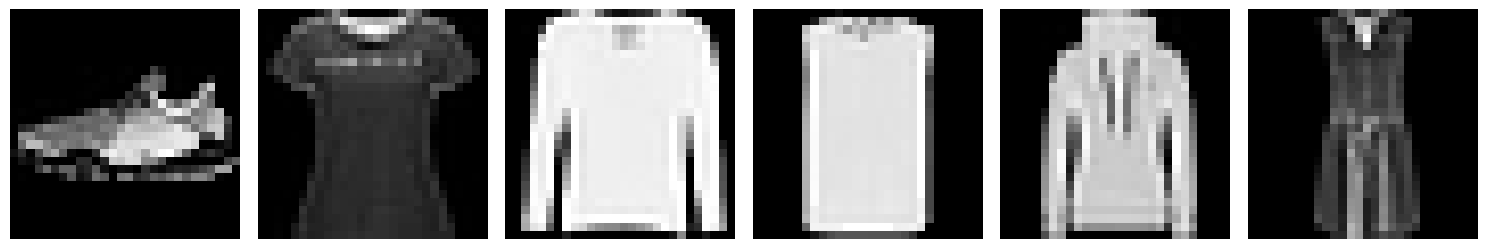

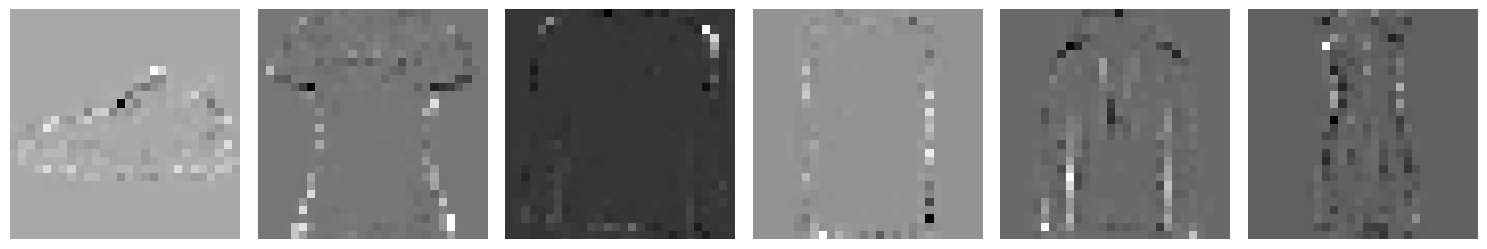

In [47]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1_005.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

pgd_005_sal_data = []

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    gradients = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    #normalize the gradient values
    #normalized_gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    gradient_array = np.squeeze(gradients.detach().cpu().numpy(), axis = 1)

    #plt.imshow(gradient_array[0], cmap = 'gray')
    #plt.colorbar()

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            pgd_005_sal_data.append(gradient_array[jj])
            plt.subplot(2,6,jj+1);plt.imshow(gradient_array[jj],cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

Initial Accuracy of Whitebox Model:  0.8508


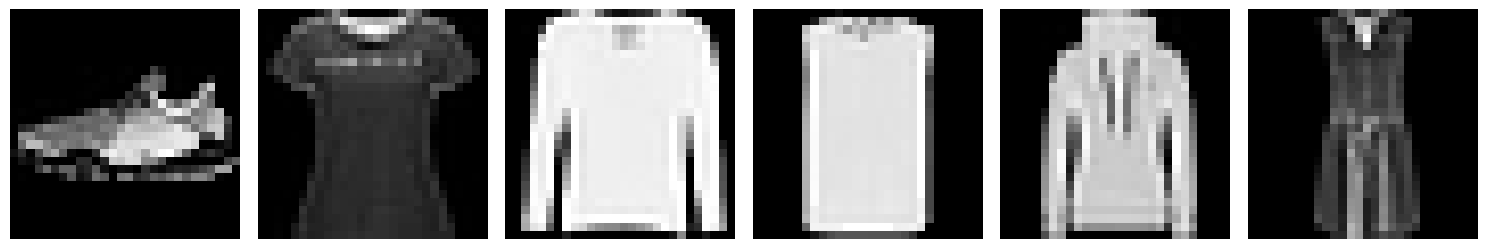

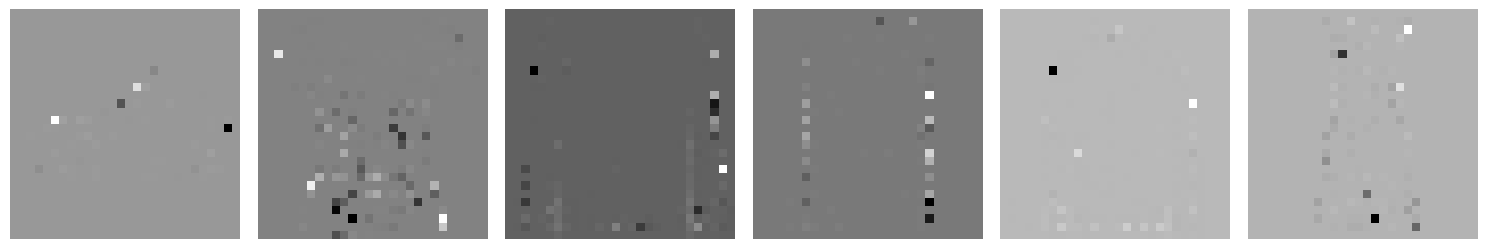

In [48]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1_015.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

pgd_015_sal_data = []

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    gradients = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    #normalize the gradient values
    #normalized_gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    gradient_array = np.squeeze(gradients.detach().cpu().numpy(), axis = 1)

    #plt.imshow(gradient_array[0], cmap = 'gray')
    #plt.colorbar()

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            pgd_015_sal_data.append(gradient_array[jj])
            plt.subplot(2,6,jj+1);plt.imshow(gradient_array[jj],cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

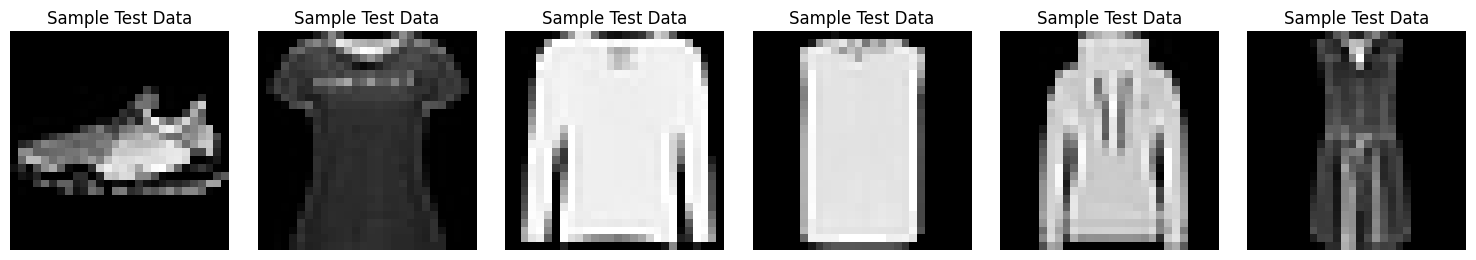

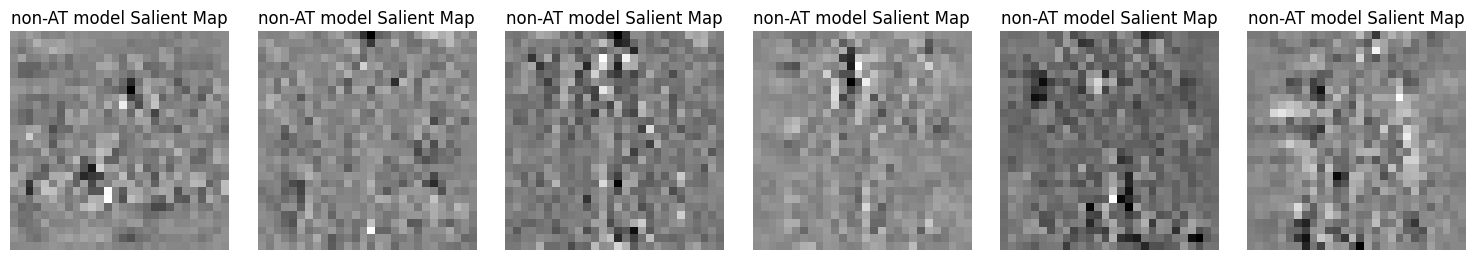

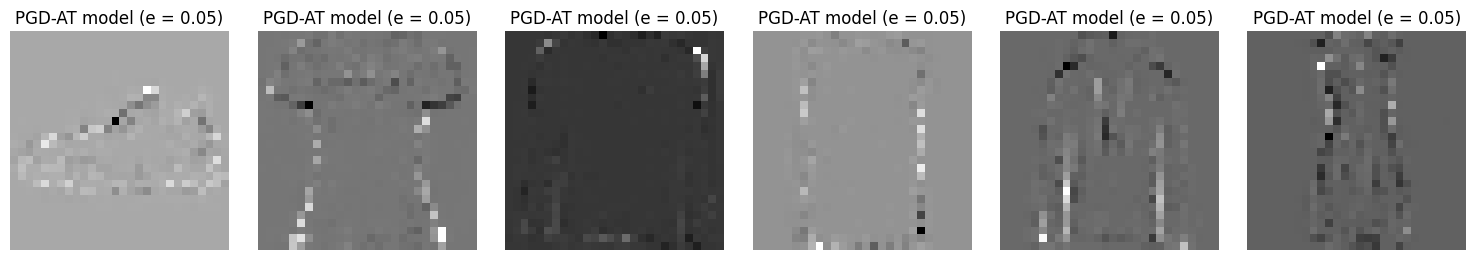

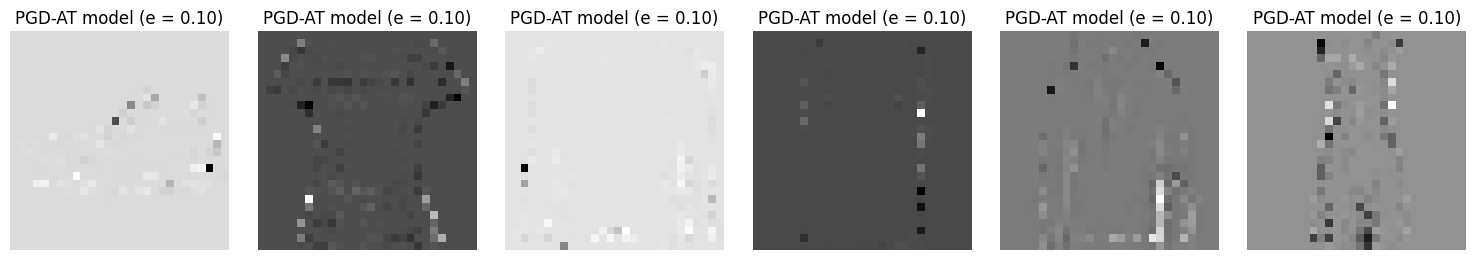

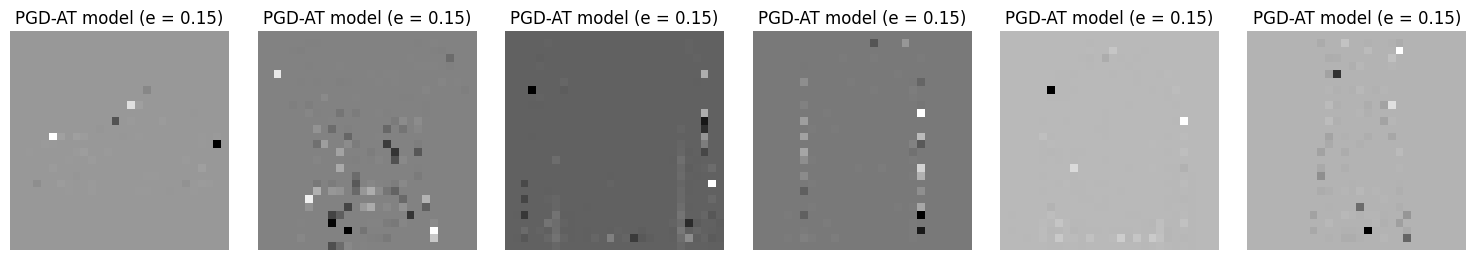

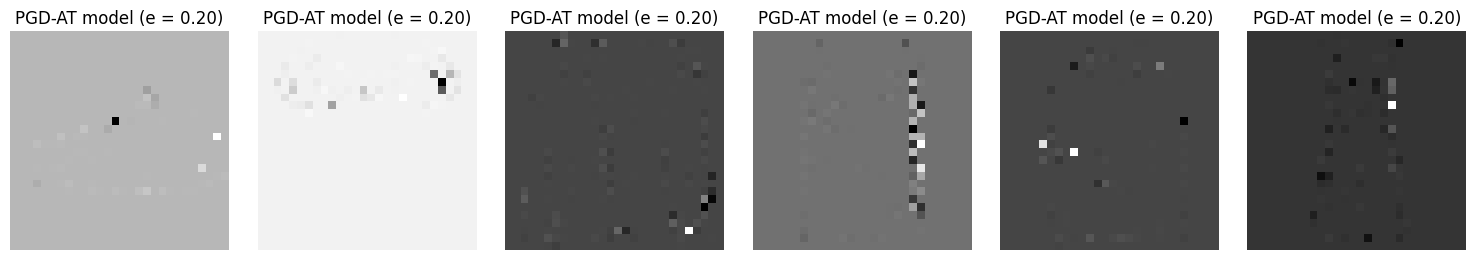

In [62]:
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(standard_data[jj-6],cmap='gray');plt.axis("off")
            plt.title("Sample Test Data")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(no_pgd_sal[jj-6],cmap='gray');plt.axis("off")
            plt.title("non-AT model Salient Map")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(pgd_005_sal_data[jj-6],cmap='gray');plt.axis("off")
            plt.title("PGD-AT model (e = 0.05)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(pgd_01_sal_data[jj-6],cmap='gray');plt.axis("off")
            plt.title("PGD-AT model (e = 0.10)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(pgd_015_sal_data[jj-6],cmap='gray');plt.axis("off")
            plt.title("PGD-AT model (e = 0.15)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15,5))
        for jj in range(6, 12):
            plt.subplot(2,6,jj+1);plt.imshow(pgd_02_sal_data[jj-6],cmap='gray');plt.axis("off")
            plt.title("PGD-AT model (e = 0.20)")
        plt.tight_layout()
        plt.show()

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load()) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

## Test the model against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = ?
#ATK_ITERS = ?
#ATK_ALPHA = ?

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    # TODO: Perform adversarial attack here
    
    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)
    
    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(12):
            plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

# Print final 
whitebox_acc = whitebox_correct/running_total
print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")